In [2]:
import networkx as nx
import networkx.algorithms.community 
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community.kclique import k_clique_communities
import matplotlib.pyplot as plt
from datetime import datetime
import community
import csv
import operator
import random
%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})
from numpy import random as nprand
random.seed(123)
nprand.seed(123)

In [3]:
def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            G.nodes[v]['community'] = c + 1

In [4]:
def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    edge_list = {}  
    inner_edges = {}
    degree_list = {}
    node_edges_internal = {}
    node_edges_external = {}
    for v, w, in G.edges:
        if 'community' not in G.nodes[v]:
            G.nodes[v]['community'] = 0
        if 'community' not in G.nodes[w]:
            G.nodes[w]['community'] = 0
        
        v_com = G.nodes[v]['community']
        w_com = G.nodes[w]['community']
        
        if v_com not in edge_list:
            edge_list[v_com] = [0,0]
            inner_edges[v_com] = []
            degree_list[v_com] = {}
            node_edges_internal[v_com] = {}
            node_edges_external[v_com] = {}
            
        if w_com not in edge_list:
            edge_list[w_com] = [0,0]
            inner_edges[w_com] = []
            degree_list[w_com] = {}
            node_edges_internal[w_com] = {}
            node_edges_external[w_com] = {}
        
        if v not in degree_list[v_com]:
            degree_list[v_com][v] = 0
            node_edges_internal[v_com][v] = 0
            node_edges_external[v_com][v] = {}
            
        if w not in degree_list[w_com]:
            degree_list[w_com][w] = 0
            node_edges_internal[w_com][w] = 0
            node_edges_external[w_com][w] = {}
        
        if v_com not in node_edges_external[w_com][w]:
            node_edges_external[w_com][w][v_com] = 0
        
        if w_com not in node_edges_external[v_com][v]:
            node_edges_external[v_com][v][w_com] = 0
                
        if v_com == w_com:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = v_com
            edge_list[v_com][0] +=1
            degree_list[v_com][v] +=1
            degree_list[w_com][w] +=1
            node_edges_internal[v_com][v] += 1
            node_edges_internal[w_com][w] += 1
            inner_edges[v_com].append(str(v)+" "+str(w))
            
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0
            edge_list[v_com][1] +=1
            edge_list[w_com][1] +=1
            degree_list[v_com][v] +=1
            degree_list[w_com][w] +=1
            node_edges_external[v_com][v][w_com] += 1
            node_edges_external[w_com][w][v_com] += 1
    return edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges

In [5]:
def findExternalMax(node_edges_external):
    max_edges = {}
    for i in node_edges_external:
        data = {"nodes":{}}
        max_edge = 0
        max_node = 0
        max_community = 0
        nodes = node_edges_external[i]
        for n in nodes:
            c_e = nodes[n]
            c_e = sorted(c_e.items(), key=operator.itemgetter(1), reverse=True)
            
            if max_edge<c_e[0][1]:
                max_edge = c_e[0][1]
                max_node = n
                max_community = c_e[0][0]
            data["nodes"][n] = c_e[0]
        data["max_external_edge"]= max_edge
        data["node"]= max_node
        data["external_community"]= max_community
        max_edges[i]= data
    return max_edges

In [6]:
def findingCoefficient(g):
    return nx.clustering(g)

def getCoefficient(community_inner_edges):
    coefficient = {}
    for i in community_inner_edges:
        G = nx.parse_edgelist(inner_edges[i], nodetype = str) 
        poss = nx.spring_layout(G, k=0.1)
        nx.draw_networkx(G, pos=poss, node_size=50, node_color="silver", edge_color="silver", alpha=0.5, with_labels=True)
        plt.show()
        coefficient[i] = findingCoefficient(G)
    return coefficient

In [7]:
def calculatePermanence(node_edges_internal, external_edges, degree_list, coefficient):
    permanence = {}
    for community in coefficient:
        permanence[community] = {}
        for i in coefficient[community]:
            if (external_edges[community]['nodes'][str(i)][1]):
                k = external_edges[community]['nodes'][str(i)][1]*degree_list[community][str(i)]
                perm = (node_edges_internal[community][str(i)]/(k)) - (1-coefficient[community][i])
            else:
                perm = coefficient[community][i]
            permanence[community][i] = perm
            
    return permanence

In [8]:
def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b) 

In [9]:
edge_data  = []
with open('ternet.csv') as datafile:
    data = csv.reader(datafile, delimiter=',')
    header = next(data)
    for j, row in enumerate(data):
        for i,x in enumerate(row):
            if x=='1':
                edge_data.append(str(j+1)+" "+str(i))

In [10]:
G = nx.parse_edgelist(edge_data, nodetype = str)
pos = nx.spring_layout(G,k=0.1)

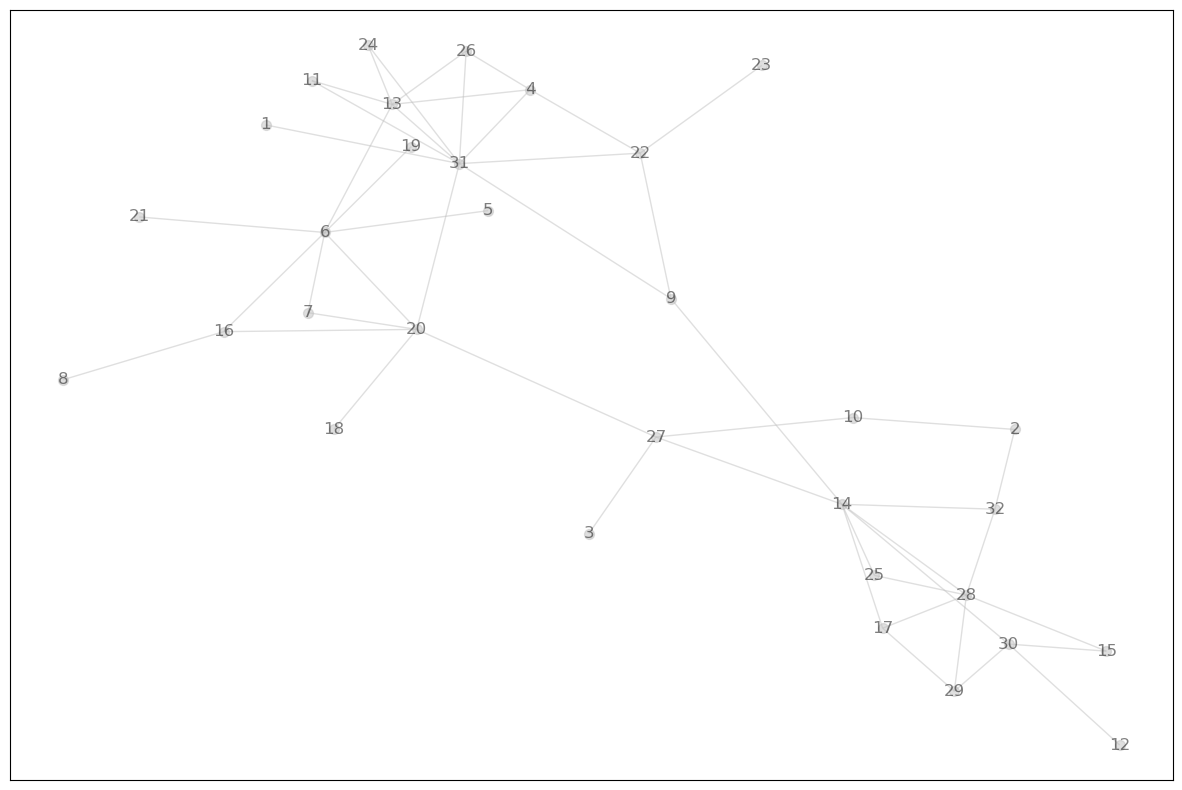

In [11]:
#labeled network
# Draw network
nx.draw_networkx(G, pos=pos, node_size=50, node_color="silver", edge_color="silver", alpha=0.5, with_labels=True)
plt.show()

In [12]:
#Community detection algorithms implemented - 
#Girwan Newman
#Label Propogation
#Greedy Modularity
#Asyn Lpa 

#Finally constant communities are found

# Girwan Newman

In [13]:
start_time = datetime.now()
communities_generator = girvan_newman(G)
next(communities_generator)
girvan_communities = next(communities_generator)
end_time = datetime.now()

In [14]:
print(f"The total number of Girwan Newman communities = {len(girvan_communities)}\n")

The total number of Girwan Newman communities = 3



In [15]:
set_node_community(G, girvan_communities)
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(G)
girvan_external_edges = findExternalMax(node_edges_external)

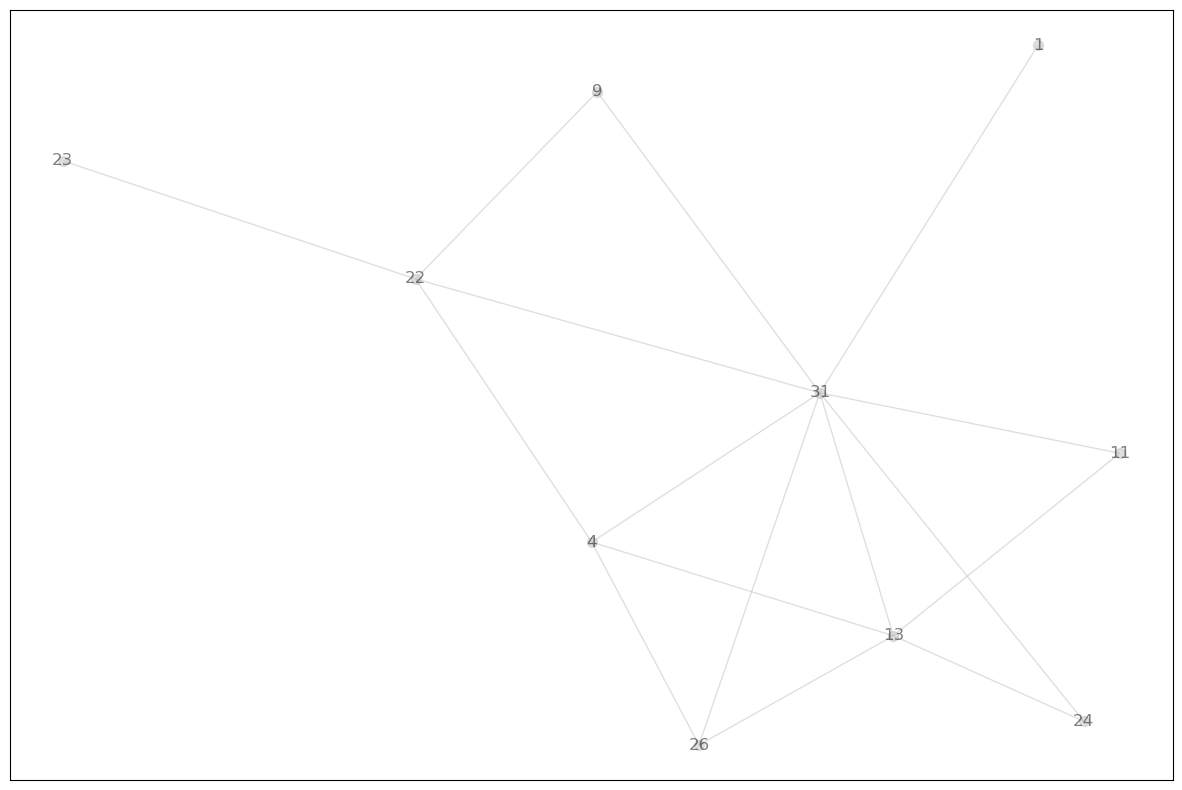

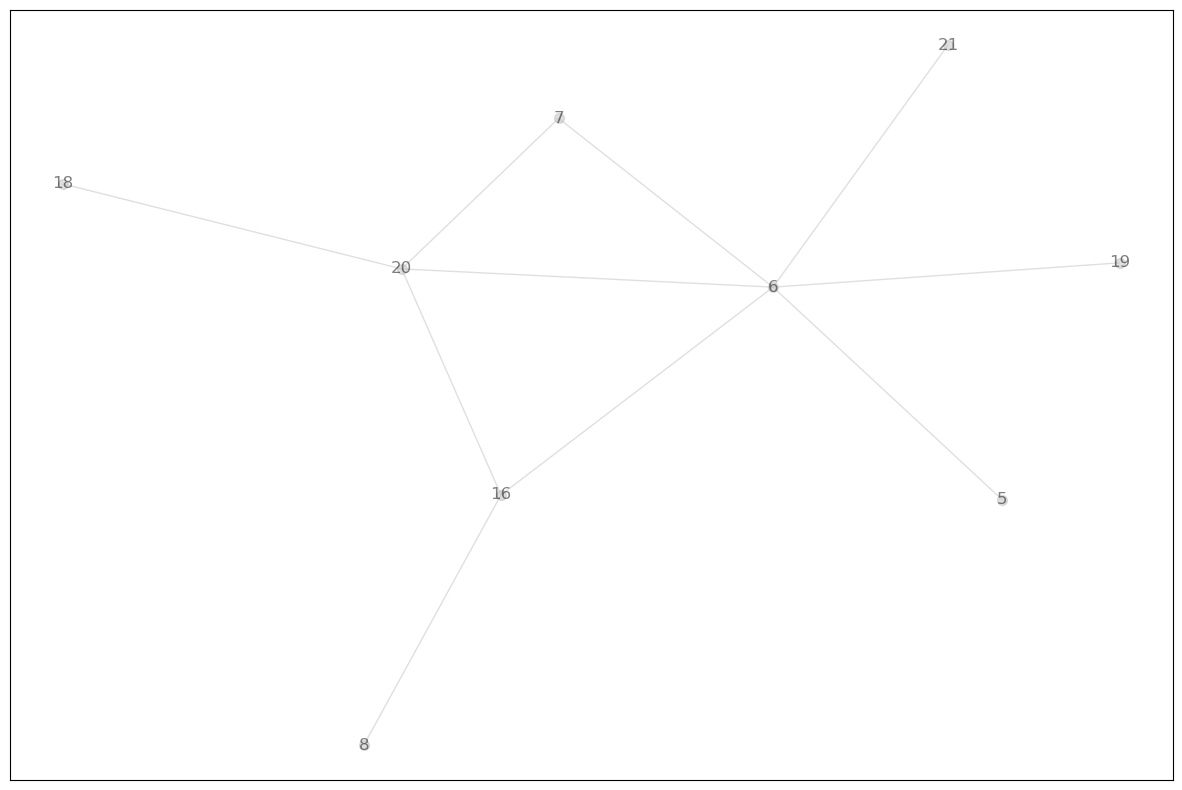

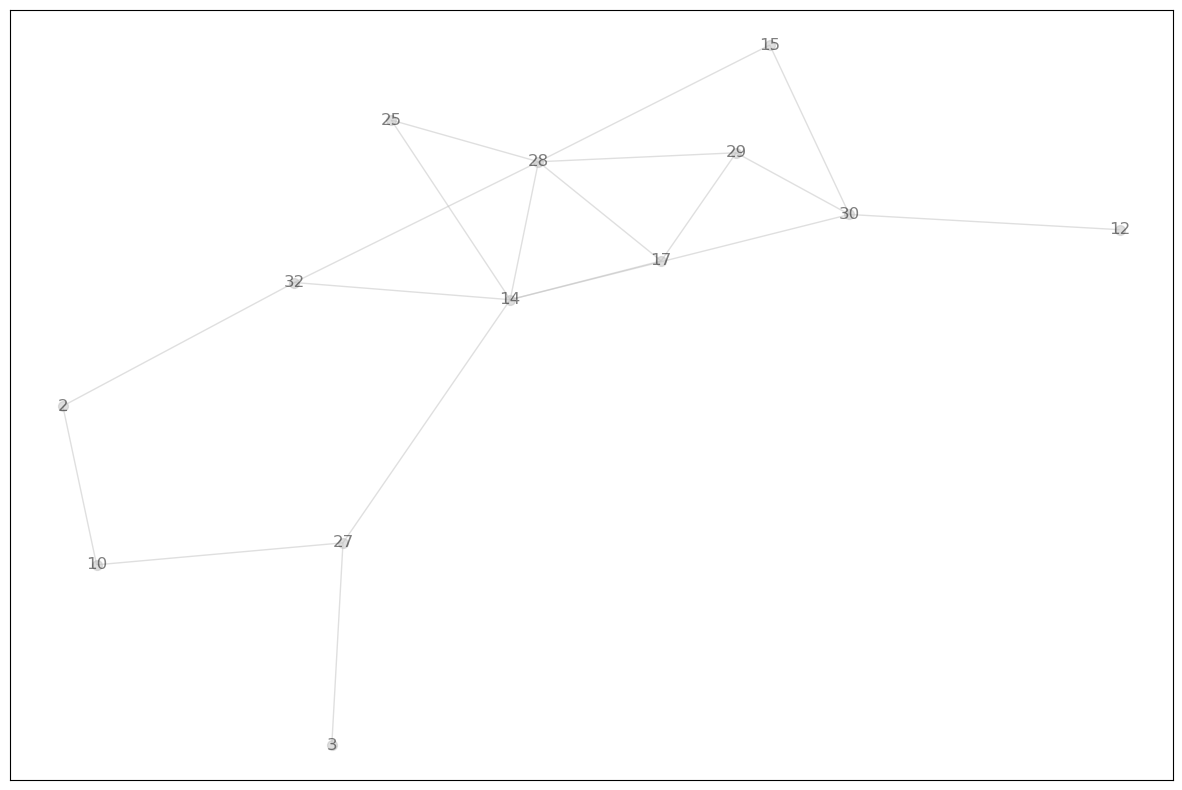

In [16]:
girvan_coefficient = getCoefficient(inner_edges)

In [17]:
#permanace for each node
girvan_permanence = calculatePermanence(node_edges_internal, girvan_external_edges, degree_list, girvan_coefficient)

In [18]:
external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]

In [19]:
node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]
internal_color = [get_color(G.edges[e]['community']) for e in internal]

In [20]:
print("Community \tNo of Nodes \tNo of Internal Edges \tNo of External Edges \t Density \t Hub Dominance")
for i,c in enumerate(girvan_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>=1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1)
    print(f"{i+1} \t\t{len(c)} \t\t {edge_list[i+1][0]} \t\t\t{edge_list[i+1][1]}\t\t\t{d:.3f} \t\t\t {h:.3f}")
print(f"Time taken by algorithm {end_time-start_time}\n")
print(edge_list)

Community 	No of Nodes 	No of Internal Edges 	No of External Edges 	 Density 	 Hub Dominance
1 		10 		 16 			3			0.356 			 1.000
2 		13 		 20 			2			0.256 			 0.667
3 		9 		 10 			3			0.278 			 0.875
Time taken by algorithm 0:00:00.043608

{1: [16, 3], 3: [10, 3], 2: [20, 2]}


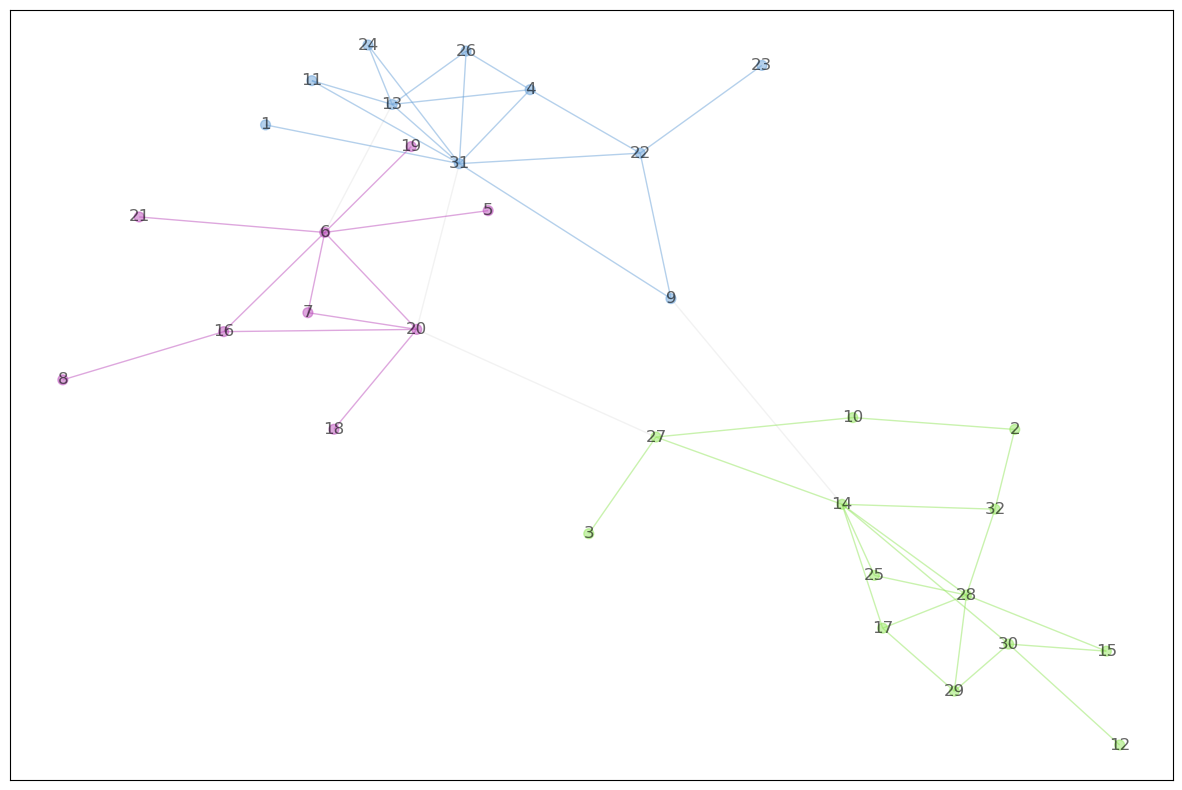

In [306]:
nx.draw_networkx(G, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=True)
nx.draw_networkx(G, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=True)
plt.show()

In [ ]:
#safeness
safeness = {}
comm = []

for i,c in enumerate(girvan_communities):
  x = (len(c)-1)
  comm.append(x)

count=0
x=0
for community in degree_list:
  safeness[community] = {}
  for i in degree_list[community]:
    s = ( ( (...............) - (node_edges_internal[community][str(i)] ) ) / comm[count] ) / 2
    d = ( (node_edges_internal[community][str(i)]) / (degree_list[community][str(i)]) ) / 2
    
    x = s + d
    safeness[community][i] = x
  count=count+1
print(safeness)

In [308]:
girvan_external_edges

{1: {'nodes': {'1': (1, 0),
   '31': (3, 1),
   '4': (1, 0),
   '9': (2, 1),
   '13': (3, 1),
   '22': (1, 0),
   '24': (1, 0),
   '26': (1, 0),
   '11': (1, 0),
   '23': (1, 0)},
  'max_external_edge': 1,
  'node': '31',
  'external_community': 3},
 3: {'nodes': {'20': (1, 1),
   '6': (1, 1),
   '5': (3, 0),
   '16': (3, 0),
   '19': (3, 0),
   '21': (3, 0),
   '7': (3, 0),
   '8': (3, 0),
   '18': (3, 0)},
  'max_external_edge': 1,
  'node': '20',
  'external_community': 1},
 2: {'nodes': {'2': (2, 0),
   '10': (2, 0),
   '32': (2, 0),
   '27': (3, 1),
   '14': (1, 1),
   '28': (2, 0),
   '3': (2, 0),
   '17': (2, 0),
   '25': (2, 0),
   '30': (2, 0),
   '12': (2, 0),
   '15': (2, 0),
   '29': (2, 0)},
  'max_external_edge': 1,
  'node': '27',
  'external_community': 3}}

# K_clique

In [309]:
start_time = datetime.now()
clique_communities = list(k_clique_communities(G, 10))
end_time = datetime.now()

In [310]:
set_node_community(G, clique_communities)
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(G)

In [311]:
clique_external_edges = findExternalMax(node_edges_external)

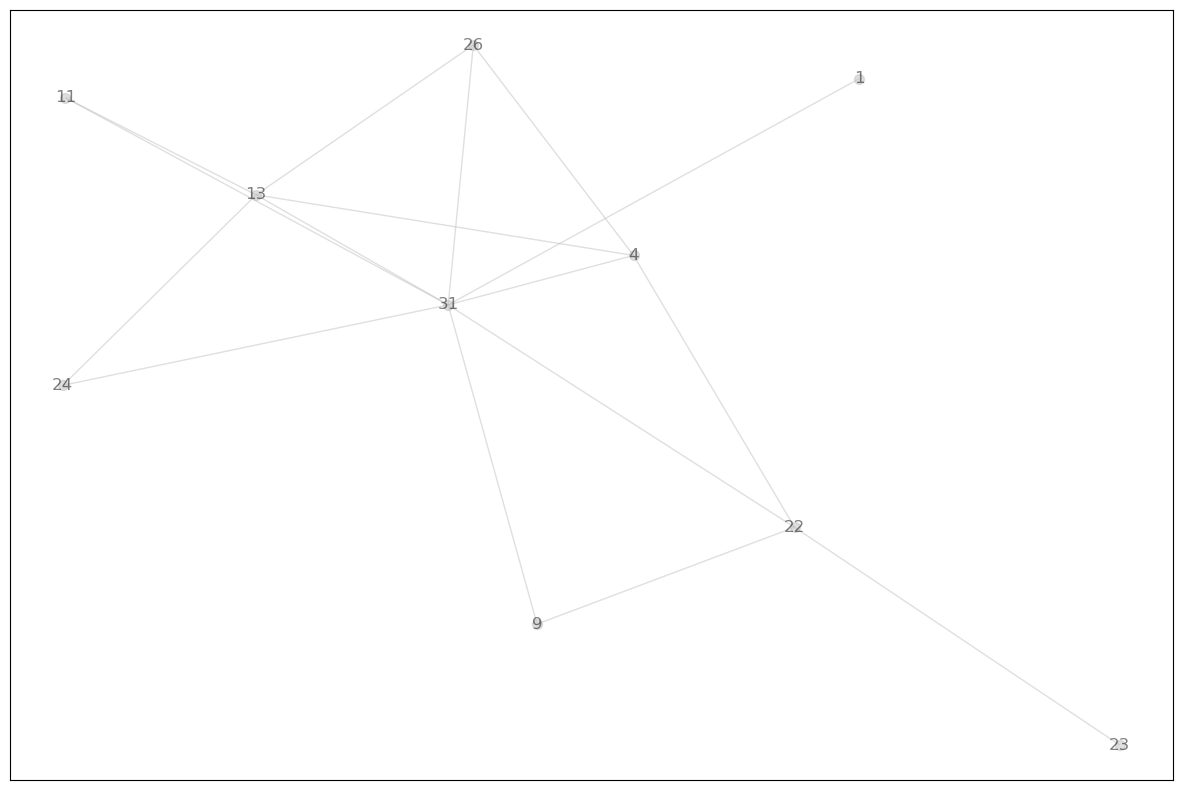

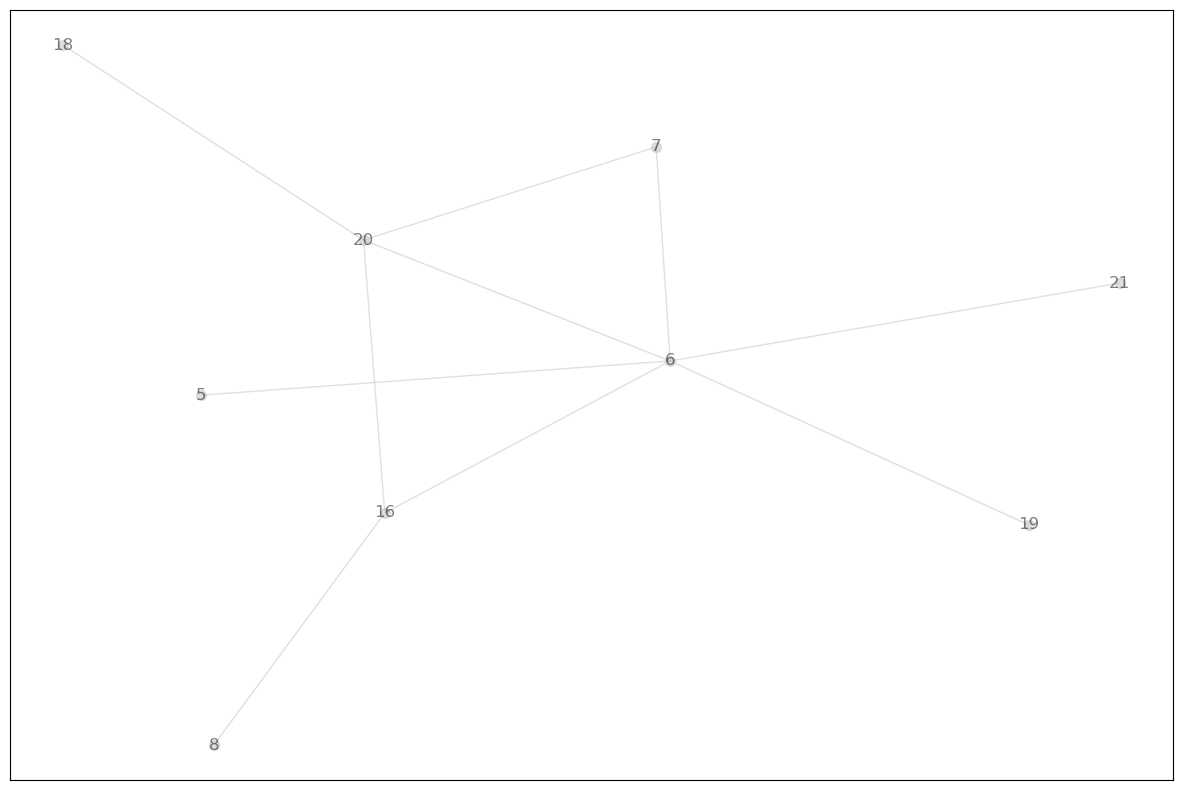

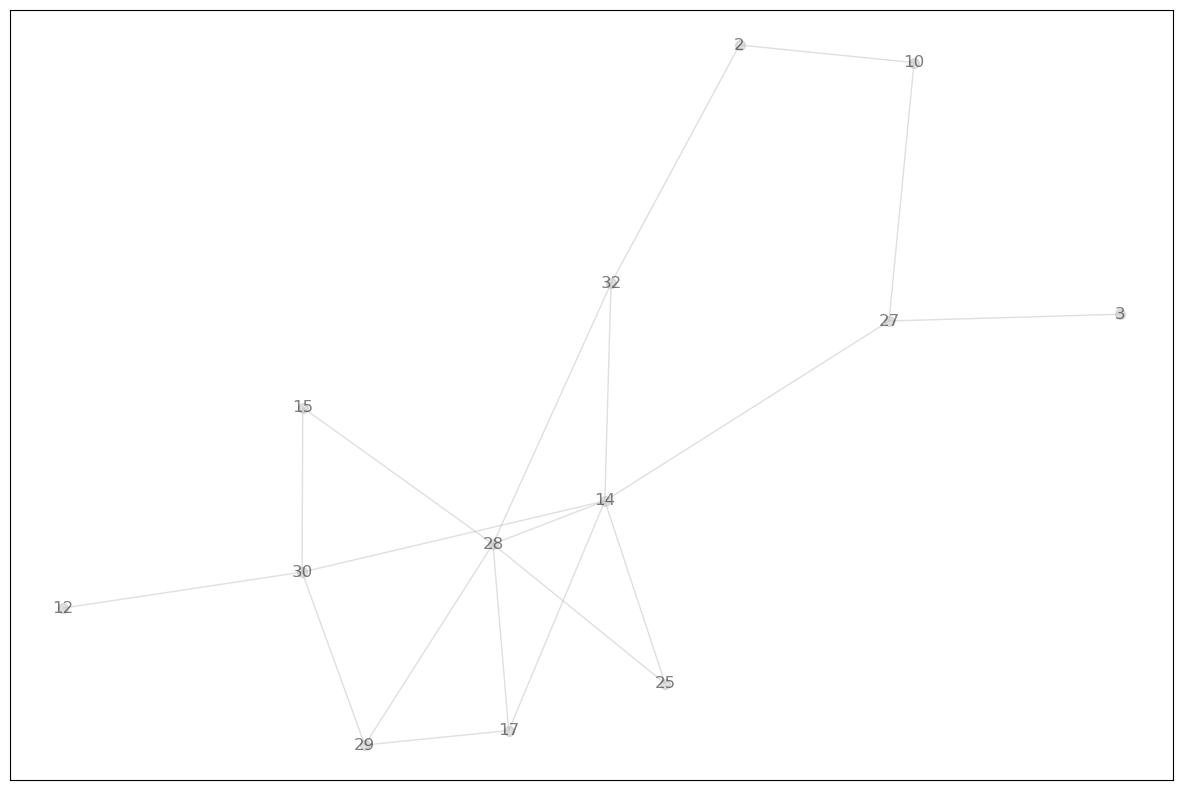

In [312]:
clique_coefficient = getCoefficient(inner_edges)

In [313]:
clique_permanence = calculatePermanence(node_edges_internal, clique_external_edges, degree_list, clique_coefficient)

In [314]:
external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]

In [315]:
node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]
internal_color = [get_color(G.edges[e]['community']) for e in internal]

In [316]:
print(f"Time taken by algorithm {end_time-start_time}\n")


Time taken by algorithm 0:00:00.000437



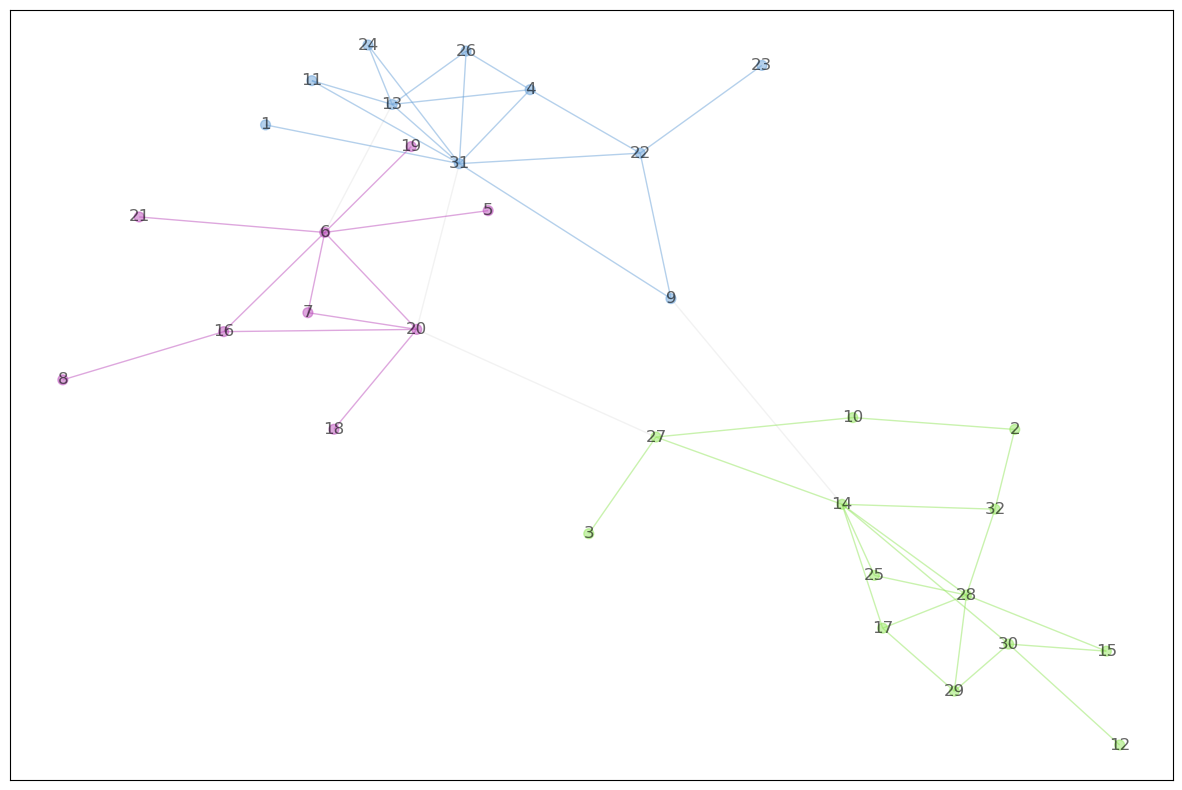

In [317]:
nx.draw_networkx(G, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=True)
nx.draw_networkx(G, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=True)
plt.show()

In [318]:
clique_permanence

{1: {'1': 0,
  '31': 0.13888888888888884,
  '4': 0.6666666666666666,
  '9': 0.6666666666666666,
  '13': 0.33333333333333337,
  '22': 0.3333333333333333,
  '24': 1.0,
  '26': 1.0,
  '11': 1.0,
  '23': 0},
 3: {'6': -0.009523809523809601,
  '5': 0,
  '16': 0.3333333333333333,
  '19': 0,
  '21': 0,
  '7': 1.0,
  '20': -1.1102230246251565e-16,
  '8': 0,
  '18': 0},
 2: {'2': 0,
  '10': 0,
  '32': 0.3333333333333333,
  '27': -0.25,
  '14': 0.05714285714285705,
  '28': 0.26666666666666666,
  '3': 0,
  '17': 0.6666666666666666,
  '25': 1.0,
  '30': 0,
  '12': 0,
  '15': 0,
  '29': 0.3333333333333333}}

# Label propogation Communities

In [319]:
start_time = datetime.now()
label_communities = sorted(networkx.algorithms.community.label_propagation_communities(G), key=len, reverse=True)
end_time = datetime.now()

In [320]:
print(f"The total number of Label propogation communities = {len(label_communities)}.\n")

The total number of Label propogation communities = 4.



In [321]:
set_node_community(G, label_communities)
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(G)

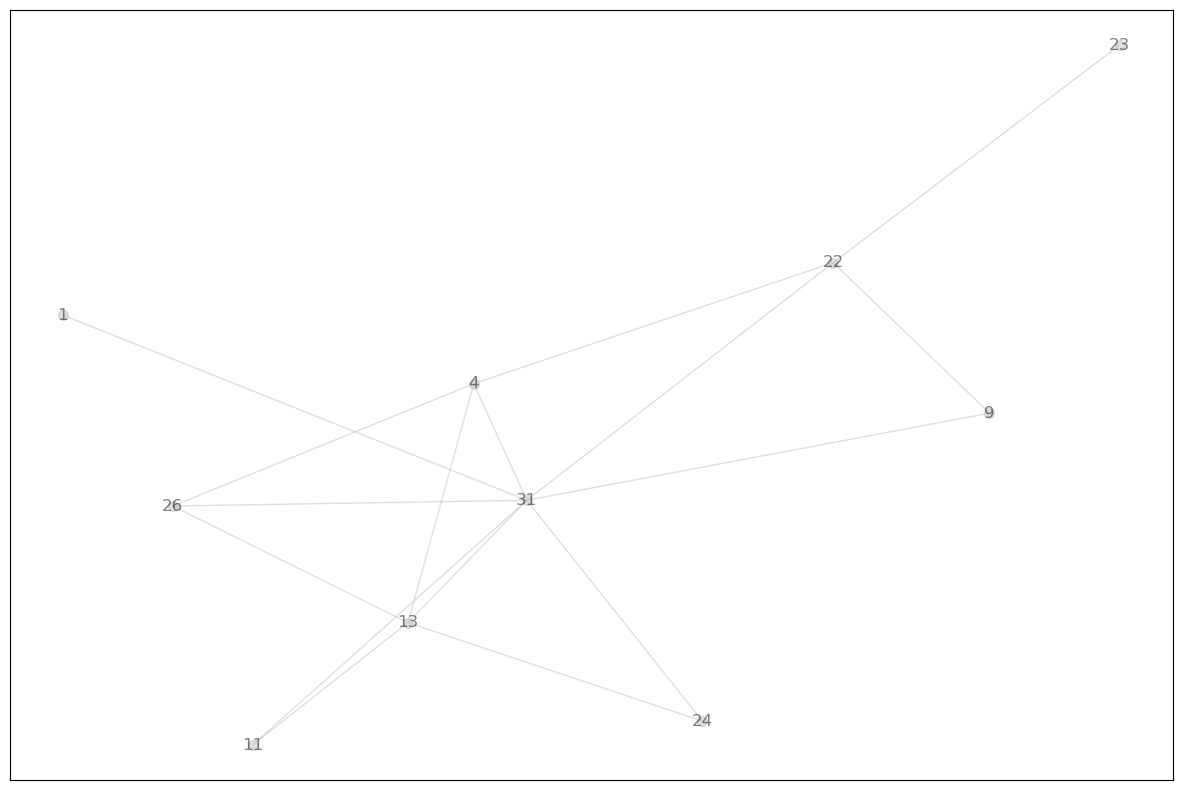

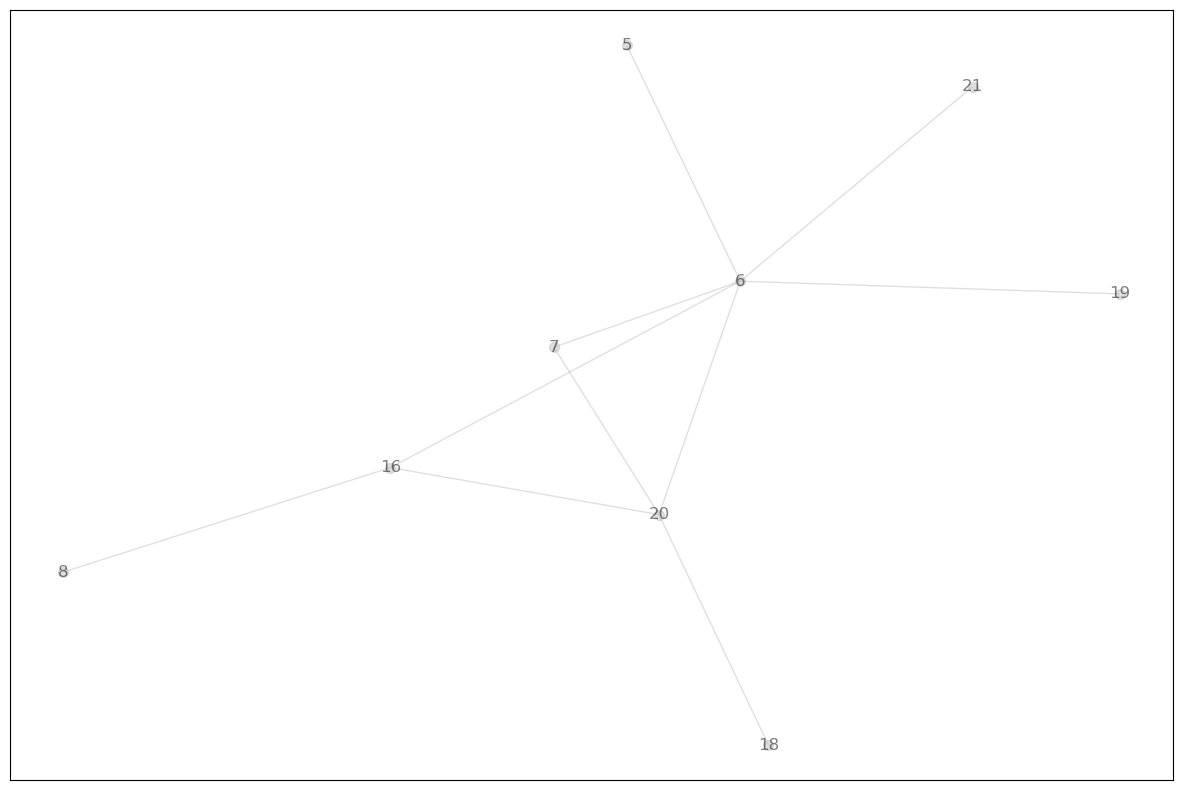

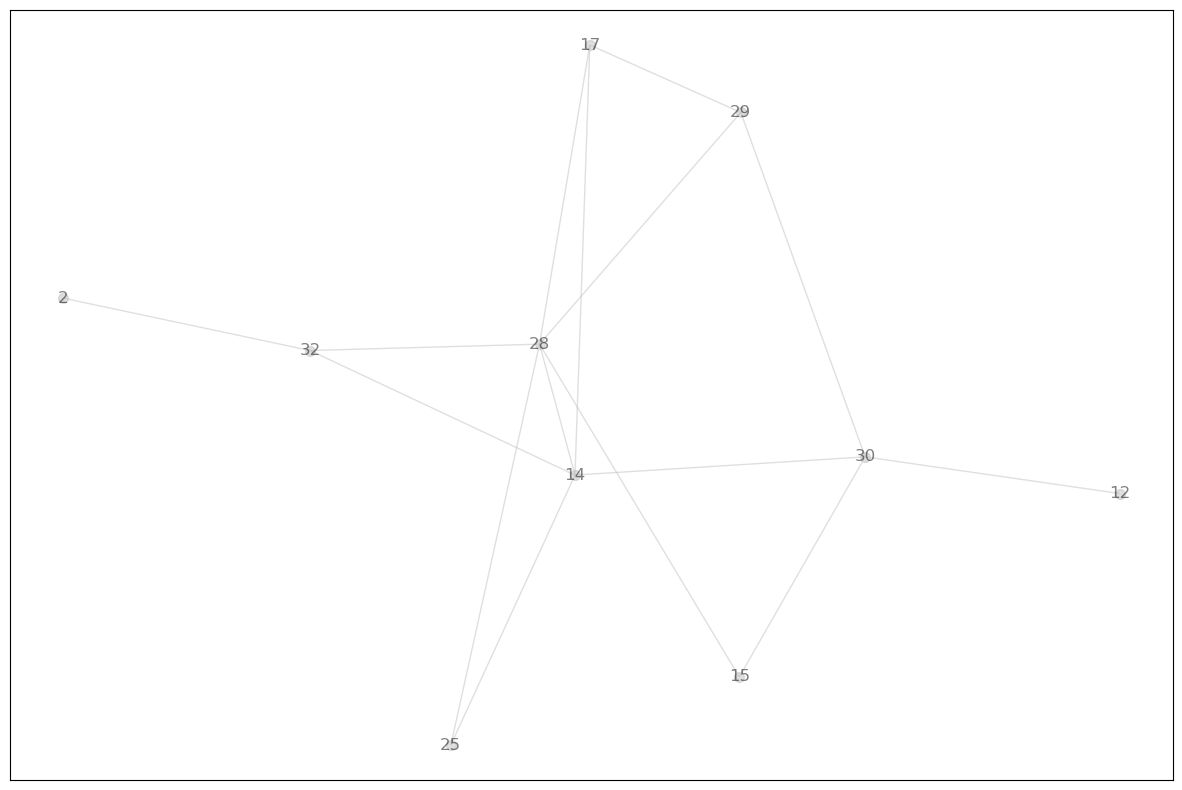

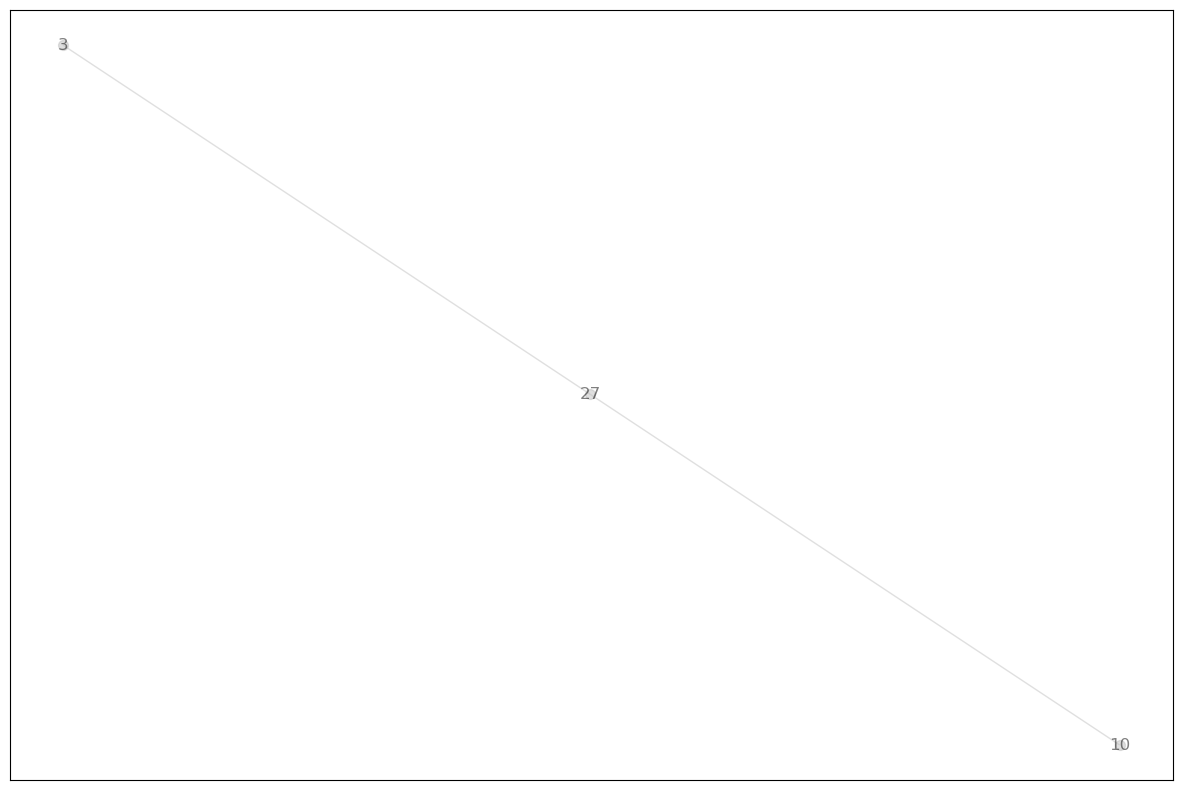

In [322]:
label_external_edges = findExternalMax(node_edges_external)
label_coefficient = getCoefficient(inner_edges)

In [323]:
label_permanence = calculatePermanence(node_edges_internal, label_external_edges, degree_list, label_coefficient)

In [324]:
external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]

In [325]:
node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]
internal_color = [get_color(G.edges[e]['community']) for e in internal]

In [326]:
print("Community \tNo of Nodes \tNo of Internal Edges \tNo of External Edges \t Density \t Hub Dominance")
for i,c in enumerate(label_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>=1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1)
    print(f"{i+1} \t\t{len(c)} \t\t {edge_list[i+1][0]} \t\t\t{edge_list[i+1][1]}\t\t\t{d:.3f} \t\t\t {h:.3f}")
print(f"Time taken by algorithm {end_time-start_time}\n")

Community 	No of Nodes 	No of Internal Edges 	No of External Edges 	 Density 	 Hub Dominance
1 		10 		 16 			3			0.356 			 1.000
2 		10 		 16 			3			0.356 			 0.889
3 		9 		 10 			3			0.278 			 0.875
4 		3 		 2 			3			0.667 			 2.000
Time taken by algorithm 0:00:00.002264



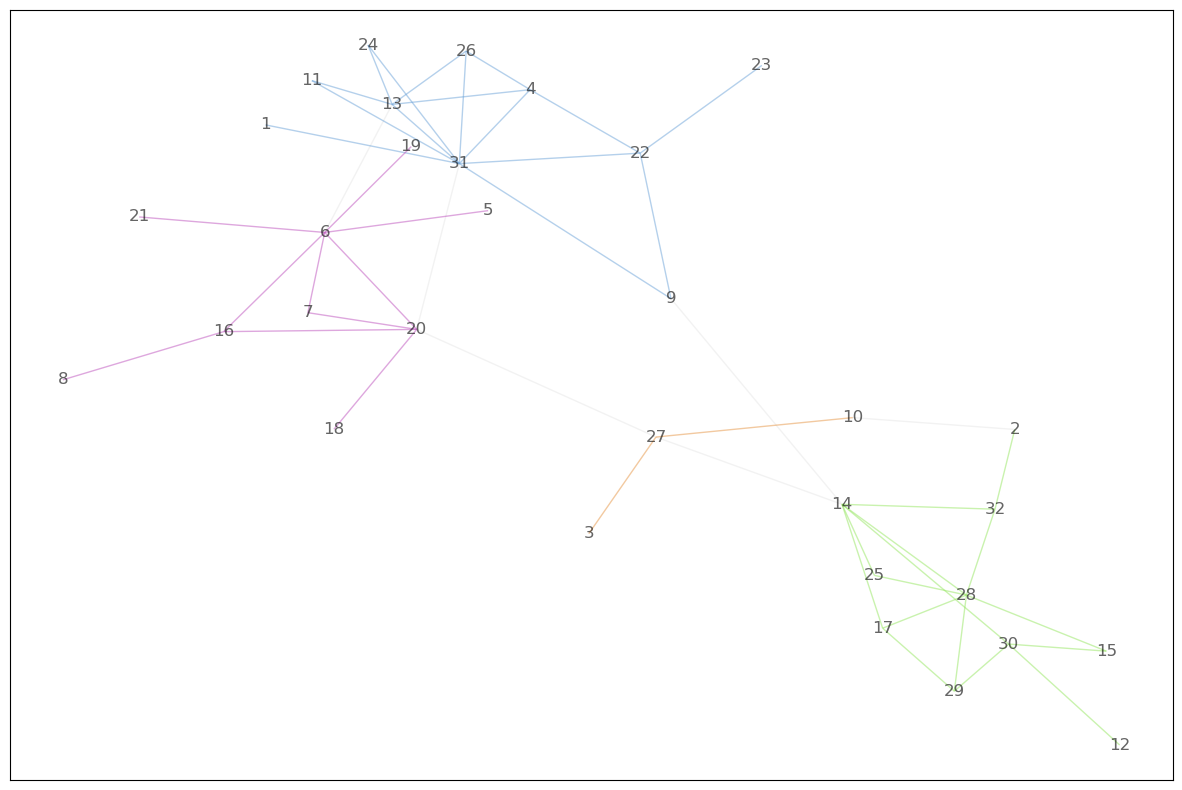

In [327]:
nx.draw_networkx(G, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=True)
nx.draw_networkx(G, pos=pos, node_size=0, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=True)
plt.show()

In [328]:
label_permanence

{1: {'1': 0,
  '31': 0.13888888888888884,
  '4': 0.6666666666666666,
  '9': 0.6666666666666666,
  '13': 0.33333333333333337,
  '22': 0.3333333333333333,
  '24': 1.0,
  '26': 1.0,
  '11': 1.0,
  '23': 0},
 3: {'6': -0.009523809523809601,
  '5': 0,
  '16': 0.3333333333333333,
  '19': 0,
  '21': 0,
  '7': 1.0,
  '20': -1.1102230246251565e-16,
  '8': 0,
  '18': 0},
 2: {'2': -0.5,
  '32': 0.3333333333333333,
  '14': 0.014285714285714346,
  '28': 0.26666666666666666,
  '17': 0.6666666666666666,
  '25': 1.0,
  '30': 0,
  '12': 0,
  '15': 0,
  '29': 0.3333333333333333},
 4: {'10': -0.5, '27': -0.5, '3': 0}}

# Greedy Modularity communities

In [329]:
start_time = datetime.now()
greedy_communities = sorted(networkx.algorithms.community.greedy_modularity_communities(G), key=len, reverse=True)
end_time = datetime.now()

In [330]:
print(f"The total number of Greedy modularity communities in the network = {len(greedy_communities)}.\n")

The total number of Greedy modularity communities in the network = 4.



In [331]:
set_node_community(G, greedy_communities)
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(G)

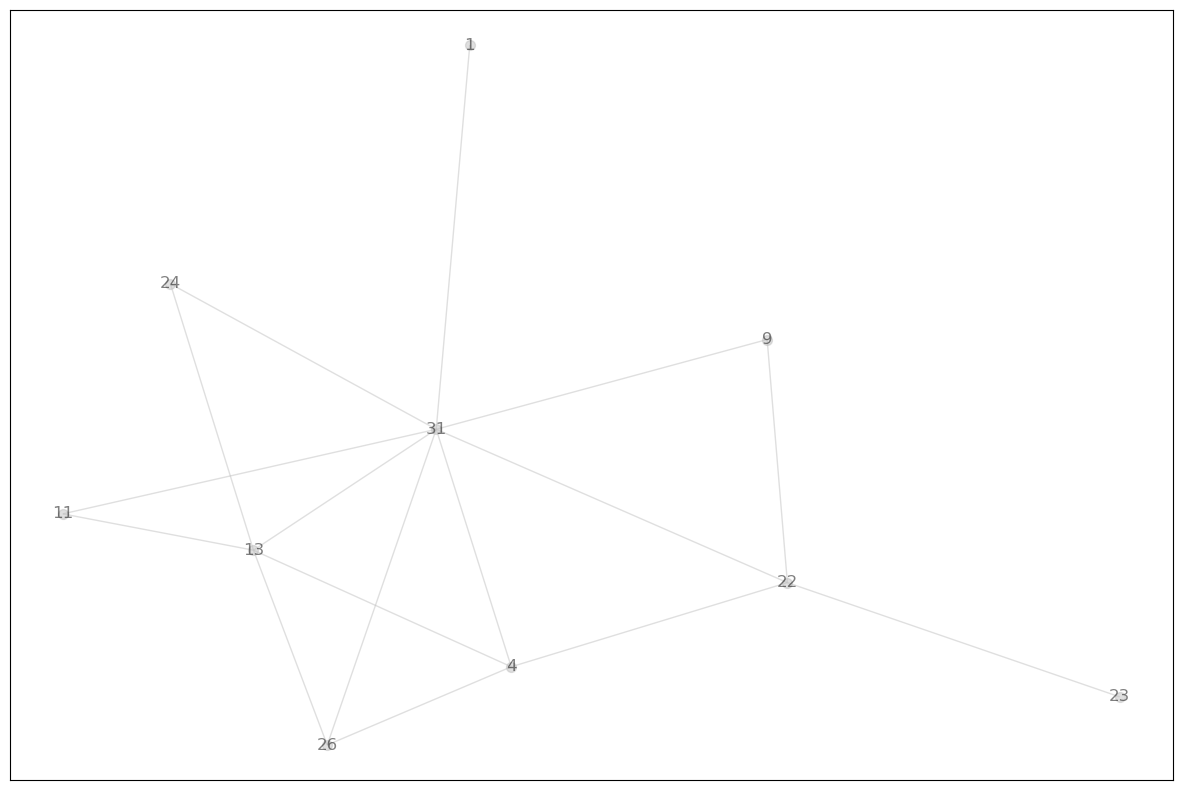

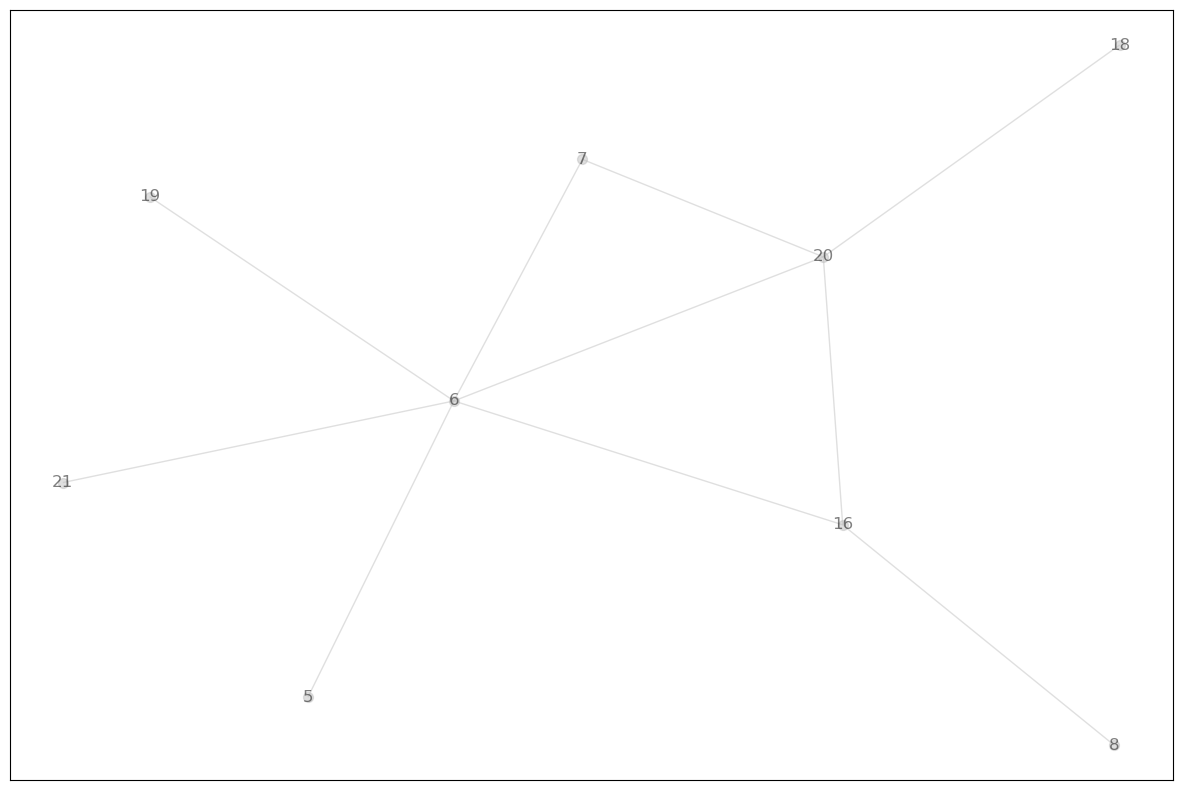

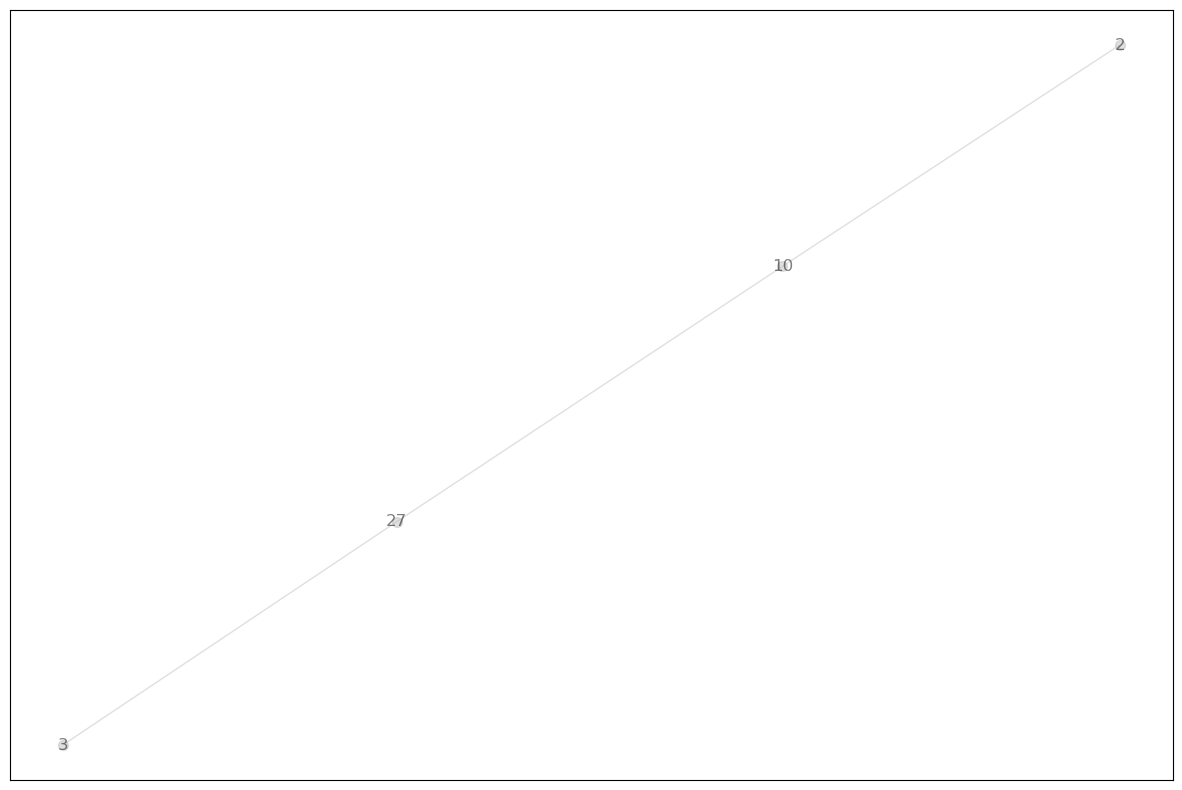

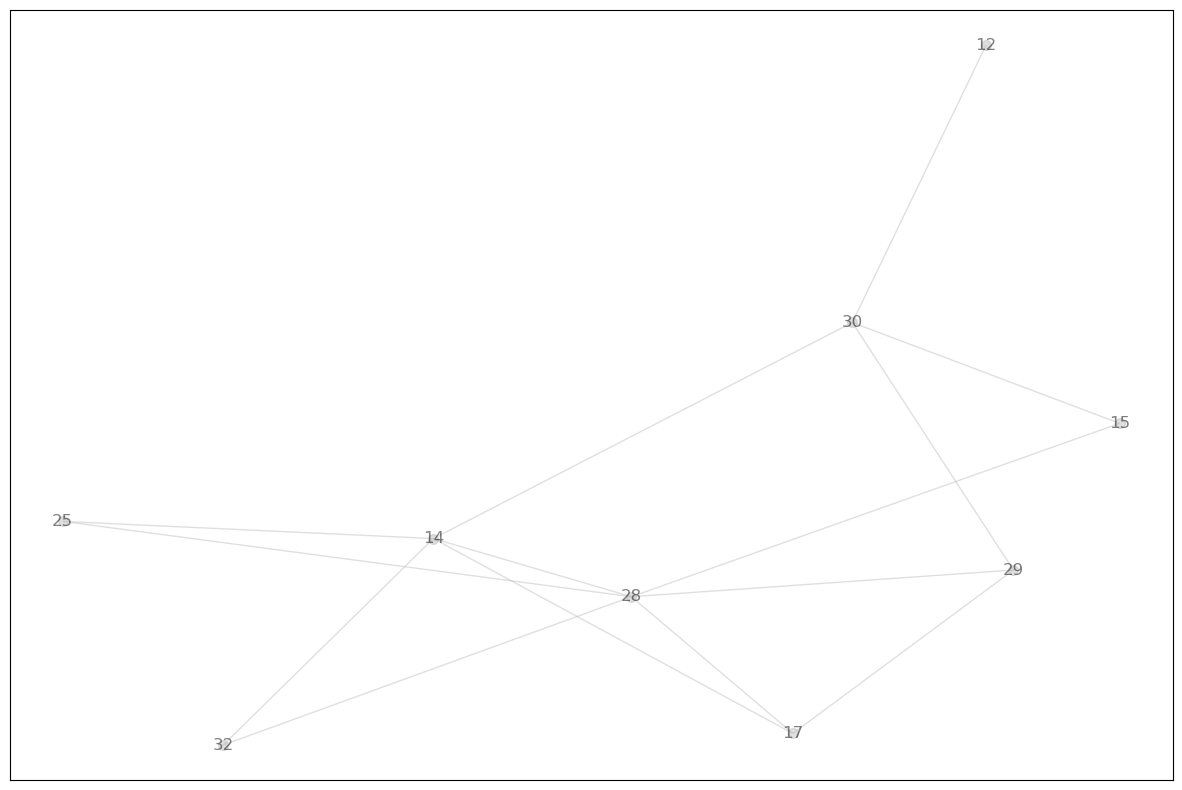

In [332]:
greedy_external_edges = findExternalMax(node_edges_external)
greedy_coefficient = getCoefficient(inner_edges)

In [333]:
greedy_permanence = calculatePermanence(node_edges_internal, greedy_external_edges, degree_list, greedy_coefficient)

In [334]:
external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]

In [335]:
node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]
internal_color = [get_color(G.edges[e]['community']) for e in internal]

In [336]:
print("Community \tNo of Nodes \tNo of Internal Edges \tNo of External Edges \t Density \t Hub Dominance")
for i,c in enumerate(greedy_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>=1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1)
    print(f"{i+1} \t\t{len(c)} \t\t {edge_list[i+1][0]} \t\t\t{edge_list[i+1][1]}\t\t\t{d:.3f} \t\t\t {h:.3f}")
print(f"Time taken by algorithm {end_time-start_time}\n")

Community 	No of Nodes 	No of Internal Edges 	No of External Edges 	 Density 	 Hub Dominance
1 		10 		 16 			3			0.356 			 1.000
2 		9 		 15 			3			0.417 			 1.000
3 		9 		 10 			3			0.278 			 0.875
4 		4 		 3 			3			0.500 			 1.333
Time taken by algorithm 0:00:00.003422



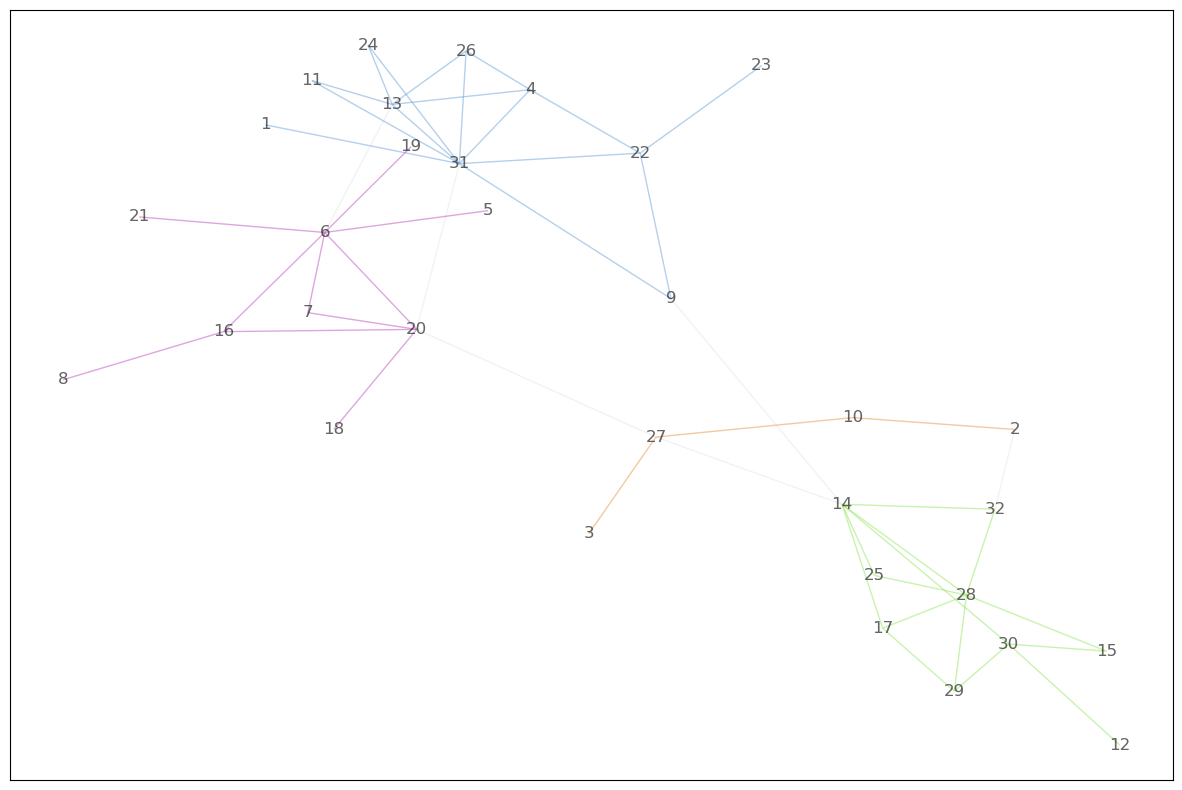

In [337]:
nx.draw_networkx(G, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=True)
nx.draw_networkx(G, pos=pos, node_size=0, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=True)
plt.show()

In [338]:
greedy_permanence

{1: {'1': 0,
  '31': 0.13888888888888884,
  '4': 0.6666666666666666,
  '9': 0.6666666666666666,
  '13': 0.33333333333333337,
  '22': 0.3333333333333333,
  '24': 1.0,
  '26': 1.0,
  '11': 1.0,
  '23': 0},
 3: {'6': -0.009523809523809601,
  '5': 0,
  '16': 0.3333333333333333,
  '19': 0,
  '21': 0,
  '7': 1.0,
  '20': -1.1102230246251565e-16,
  '8': 0,
  '18': 0},
 4: {'2': -0.5, '10': 0, '27': -0.5, '3': 0},
 2: {'32': 0.6666666666666666,
  '14': 0.014285714285714346,
  '28': 0.26666666666666666,
  '17': 0.6666666666666666,
  '25': 1.0,
  '30': 0,
  '12': 0,
  '15': 0,
  '29': 0.3333333333333333}}

# Asyn lpa communities

In [339]:
start_time = datetime.now()
lpa_communities = sorted(networkx.algorithms.community.asyn_lpa_communities(G), key=len, reverse=True)
end_time = datetime.now()

In [340]:
print(f"The total number of Asyn Lpa communities in the network = {len(lpa_communities)}.\n")

The total number of Asyn Lpa communities in the network = 5.



In [341]:
set_node_community(G, lpa_communities)
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(G)

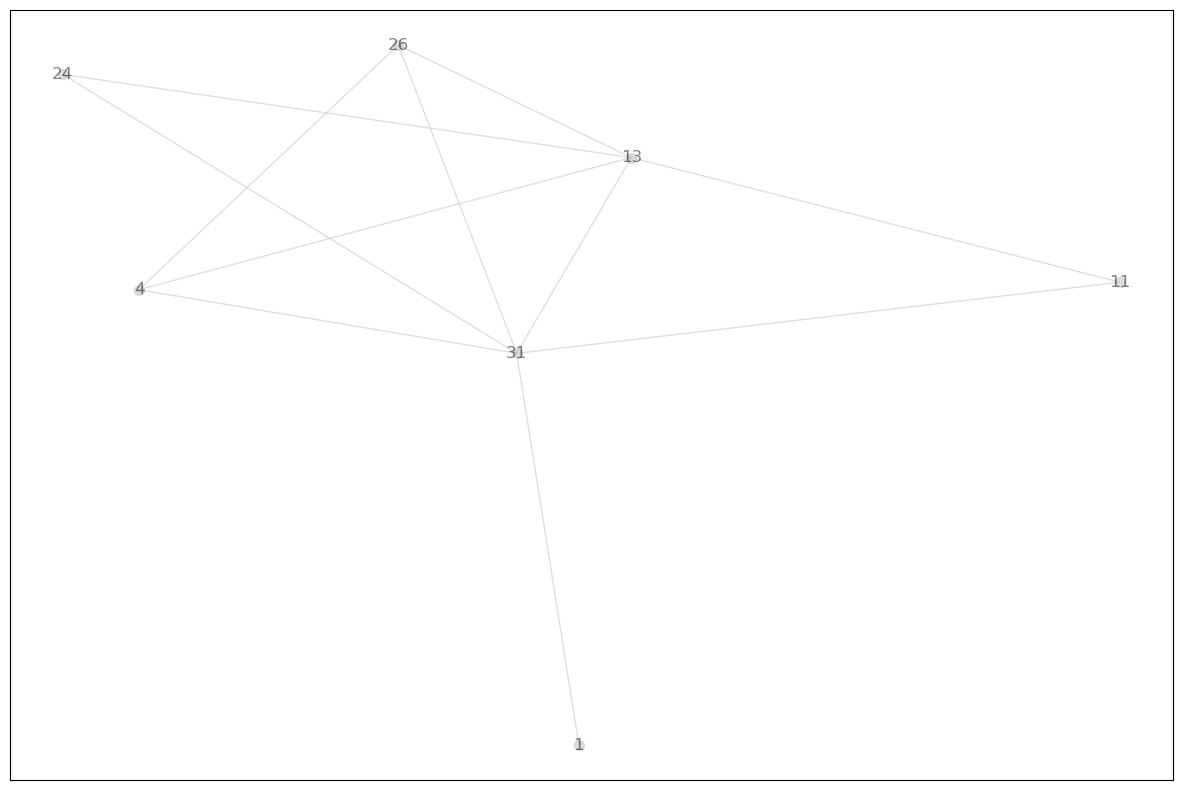

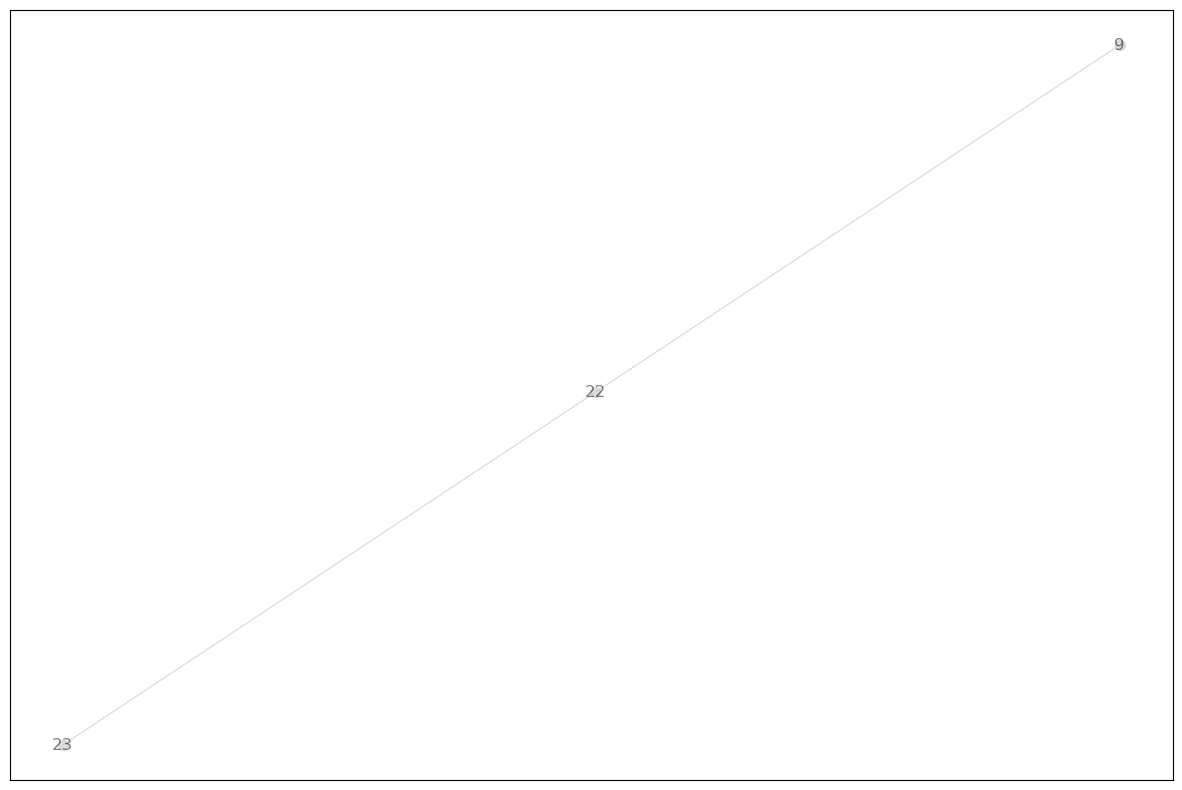

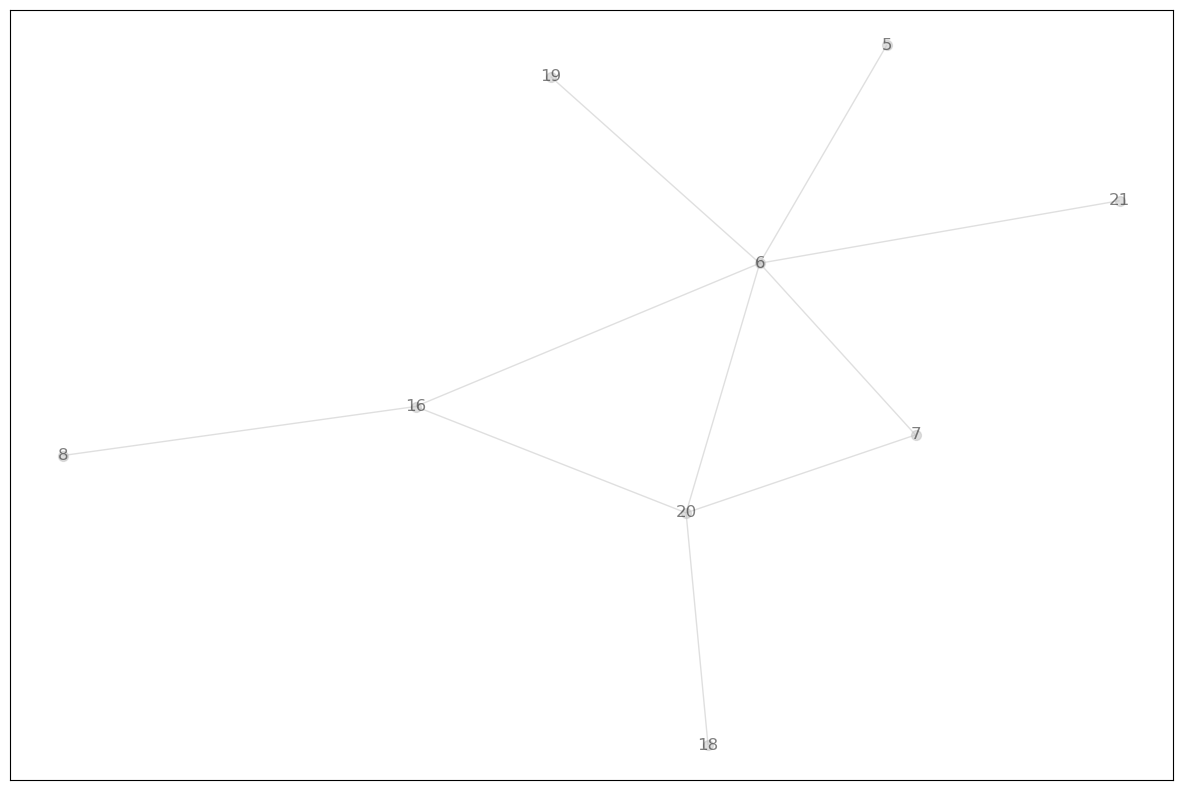

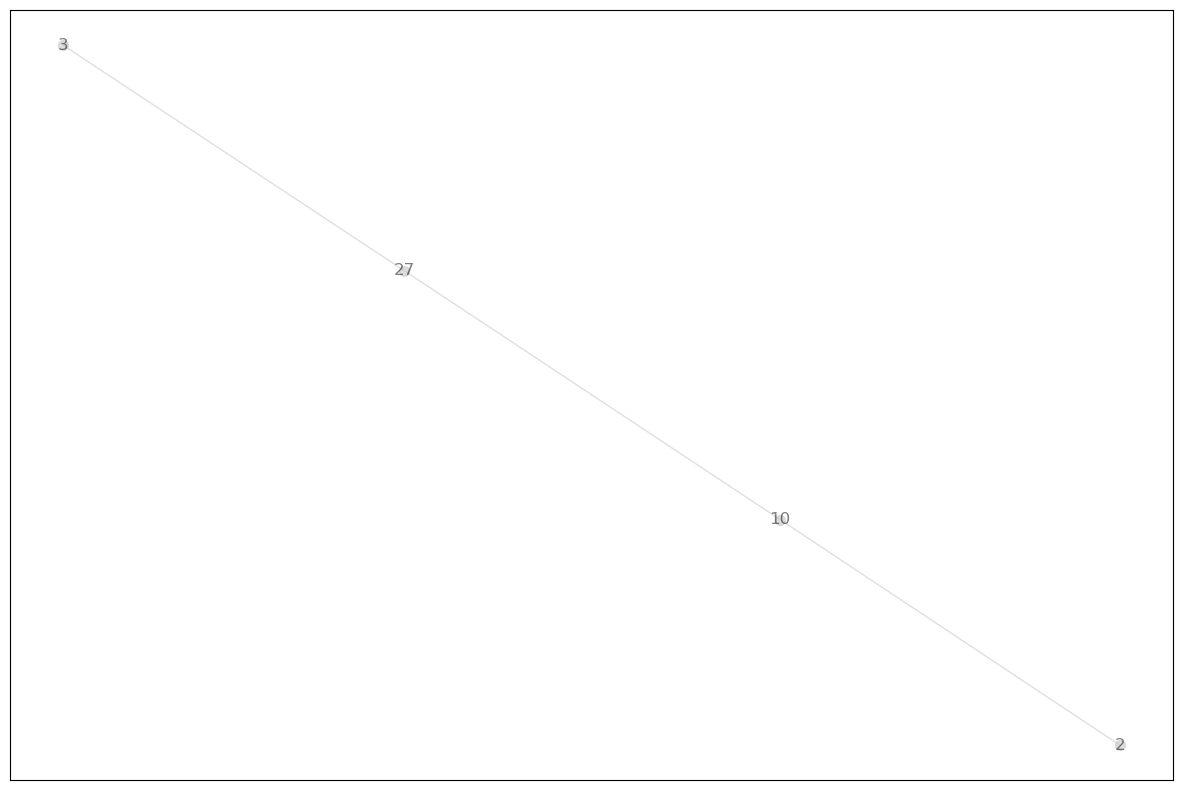

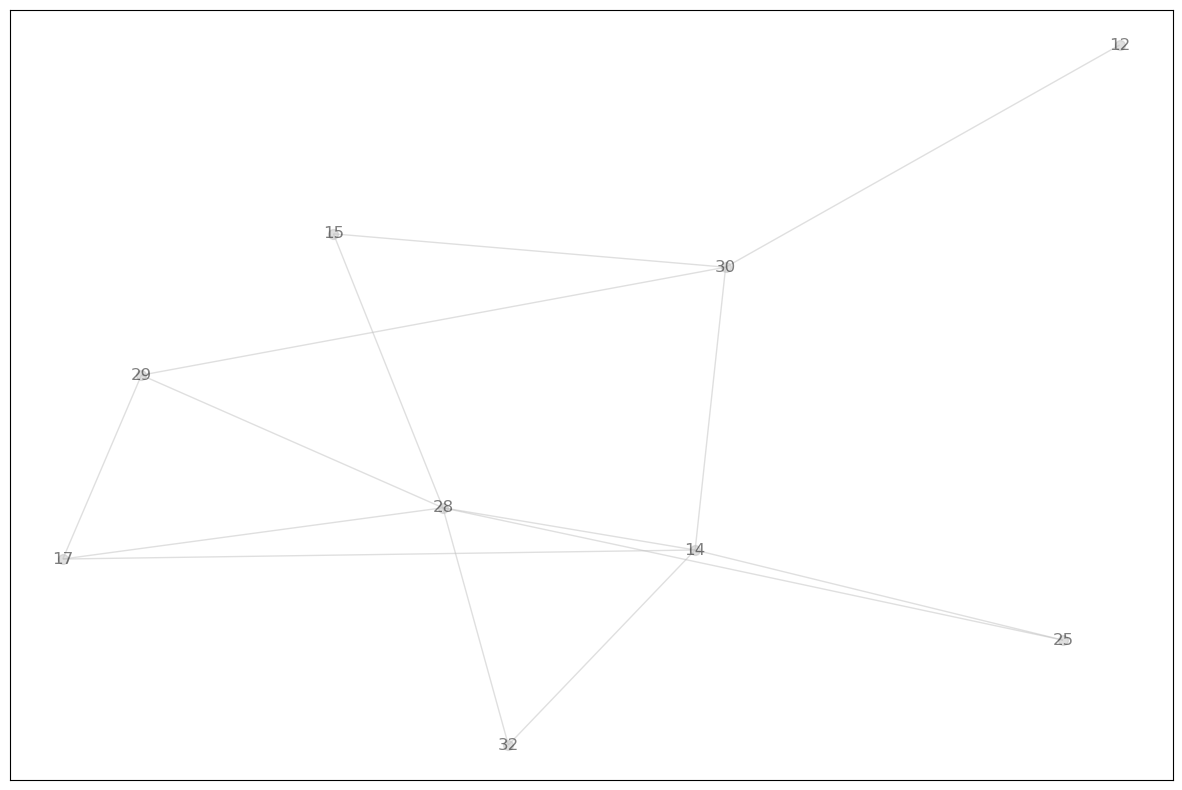

In [342]:
lpa_external_edges = findExternalMax(node_edges_external)
lpa_coefficient = getCoefficient(inner_edges)

In [343]:
lpa_permanence = calculatePermanence(node_edges_internal, lpa_external_edges, degree_list, lpa_coefficient)

In [344]:
external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]

In [345]:
node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]
internal_color = [get_color(G.edges[e]['community']) for e in internal]

In [346]:
print("Community \tNo of Nodes \tNo of Internal Edges \tNo of External Edges \t Density \t Hub Dominance")
for i,c in enumerate(lpa_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>=1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1)
    print(f"{i+1} \t\t{len(c)} \t\t {edge_list[i+1][0]} \t\t\t{edge_list[i+1][1]}\t\t\t{d:.3f} \t\t\t {h:.3f}")
print(f"Time taken by algorithm {end_time-start_time}\n")

Community 	No of Nodes 	No of Internal Edges 	No of External Edges 	 Density 	 Hub Dominance
1 		9 		 15 			3			0.417 			 1.000
2 		9 		 10 			3			0.278 			 0.875
3 		7 		 11 			5			0.524 			 1.500
4 		4 		 3 			3			0.500 			 1.333
5 		3 		 2 			4			0.667 			 2.000
Time taken by algorithm 0:00:00.002394



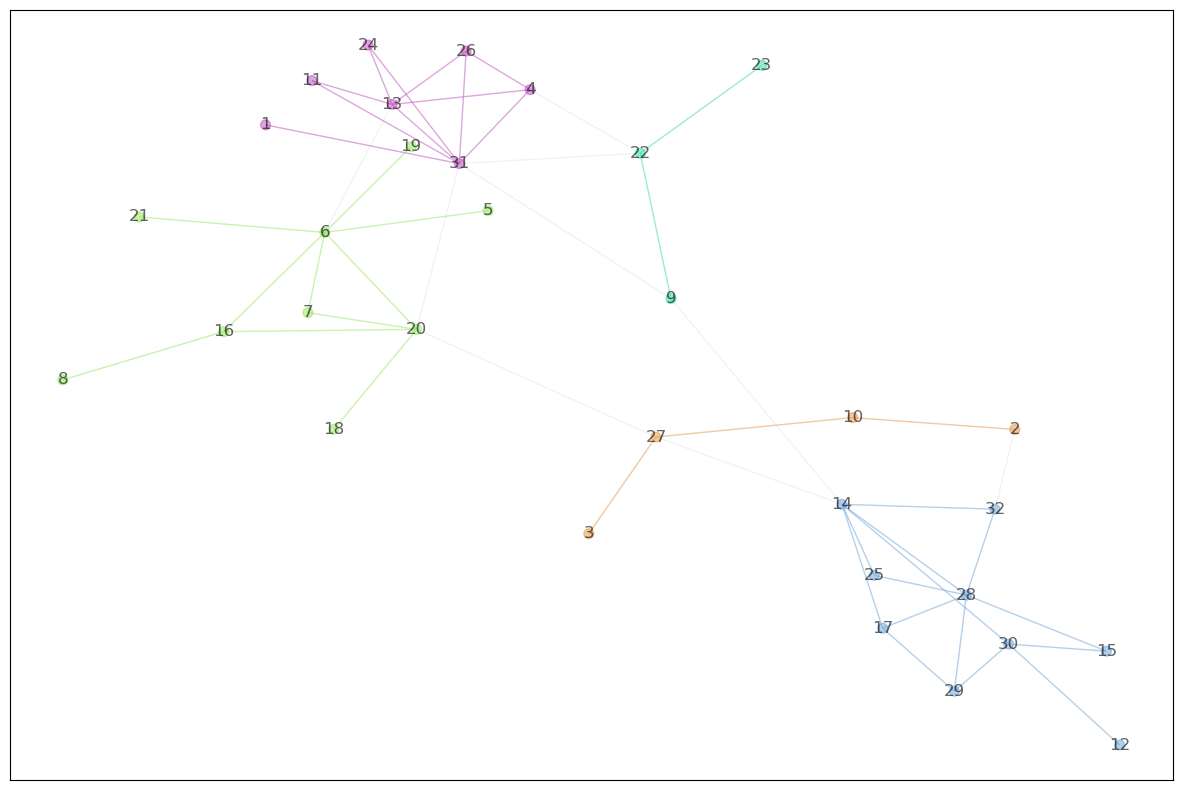

In [347]:
nx.draw_networkx(G, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=True)
nx.draw_networkx(G, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=True)
plt.show()

# Finding Constant communties

In [348]:
def constant_communuty(*communities):
    if len(communities)>1:
        community = communities[0]
        for k in communities[1:]:
            ls = []
            for i in community:
                for j in k:data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABJ4AAAMWCAYAAACwV0zRAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAPYQAAD2EBqD+naQAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+j8jraAAAgAElEQVR4nOzdeYycd37f+fdTz1P3XV19d/NQ85AoSqLue6TRPZ5RZmyPs8h6Y8wkhuPExq6dbJLZRYDAcQInGSPIII4XCDIBFrtwvHY0hy2PxJE0ukYSSUkURXEoiRIlkc2+qrqq676f59k/SmyJoig2ye6u7ubn9Q+BZh3faha7qz71/X5/huu6LiIiIiIiIiIiIsvM0+sCRERERERERERkY1LwJCIiIiIiIiIiK0LBk4iIiIiIiIiIrAgFTyIiIiIiIiIisiIUPImIiIiIiIiIyIpQ8CQiIiIiIiIiIitCwZOIiIiIiIiIiKwIBU8iIiIiIiIiIrIirKVcyHEcpqeniUajGIax0jWJiIiIiIiIiMga5rou5XKZkZERPJ5z9zUtKXianp5mfHx82YoTEREREREREZH1b3JykrGxsXP+/ZKCp2g0unhjsVhseSoTEREREREREZF1qVQqMT4+vpgZncuSgqfT43WxWEzBk4iIiIiIiIiIAJx3JZOWi4uIiIiIiIiIyIpQ8CQiIiIiIiIiIitCwZOIiIiIiIiIiKwIBU8iIiIiIiIiIrIiFDyJiIiIiIiIiMiKUPAkIiIiIiIiIiIrQsGTiIiIiIiIiIisCAVPIiIiIiIiIiKyIhQ8iYiIiIiIiIjIilDwJCIiIiIiIiIiK0LBk4iIiIiIiIiIrAgFTyIiIiIiIiIisiIUPImIiIiIiIiIyIpQ8CQiIiIiIiIiIitCwZOIiIiIiIiIiKwIBU8iIiIiIiIiIrIiFDyJiIiIiIiIiMiKUPAkIiIiIiIiIiIrQsGTiIiIiIiIiIisCAVPIiIiIiIiIiKyIhQ8iYiIiIiIiIjIilDwJCIiIiIiIiIiK0LBk4iIiIiIiIiIrAgFTyIiIiIiIiIisiIUPImIiIiIiIiIyIqwel2AiIic7a233uKVV17hxIkTFAoFAoEA4+PjPProo0xMTHzudVzX5Y/+6I/46KOPuOOOO/jWt761ukWLiIiIiIh8hoInEZE16LnnnqNWq3HPPfcwMjJCuVzm6aef5t//u3/Pt3/522wb2AaAP+knvCmMx/Kwd+9ecrlcjysXERERERH5hIInEZE16Dd+4zeIx+NnfG17cjv//Pf/OX/xJ3/Bt+/5NrhgmAbBwSDGToPHH3+cv/t3/y7f//73e1S1iIiIiIjImbTjSURkDfps6FT5qEL2Z1linhg1T43wpjDhzWH8A37qmTp/+kd/yqbkJm699dYeVSwiIiIiInI2BU8iImucYzvMvTRHeaFM3s4zkBpY/DvTZ/JG/g1msjPcN3wfTtvpYaUiIiIiIiJnUvAkIrLG1SZr1GfrPHHsCdqdNl++/suLf7dQXuDp15/moTsfIlALUD1Z7WGlIiIiIiIiZ9KOJxGRNa6Zb/LkG0/y9szbPHzzw2we2gxAu9zmBy/8gP5EP3ftuYvayRrNfLPH1W4sF3K6YKfTYe/evezbt498Po9pmgwMDPDNb36TK6+8skePQERERESktxQ8iYiscX/19F+x7719PHjXg9yz5x4AqiervPzyyxzPH+c3v/Gb1Jt1as0a1Vq348m2barVKn6/H8vSj/qLda7TBb/777/L3/u1v8dE3wQ44Il4+G9/9d84MXmC++67j23bttFsNjlx4gSNRqPXD0NEREREpGcM13Xd812oVCoRj8cpFovEYrHVqEtERIDHHnuMx//H41zru5av3fc1TL8JgN20+Yv//he8NvMa/qQfFxe7YRPdEsUb8y5e/zd/8ze55ZZbelX+ulcsFs9a9L7w0QL/9Hf/KTFifOvub2EYBi+++yIvHH+Bf/LP/gk3feUmDMPoUcUiIiIiIqtjqVmRPgYXEVmjfvCDH7B3714e+foj3GTfRH2mTnA0iGEYmH6TO66/gy19W/Cn/Jg+E3+fn7FfGuNP/vRPuPrqq7n//vvZtGlTrx/GuvbZ0KmeqZN9OkvEjlAza0Q2RwA49PwhhsJDhN4LUdhcIHl1shflioiIiIisOQqeRETWoMcff5wnn3ySHTt2cP0N11M6VWLm2Az2IRt/ys+2zdsY2TpCpB2h0+gQiAbY9j9tIzoRBbqBye7du3v8KDYW13XJ7suyMLXAgrPA5oHurq1cKUepUWLHzh08cfAJjvz1EXxbfAwMDfDAAw9w77339rZwEREREZEeUvAkIrIGHTlyBIBjx47xx3/8x0B3mXh9tk6n3uFf/vK/BMC1Xfx9fgKDAQxT410rqZFtUPmo0j1d0P7kdMFipQjAWx+8RTgQ5v7t97P5/s28OfMmf/Znf4Zt29x///29LF1EREREpGcUPImIrEHf+c53PvfrTsehOlldPL2umWvSXGgSHg0z/+o8voSP//Jf/stqlnrZaOVb/GT/T3hn5h0evuVhNg9uplVs0Sw2wYWO3eFbX/kWwUKQ/v5+7v7Vu/mDP/gDnnzySQVPIiIiInLZ8vS6ABERWTqP5SG6NUr6xjTpG9MM3jWIgYG/348Vtci8nMFpO70uc0P68d4fs++9fdx7/b18afeXqE5WKRwp0D7eplVoEffGScfSYHTH8gzD4KqrrqJYLFIsFntdvoiIiIhITyh4EhFZx6yQRWgkRPXDKgO3D9Cpd5g/MM8SDiyVC/DYY4/x3GvPcdfVd/GlLV+idLxEu9LGn/Yzvn0cX8BHu9ymdLyE3bIJ9AUAFv8ddMqdiIiIiFyuFDyJiKxz0W1RmoUmTtuh/5Z+KpMVSsdKvS5rwzh9uuDDX32YR255hNKxEoZlENsWw/Sb+II+dl25i4pZYW5mjnaxTbvSxm7ZvP322/T19X3h8bIiIiIiIhuZgicRkXUuOBTEG/ZSPl4mPB4mvjNO/lCeRrbR69LWvdOnC05smWCkPsKJ/AkyvgyTC5N8MP0Bru1ieAweuP4BTMfksXcfY7J/kv0v7OcP/9EfMvn+JI8++mivH4aIiIiISM9oubiIyDpnGAbRiSgLv1ggtSdF6toUzVyTzMsZRh8exQyYvS5x3Tpy5AjtSptDzx7iTc+bBAeDuI5LbaZGp9rhn93+zzCDJtFklL//tb/Py/Mv8+zks7SbbeLE+cbV32BrYyutYgtf3NfrhyMiIiIisuoMdwmLQEqlEvF4nGKxqHEBEZE1qFPvMPlXk6T2pIjvjNOpd5h6cgpfwsfQPUMYHu0YulBO2yF3MEf5wzKRTRH6burD9HVDPNd2qU5VmfzrSYKDQZLXJIlsiWD6zwz5ajM1cq/n6NQ6xHfGSexK4PGq2VhERERE1r+lZkV69SsisgFYQYvwWJjy8TKu62IFLQbuHKCRabBwZKHX5a07zXyTqZ9OUZ2s0n9LP/239y+GTgCGaRDZFCE40A2d4jvjZ4VOAKHhEKNfGSWxK0HxWJFTT5yiOlnV8ncRERERuWxo1E5EZIOIbosy8+wMjWyD4EBwMRTJH84T6AsQGg31usQ1z3VdSu+WyB/O44v7GHpoCG/M+/mXtV0c28Hj++LPcDymh+TubkdU7o0ccy/NERoK0XdD3zlvW0Tki7z11lu88sornDhxgkKhQCAQYHx8nEcffZSJiYnFyz3xxBO89tpr5HI5ms0m0WiUzZs387WvfY3Nmzf38BGIiMjlRMGTiMgGERgI4I12l4wHB4IAxK+K08g1yO7PMvLwCN6wgo5z6dQ7ZPdnqc/WiV8ZJ3VNCsM894ii03EA8FhLax72RrwM3T1EdapK/mCeU0+eIn7lx+N3S7wNERGA5557jlqtxj333MPIyAjlcpmnn36a7373u/zO7/wO26++irLTYqaY48qrrmTzps2EQiGy2SxPPfUU3/3ud/nOd77D2NhYrx+KiIhcBrTjSURkAym+UyR/OM+mv7Vpcam43bSZ/uk0Hr+H4fuH8ZgKOT6rNl0juz+LYRikb00TGj5/d1i73GbybyYZ/vIwwcHgBd2f03Eovl2k8HYBK2iRuiFFeDR8seWLyGWmWCwSj8fP+Fqj0eCffOef006F2PkPfoWK08IABqwwN4QG2RMcwOcxmZyc5A//8A958MEH+bVf+7XePAAREdkQtONJROQyFNkaAQPKH5YXv2b6TQbuHKBVbJE/mO9hdWuPY3cXiM++MIs/5Wf0kdElhU7QXT4OXNSycI/lIXlNkrFHxvBGvcy9OMfsC7O0K+0Lvi0Rufx8NnQCKJkOp6Iuh7MnqTltYqafiMfHVLvMDwrH+GHhGA2ns3hd09SJpyIisjo0aicisoGYfpPIeITy+2XiV8YxjO6omD/lJ31DmuyrWfxpP9Gt0R5X2nutYovsK1lapRZ91/cR2xFb/H4txWLwdJ4dT1/EG/MyeM8gtVM1cm/kOPXEKRJXJYhfFVdnmogsWcd1+Mvpw0xOT7HtiisY9H7SQRkxfVTaTQ6UpnDmimR+up9wOMzdd9/dw4pFRORyouBJRGSDiW6LUv6oTH22fkb3TuSKCI35BrnXcviTfnwJXw+r7B3XdSl/UCZ/MI8Vthh5cAR/0n/Bt+O0Lr7j6dMMwyA8HiY4FKRwtEDhaIHKRxX6bugjNKKF8CJyfh82izz+3/+SYMfguoe+dNbf/9X/+cdU2k1+bhjcPbaTf/yP/zH9/f09qFRERC5H+jhVRGSD8fd1Q6Xy8fIZXzcMg74b+7CiFnMvzWG37B5V2Dt20ybzcob5V+eJbIkw8tDFhU7wqY6nZVoM7vF6SF2XYvSRUayQxewLs8z9fI5OtbMsty8iG9f//f/9GdNvvcuNv3Qf/Vs3AeB8ao3rg//oN/jq73ybbd+4j4YF//E//kdOnDjRq3JFROQyo+BJRGSDMQyD2ESM2lSNTu3M0MJjeRi8cxC7YTN/YJ4lnC+xYdQzdab2TtGYazB45yDpm9OXFBo5LQeP5fnCk+8uhi/mY+jLQwzcPkAz1+TUT05ROFrAtS+ffysRWbrHHnuMV599kYn7bmP3/Xfiui4z7QpHG/PYbjcg7986zuj2rYzddh3/y//2D3Echx/+8Ic9rlxERC4XCp5ERDagyJYIhmlQ/qB81t95o176b+2neqpK6d1SD6pbXa7jsvDWArPPzmKFLUYfHiU8fuknyDkd55LH7M7FMAwimyOM/dIY0e1RFt5aYGrvFPXZ+orcn4isT4899hh79+7ljgfuZdsjd9G0O7zXXGCmXSFlBfHwSTDecmxMDPoicfr7+8lmsz2sXERELicKnkRENiCP10Nkc4Ty8TKuc3anTHgsTOLKBPk38zSyjR5UuDra1TYzP5uhcLRAYneC4S8PY4WXZ72h01q54Ok0j9dD354+Rh8exeP3MPPcDJmXMmd1sonI5ecHP/gBe/fu5YEHHuA3//avY7sub9YzNF2bHf4UI97IGQcmZDs1hr0RUk2Ym5ujr6+vh9WLiMjlRMvFRUQ2qOhElNLxErWZGuHRszt8ktcmaeQaZF7OMPLQCFZwY/1KqJyoMP/aPKbPZPj+YQLpwLLevtN2LulEuwvhS/gYvm+Y6okq+UN5Tv3kFMndSWLbY8s+6icia9/jjz/Ok08+yY4dO7j6umt49sjrzJdPULTb7PQniezsp1mt8dT/9f+w6bpdGKkIdQv6q0H+w/7H6HQ6fP3rX+/1wxARkcvExnqXISIii/wpP/6Un/L75c8NngyPwcAdA0zvnSb7Spahe4cwPOs/xHDaDrmDOcoflolsitB3Ux+mz1yR+1npjqdPMwyDyJYIwZEghbcK5N/MU/6wTN+NfQQHgqtWh4j03pEjRwA4/M5RnnzrAG3Xoc8KUrIb7LUbfOXf/e/4DQOjP87rr+zHLtcYNIJ8lBpiYmKC3/7t32Z8fLzHj0JERC4XhruEzbKlUol4PE6xWCQWi61GXSIisgzKH5SZf3Wesa+N4Q17P/cy9Uyd2WdniV8VJ3VtapUrXF7NfJPMKxnsuk3fjX3dXVfGyoRpMz+bwQyYDNwxsCK3fz7NhSa513M05htENkdI7UltuK41Efl8ruvyVmOeV6szJKwA90c2kbACtF2b95oFDtcyzLarGIbBNn+C3cF+NnmjK/bzUERELk9LzYr0ClVEZAMLj4fJvZGjfLx8zlApOBAkeW2S/Jt5/H3+z+2OWutc16X0bon84Ty+hI+hu4fwxj4/aFsuTtvBG13Z+/gi/qSf4fuHqXxYIf/mx+N31ySJbYttiM41Efl8NafN8+VJJttlrgn2c3NoCMvodl96DZNdgT52BbS/SURE1g4FTyIiG5jH6yG6JUrlgwrJq5Pn3AcUvzJOc75Jdl8W38M+vJHeBSoXqlPvkN2fpT5bJ3FlguQ1536cy8lprd6Op3MxDIPoFVFCoyEWDi+QfyNP5YMKfTf1LftOKxHpvclWiecqkwB8JbaVcZ8mEUREZO1T8CQi61KtVuNHP/oRU1NTTE1NUavVeOihh/jmN795xuXefvttXnrpJU6dOsXc3By2bfOv//W/ZmCgN+NRvRCdiFJ8r0h1qkpkU+RzL2MYBulb00z/dJrMSxmGHxjGY679g09r0zWy+7MYhsHQPUOEhkOrdt9OZ3V3PH0R02+SvjlNdCLK/GvzTD89TXRrlNR1KczA8u+3EpHV1XEdXq3N8lY9y7g3yj3RcUKe9fMBgYiIXN7WxitmEZELVKlU2LdvH+12m927d5/zckePHuXYsWMkk0k2b968ihWuHb6Ej0B/gPL75S+8nOkzGbhzgFapRe713CpVd3Ecu7tAfPaFWfx9fkYfGV3V0Ml13W7H0xoJnk7zp/yMPDBC+qY0takak38zSem9Eq5z3nWOIrJGFToN/qr4Pkfr89weHuGR2FaFTiIisq6o40lE1qX+/n6+973vYRgGpVKJAwcO4Nou5eNlCu8UaGQaGKbB7Ztu5yu//xWCQ0H+5m/+hg8++KDXpfdEbFuMzCsZWqUWvpjvnJfzJ/2kb0yTPZAl0B8gujW6ilUuTavYIvtKlla5Rd8NfcS2x1Z9Ya7bcXFdt+ejdp/H8BjEtsUIj4XJH84z//o85Q/LpG9M4+/z97o8EVki13V5t5nn5eo0EY+Xrye2kbZWL2AXERFZLgqeRGRd+mzQ4HQccm/kODF5Atd1MYMmuFDbV6NwuED6lvRl3fURGgth+k3Kx8v0Xf/FS2ejV0RpzDeYf20eX8KHP7k2wgrXdSl/UCZ/MI8Vthh9cBRf4twh2kpyOg4AHmvtBU+nmQGT/lv6iV4RJfdarjt+d0WU5LVJTL/G70TWsobT4cXKKT5sFbkqkOK28AheQ/9vRURkfVLwJCLrnuu61GfqVJtVfDt9Zxwp76Zd2sU2mZ9nqAQqPayytzymh8jWSHfJ+DXJ8wYmfTf00cq3yLyUYeShEUxfb9/w2E2b+VfnqZ6qEpuIkbo+1dPQx2l9HDytwY6nzwqkA4w8NEL5/TL5t/JUT1VJXZsickVER6uLrEEz7QrPlk/Sdh0eiG7mCn+i1yWJiIhckrX/illE5Dwa2QatYgsrZp0ROkG3M8qX8GFYBuXj5cu66yl2RQy7ZVOdrJ73sh7Lw8BdA93AZ/88rtu771s9U2fqySkamQaDdw6Svjnd804jp/1x8LTGdjydi+ExiO2IMfZLY4SGQ2RfzTLz9AzNfLPXpYnIxxzX5bXaLI8XjxM1ffxqYodCJxER2RDWxytmEZEvUDlRwe24Z48PfSor8aV8tIotOtXO6ha3hnhjXoKDQcrHv3jJ+OLlI176b+unOlWl9G5phas7m+u45A/nmX12Fm/Uy+jDo4THw6tex+dZTx1Pn2YFLfpv62f4vmGcjsP0U9PMvz6P3bR7XZrIZa1st/jr4vscqmW4MTTEV2MTRMzejBKLiIgsN43aici6Z9dsMMDgk7GhTq1D/o08wcEggf4AVsQCB1z78u14gu6S8bmX5mgVWkvajxQeDZO4KkH+zTy+lI/gQHAVqoR2tU32lSzNXJPE7gSJqxIYnrUzFrbeOp4+KzgQZPShUUrvlVg4skD1ZJXUnhSRLRq/E1ltx5sL/Lwyhc8weTQ+waB3bQTsIiIiy0XBk4isex6f54zuJuh2y1ghi+pUlfpsHSts0Sq16LQ6tKvt3hS6BoRGQlgBi9L7JdI3pZd0neQ1SZq5JtmXs4w8PHLWOONyq5yoMP/aPKbPZPj+YQLpwIre38Vw2g6GYWBY6zekMUyD+JVxwpvD5A/lye7PUj5eJn1TumdL20UuJ23X5uXKNO8280z4E9wVHsPv0QJxERHZeNbnR7UiIp8SGgmB55OTxqA7JpbakyJ1XQpf0ke70saxHTqVDlM/neLUT06RP5SnnqlfVnufDNMgckWEyonKYtfOea/jMei/vR8MyLycWbHvl9N2yO7PknklQ2gkxMjDI2sydILuqJ3H69kQ3UFW0GLg9gGGvzyM03KY2jtF7mBuyc8PgGeeeYbf+q3f4nd/93dXsFKRjSPbqfGDwnt80Cpwb2Sc+yKbFDqJiMiGpY4nEVm3Dh48SLPZpF7rdjRNT05z8J2DGB6DXVt24ff5aXgbvOe8R61co+QtYVgGH1Q/YP7UPN73vUwMTGD6TILDQUIjIYJDwQ1/1HxsIkbx7SLVk1WiE9ElXccKWvTf3s/ss7MsHF4gtSe1rDU1800yr2Sw6zb9t/av+ZEvp+Os2zG7cwkOBhl9eJTisSKFI4Xu+N31KcKbwl/4b5HL5fjxj39MNBql2dSycpEv4roubzWyvFqdJWUFeDixg4Tp73VZIiIiK0rBk4isW3/+539OoVAAuruIPjz5Ie/95D0Mr8Hv/+3fJx1N89G7H/GXz/8lvoSP4HAQr+3lx3/zYwyvwc49O7n7f76b+kyd2nSNzIkMhmHgT/sJjYQIjYTwxrxrOgC5GFbYIjgcpHS8tOTgCbp7gVLXpcgdyuFP+wmPXfoeEtd1Kb5TZOGtBXwJH0N3D+GNeS/5dlfa6Y6njcYwDRJXJYhsipA7lCPzSobg8SB9N/bhi3fH71zXpTnfpHisSHWyyn/96/9KKpoiNZTi2NSxHj8CkbWr6rR5vjzJqXaZ64L93BQawjQ23s8RERGRzzLcJZyRXSqViMfjFItFYrHYatQlInLBWsUWC0cWKL5d7J5eZ4C/z0/y6iTxXXFMX7eTqVVokTuUoz5b74Ype1L4U346tQ61mRq16RqN2QaO7eANe7udUCNBAgMBPObGeJNQm6ox++Isow+N4k8t/dN213XJvJShPldn9KFRvNGLD4k69Q7Z/Vnqs3USVyZIXpPEMNdHyHe6O2v4vuFel7KiajM1cgdzdCod4jvjxHfFWTi8QHZflnalzaHpQ+w9tJd/cM8/4Jl3nuFE4wTf/x/f3/BdgyIX6kSrxPPlSTwG3BvZxJhv6aG/iIjIWrXUrEgdTyKyYfjiPgbvHCR9U5pOpRs8eePes8IiX8LH0D1D1Gfq5A/lmX5qmsiWCMlrksQmYsQmYjgdh0amQW2mRnWqSvG9Ih7LQ3Do45G84eCKL9leScHhIFaou2S8/5b+JV/PMAzSt6SZ/uk0mZcyDD8wjMe68DCuNlUjeyCLYRgM3ztMcGh1TstbLk57Y3Y8fVZoOETgkQDFd4oUjhbI7s/SyDbwJX3YaZtnX3iWh+56iLGrxzBPmjRONZh7YY7hB4Y3XKegyMXouA4HqjMcacyzyRfjnsgYQc/a7+oUERFZTuv3XZOIyDmYfvO8HReGYSzudCofLy8eKR+/Kk58ZxyP17M4bufe4NIutqlNd7uh5l+dx3Vd/KlPRvJ8Sd+6eqNteAyiE1GKR4uk9qQWu8GWwvSZDN41yPRT0+Rez9F/69KDK8d2WDi0QPG9IqGREP239GMG1l93jNNy8EYujzePHtND8uokobEQ7/znd6hn6xiWwQ9f+SGpaIq7rrkL6D4vzIBJ4Z0CqetTa3YxvMhqWeg0eKZ8gqLT5I7wCFcH0uvq94SIiMhyUfAkIpc1w2MQ2x4jvDlM8Wi3q6N8vEzy2uTigmvDMPAlfPgSPhK7EthNe3EvVPHdIgtHFrCC1icLygeD66IbJnpFtLtE+qMqsR0XNkbtS/jou6mP7P4sgf4A0SvOPzbSKrbIvJKhXW7Td0Mfse2xdfsm7HLpePq0dqGN6TOJ74jz6huvcvTto/zDR/8hOMDH2aHH56FT7VD+oKzgSS5bruvydjPPvuo0UY+Pb8S302etr65OERGR5aTgSUSEbrdGak+K6LYoC28ukN2fpXSsROr6FMGBM98wmH6TyJYIkS0RXNulkWtQm65Rn65T/qCMYRoE+z8OoUaDeMNrszPGClqExkLdJePboxccAkW3RmnON5l/fR5f0oc/+fm7olzXpXy8TP6NPFbYYvTBUXwJ33I8hJ5xWg4e38YOnlzHxW7Y2HWbTq1D8d0izXwTN+zy1NtPce3Qtdjv28yH5gn2BbFtG4B6u04lX6GfpXfCiWwUDafDi5VTfNgqclWgj9vDI1haIC4iIpc5LRcXEfkcjfkGuYM5mvkm4dEwqetSSzptrV3+ZCSvkW3gOi6+uG9xJM/f58fwrJ0un/psnZnnZhi5f4RA/4V3qDi2w8zTMzgth5GHR84a2bObNvOvzlM9VSU2ESN1feqidkKtNR899lF3af2V8V6XclGcjtMNlOod7Npn/vw4aLIbNp9+idBaaHVPsvNX+dNn/xSn5eB0HKyY1e3+MsBjeOhUOuy5fQ//4nv/ooePUGT1TbcrPFs+Scd1uCcyzhb/+vz5ICIislRaLi4icgkC6QAjD45QPVkl/2aeU0+cIrY9RuLqxBfuj/JGvd3Tv3bGcdoO9dnuSF75gzKFtwuYPvOTkbyhYM9P/woMBvBGvJTeL11U8OQxPQzcOcDU3imy+7MM3jW42DlVz9TJvpLFtV0G7xwkPB5e7vJ7wnXcNTtq57ouTstZDI/OCJJqNp1G90+7ZZ9xPY/XgxW0MEMm3piXwGAAK2R1vxY0sUIWdsfmg//3AwLNAL/+pXiIDNwAACAASURBVF+nXWwTHApiRS1cx+W5N55jcnaSv3Pn32HnL+/s0XdAZPXZrsPrtTnerGcY9ka4NzJOxFzfXZ0iIiLLScGTiMg5GIZBZHOE0GiI0rEShaMFKh9VSFydILYthmF+ceeSx+shPB4mPB7GdV2auebiSF7mRAbDMAj0B7oh1EgQb9S76juPDMMgti1G/nAe+wb7ooIwb8TLwG0DzL44S/HtIvGdcRZ+sUDx7SKB/gD9t/VjhTbOrxun7QCs+qjd6dG3Tq1zdrfSp4Im1/6kS8kwjO6y/ZCJFbQIpLuB0ukwyQx2v76UEM3EJH5lnKknpxi3xgnvCeNPfTJeefDYQdymy9V7rmbk2hFarRZe7+o/p0VWU8lu8rPySeY7dW4KDXFdcACPnvMiIiJn2DjvBEREVojH8pDYlSCyNULhSIH8oTyl90ukrksRGg0t6Y21YRgE0oHuwuVroVPrUJvpjuQtvLVA7lAOb8S7OJIX6A+cN9haLpGtEfKH81Q+rFz06FhoNERiV4L51+cpvFPAbbskr+mOoq2l0cLl4HQ+Dp6WsePJaX9q9O3zupXq9lmjb4ZpYAW6XUpWyMKX8mEFrTMCJTNgLuvzyBv1YgZM3E6368tu2GBAp9qhmW9ihSw2PbIJT8BDs9mk3W7j9/uxLL3ckI3n/eYCP6+cIuCxeDQ+waB3Y3R1ioiILDe9EhQRWSIraJG+OU1se4zcoRxzP58jOBAktSd1RufHkm4rZBGbiBGbiOF0HBqZ7oLy6qkqxWNFPJaH4NDHI3nDQazgyv24Nv0m4fEwpeMlYjsv/qQ5b9RLfaaO23GZ+I0JwmMb802Y01p68HR69O2zo26f7lrq1DqLXVSnebyexVE3X9yHNfxxwPSpoMnj86xqN1HxnSKl90ps+sYm3I7LwpEFWoUWuN3n8+/83u+QvCa5+H/B6/XSbDap1+uYpkkgEMDjWXvjiSIXquXYvFSd4r3mAtv9Se4Mj+Lz9HZsWkREZC1T8CQicoF8CR9D9wxRn6mTP5Rn+qlpIlsiJK9NXlRA5LE8i51OruvSLn6yoHz+1Xlc18Wf8i9expf0LXvgENsWY/qZaRpzDYJDF3bst9N2yB3MUf6wTPrWNM35JsV3i4SGQ6vWtbWaTodEhmnQqXbO3aX0cdB01uhbwFzsSAoMBM7uUgqaa25/VOm9ErlDORK7EqSuTQGQui5Fc6EJbjd0/Ow4pWmahEIhOp0OzWaTarWK1+vF7/dr/E7WrUy7xrOVE9ScDl+ObGJ7INnrkkRERNY8BU8iIhfBMIzFBeHl42UWjixQPVklflV3sfjFBgeGYeBL+PAlfCR2JbAbNrWZ7l6o4rtFFo4sYAWtxb1QwcHgspwS50/78cV9lI6XLih4auabZF7OYDds+m/tJ7IlQnO+yczPZsi/ladvT98l19YLTts5a9Tt9E6l2nSN4jtF3I6LYX0SoBimsRgiWSGLQF9gcbfS4k6lgLnuRg/LH5aZf32e+I44yWs+eZPt8XoIDpz/uWJZFqZp0m63abVadDodfD6f9j/JuuK6Lm/Ws7xWmyVtBXkkcQVx88I6XUVERC5XCp5ERC6B4TGIbY8R3hymeLRI4WiB8vEyyWuTRLZELvmNtRkwiW6NEt0axbVdGvONxW6o0vEShmkQHAh+sqA87F3S7dZqNX70ox8xNTXF1NQUtVqNu3bfxd2Dd9OpdxY7t5544glee+01crkczWaTaDTK5s2b+epXv0qinmDh8AK+ZLcDzBvt3negP0DquhS5QzkCfYE1dZqd67o4TeesUbfPLuv+7Oib6TPPGHXzpXykb0njjXgXu5VWe/RtNVROVJg/ME9sIkbq+tRFPz7DMPD5fFiWRavV0v4nWVcqdovnKpPMtCtcFxzgxtAgprG2uhJFRETWMr3aExFZBqbPJLUnRXRblIU3F8juz1I6ViJ1fWpJXSFLYZgGwcFul1Pf9X20S5+M5OUO5nBfd/ElfIsjef6U/5zdNZVKhX379jE0NMTu3bs5cOAAgYEAhseg9H6J6NYoOFAultm1axfj4+OEQiGy2Sx7f7KXP/i9P+C3Hvotdt65k+Tu5FkjdbGdMRq5BtkDWXxxH97Y0gKxS+HabneH0mdG3T67U8l1zjH6FrLwDfo+6U76VLfSp7vKiseK2A2b+I6LW8S+XlSnqmT3ZQlvCtN3U9+yhGoej4dAIHDG/ifLsvD7/dr/JGvSR80iL1ROYRoGvxS7glFftNcliYiIrDsKnkRElpE34mXgzgFi2Ri5N3LM/GyG8FiY1HWpxY6gZbuvmJd4LE78yjh2y6Y+W6c+U6d8vEzhaAHTbxIa/ngkbyiI6ftk+W1/fz/f+973MAyDUqnEgQMHusGCB07+6GR3jxQG10euJzmRJH5VHG/ES22qRuD9AP/pzf/Ece9xbr/u9s+tzTAM+m/pZ+qnU8y9PMfIAyOXNBK4OPpW+5yT32p299S35pmnvnlMz2J4ZIUtAv2BxT1Kp7uULmb0zWk5mN6NvUi4NlMj81KG0FiI/lv7l72T6/T+p3a7vbj/yefz4fMt//4ykYvRcR32Vac52six2Rfjnsg4AY9eNouIiFwM/QYVEVkBgf4AIw+OUD1ZJf9mnlNPnCK2PUZiVwLTv/yhhekziWyKENkUwXVcmvkmtenubqjyR2UMwyDQH1jshvpsB5LruOQP5ymGijSzTbwRL2bMpFVqMf3MNIV3C0TGI9RmaqTH0oTHw4T6Ql9Yk8frYfDOQaafmib3eo70LemzQgXXdbEb9lmjbp/drXTW6Jv/kwXd/pT/k8Xcn+5SWqHRN6fjYHg3bjhSz9TJ/DxDcDDIwG0DK7qTyuv1Lo7ftVqtxfE7r3flO+REziXfqfOz8kmKTpO7wqNcFViejj8REZHLlYInEZEVYhgGkc0RQqMhSsdKFI4WqHxYIbE7QWwitmInvhkeg0A6QCAdgGuhU+1Qm+mO5OXfypM7lMMb8X5ykp6/uzuq0qgQvC8ILtgtm2C4uzOqXW2TfS1L7p0c0Qei/PTQT4nEItx9991fWIdruxheg8hEhPkD87Qrbfwp/5nh0jlG306Puvninxp9C37+6Ntqc1rOmjt1brk0c03mXpzD3+dn4M6BVTmV0DCMxbCp2WzSaDRotVoEAgFMc2N3lsna4rouRxs59tWmiXv8/HJ8OylreUalRURELmcKnkREVpjH8pDYlSCyNULhSIH8G3lK75VI7UkRGgmt+CfpVtgiti1GbFsMp+PQmOsuKK9OVikeK1Kul6mdqsGObueUL+WjPl3Hbtl0Kh3qM3X+w8//A67HJfpBlOEtw/ze//p7xH1xajM17Mandip9ulupaS/W0Kl2mHthjsTuBIG+AN6Il0B/4MwupZCJ6V/7p745bQePb+MFT61Ci9nnZ/HFfQzePbjq4Z7H4yEYDGLbNo1Gg1qtpv1PsmoaTofnK5OcaJW4OpDm1vAwlhaIi4iILAsFTyIiq8QKWqRvThPb3t3/NPfiHMGBIKnrU/iTq3Mst8fyEBoNERoN4bourUKLD5//EKflYNdtiu8UMQMm7Vqb/KE8BgZWxOLb93+barZKPVrnjfff4F/97r/iW1/5FqPpUaA7+nY6PPKn/IRGQ2d0KRl+g7kX5nBbLgN3DqzIuOFqcVrOGfuyNoJWqcXMszNYYYvBLw32tKPLNE3C4bD2P8mqmWqVea4yie26PBzbwmbfxj44QEREZLUpeBIRWWW+hI+he4eoz9TJH8oz/dNpIlsiJK9NYgVX78eyYRj4k37Co2HMgElovBtItcvtbiiVb+FL+DBMg9H4KG3axHfGefBbD/Jv/uTfsG9hH7/3rd/rjr6Z5w8qBu8aZHrvNNn9WQbvHly3IYLTdrDCG+fXZ7vSZvbZWcyAydC9Q2smVNP+J1lptuvwem2ON+sZRrwR7o1uIuzR80tERGS5bZxXziIi64hhGIRGQgQHg5Q/KLNwZIHqZJX4ld1T6lZzzMkMmODp7jfxJX14416sfovmTBO7ZhNIB/ClfFRPVIlfFWfg+gFGJkYoVAt4I0t/k+YNe+m/tZ/ZF2cpvl0ksSuxgo9q5WykUbtOtcPss7MYltENndZYJ9rn7X86HUBp/5NciqLd5GflE+Q6DW4JDXNtcPlPbxQREZEuBU8iIj1kmAax7THCm8MUjxYpHC1QPl4meW2SyJbIqrwRCo2EMAMmnUoHgI7dwWN6iG6N0phtUJup0S63MQMmkc0RSqUSc3NzbN68+cLvazREYleChbcW8Pf5CQ6uv8W9G2W5eKfeYea5GQCG7x1e1W67C3V6/1On06HZbFKr1fB6vfh8Pu1/kgviui7vNRd4qTpFyGPxt+LbGPB+8QmdIiIicmnW7qtMEZHLiOkzSe1JEZ2Ikj+cJ7s/u7iAPDiwMuHMwYMHF7tIAn0BsgtZ9r++HyNgcM3ENbSbbb7/8vfZkdhB8FiQxBUJJg9P8uKLL9LpdPj6179+Ufeb3J2kmWuSeTnD6MOjWKH19avI6az/4Mlu2sw+N4vbcRm+b3jdjA5aloVpmrTbbVqtFp1OB5/Ph9frVbeKnFfTsXmpeor3mwV2+JPcER7F51HnnIiIyEpbH680RUQuE96ol8E7B2lkG+TeyDHzsxnCY2FS16XwRpd398if//mfUygUAPCn/EzOTfLui+/i2i6jvzJKPBInQYI3jr9Bzajh5BziH8TZffdufvu3f5vx8fGLul/DYzBw+wBTe6fIvJxh+MvDGOb6CA0c28G13XUdPNktm9nnZ7EbNsP3DS/782qlGYaxGDY1m02azebi+J1l6WWNfL65dpVnKydpOB3ui25imz/Z65JEREQuG4bruu75LlQqlYjH4xSLRWKx2GrUJSJy2XNdl+qJKvk389hNm9j2GIldiRXbw9Nut1l4f4HmR03qp+q4jou/30/iqgTRiSjtYpu5F+e6S6jvGbrkLpnGfIOZZ2aI7YjRd33fMj2KldWpdzj545MM3j1IeDTc63IumNN2mH1+llaxxfB9w6t2muJKchyHRqOBbduYpqn9T3IGx3U5VM9wsDZHvxXky9FNxMz1/7wXERFZC5aaFemjQRGRNcowDCJbIoTGQhTfLVJ8u0jlwwqJ3QliE7Fl7RJyXZdWq0Vkc4SBqwZwXRcczrgPs99k+IFh5p6fY/rpaQa/NHhJwUUgHSC1J0XujRyBdIDw+NoPctx297Oa9djx5NgOcz+fo1VoMXTv0IYInaC7/ykUCp21/8nv92v87jJXsVs8V5lkpl1hT3CAG0NDePScEBERWXXr75WziMhlxmN5SF6dZOyrY4TGQuTfyDO1d4raVI0lNK0uSafTwXEc/P5uGGEYxucGW76Yj+EHhjGDJjM/m6E2U7uk+43tiBEZj5A9kKVdal/Sba0Gp+0A6y94cm2XzEsZmvNNBr80SCAd6HVJy86yLEKhEH6/n06nQ7VapdVqLdv/EVlfPmwWeaxwjKLd5KvxCW4ODyt0EhER6ZH19cpZROQyZgUt+m/pZ+ShEcygyeyLs8w+N0tzoXlJt+u6Ls1mc3Fx81LqGP7yMIF0gLkX5ih/WL7o+zYMg/QtaaygxdxLc4vBzlplt2wAPL718+vTdVwy+zLUZ+sM3DWwYsvq14LT+5/C4TCWZS12QHU6nV6XJquk4zq8WDnFU+WPGPFG+NXEDka8kV6XJSIicllbP6+cRUQEAH/Sz9C9QwzdPYRdt5n+6TTZA1k69Yt7c91ut3Fdd7HbaSk8Xg+Ddw8SvSJKdn+WhSMLF91Z4vF6GLhjgE6lQ+713JruUFlvHU+u6zJ/YJ7aqRoDdwwQGr48jo03DINAIEAoFMIwDOr1OvV6HcdZ28GmXJr5Tp0fFt7jveYCd0fGeCC6mYBHWyVERER6Tb+NRUTWIcMwCI2GCA4FKR8vs/CLBaonq8SvihPfGcdjLS0YOb3byev14vFcWJhieAz6burDDJksvLVAp9YhfWP6onZP+RI+0jenyezL4E/7iW1bmwdZLO54WuL3t5dc1yX3Wo7KiQr9t/UTHlv7O7SWm2mahEIh2u02zWaTarWKz+fD5/Np/9MG4rouv2jMs786Q8IK8Mvx7SStjTdOKiIisl4peBIRWccM0yC2I0Z4c5jC2wUKvyhQfr9M6roU4c3h8765Pt3t5PP5Lu7+DYPk1UmskMX8gXnsms3AnQMX1REU2RKhMd8gdzCHP+XHn1p7y6+dtoPH68HwrO3QwnVd8ofylI6X6L+ln8jmy3vUyOv1YlkWrVaLVqtFu93G7/djWZYCqHWu7rR5vjLJyVaZa4Jpbg4NYxlrPxgWERG5nOg3s4jIBmD6Tfr29DH2lTH8aT+ZfRmmn5qmnqmf8zqX0u30WdGtUQa/NEgj12DmZzMXPfaXuj6FL+Ej81IGu2lfUk0rwW7Z62LMbuGtBYrvFknfkCZ6RbTX5awJhmHg9/sJh8OYpkmj0aBWq2Hba+95JktzqlXmscIxsp06j8S2cnt4VKGTiIjIGmS4S1imUSqViMfjFItFYrG1Of4gIsunVqvxox/9iKmpKaampqjVajz00EN885vf7HVpskT1TJ38oTzNfJPweJjUtSm8Ue8Zl2k2m7RaLcLh8CUHT4u3udBk7oU5DI/B4D2D+GIX3knVrraZ3juNv8/P4JcG11RHSu71HPVsnbFHxnpdyjkVjhbIH86Tui5F4qpEr8tZs2zbptlsYts2lmXh9/uX7f+BrCzbdXi1NsvhepYxb5R7o+OEPN7zX1FERESW1VKzIr3CEpGzVCoV9u3bR7vdZvfu3b0uRy5CcCDIyIMjDNw2QHO+yaknTpE7lFs8lc1xHFqtFj6fb1nfbPuTfkYeGMGwDGaenvnCjqtz8Ya99N/eT322TuFoYdlqWw5O21nT+52Kx4rkD+dJ7k4qdDqP0/ufAoEAtm1TrVZpNptrerm9QMFu8uPi+/yiPs9t4RG+Etuq0ElERGSN044nETlLOp3m3/4f/5bqySqFXIEXMi/QzDVxHXfN77aRTxiGQWRLhNBYiOK7RYpvF6l8WCF5dRLvmHfx6PnlZoUthu8fJvPzDLPPz9J/az+RTRe2Yyg0HCKxK0HhSIFAX4DgUHDZ67wYdtvG41ubwVP5eJncwRzxK+MkrlbotFTn2v/k9SrMWEtc1+VYc4GXq1OEPF6+nthG2ro8TmkUERFZ7xQ8icgZOtUOM8/NUH6/TKfeodwoU5uukXklw8nBkwzfN3xR41PSOx7LQ/LqJNEroiy8tcD8wXmcIw79N/TDCh10ZvpMBu8ZZP7APNlXstg1m/iV8Qu6jcTVCRq5BplXMow+PIoV6v2vLKflrIk6PqtyosL8a/PEtsVIXZdaU+OJ68Hp/U9er5dms0mj0VgMoEzT7HV5l72mY/Ni9RQfNAtcGUhxe3gEr6F/FxERkfVibX5sKyI9Ybdspn46xcLhBcywSXhzmMimCFbUwgyaFN8pcuqJUxe9OFp6ywpa9N/ST/reNGbQJPdKjtnnZmkVWityfx7TQ/9t/cSvjJM7lCN3MIfrLH2MyfAYDNw+gOExyLycwbV7PwLltt01t1y8Olkluy9LZEuEvhv7FDpdAo/HQzAYJBgM4routVqNRqOB4zi9Lu2yNduu8ljhXaZaZe6PbuZLkXGFTiIiIuvM2nr1LCI9VX6/TOm9EsGRIN6I94w3sKbfJDQaovJRheI7xR5WKZfCtm2MsMHIfSMMfWkIu24ztXeK7IHsigSKhmGQui5F+sY0pfdKZF7O4HSW/ibe9JsM3DlAM98k/2Z+2eu7UE7bWVOjdrWZbjdieCxM+ua0QqdlYlkWoVAIv99Pp9OhWq3SarW0/2kVOa7L67VZ/rr4PhHTx68kdjDh1wipiIjIerT25gVEpCdc16VwtIBhGpj+z/802eP1YPpNCkcKJK9N4jHXzhtwWZpWq4XH48Hn82GMGgSHgpSPl1k4skD1ZJX4VXHiO+PLvkA7tj2GGTLJvpxl9rlZBu8ePOfz7LMC6QCpPSlyB3P40/4L3he1nOyWvWY6nuqZOnM/nyM4HKT/tn7tX1tmp3egnR6/azabi+N3lqWXTyupbLd4tnKSuXaVG0KDXB8cxKNQVUREZN1aG6+eRaTnXNulMd/ACp/5hqpdbtOpdrp/1jqYIZNWqYXdsHtUqVws27bpdDrd0OnjN3GGaRDbEWPsq2NEJ6IUflHg1E9OUfmosuzdHeHRMMP3DdMut5l+epp2pb3k68a2x4hsijB/YJ5WaWVGA8/HdV3cztoYtWvMN5h7YY5Af4CBOwYwTL0pXymGYRAIBAiHw3g8Hur1OrVaDdvWz8CVcLxZ4AeFY1TsFo/Gt3FjaEihk4iIyDrX+1fPIrImGIaBYRhn7eBxHRfXdmkVW5Q/KFN+r0x1skrutRzFY0Ua2QZOW/tP1oNms4nH4/ncbg3Tb9J3fR9jXxnDn/KT2Zdh+qlpGtnGstbg7/Mz8sAIuDD91DTNXHNJ1zMMg/TNaayQRealTE+ec27HxXV7Hzw1801mn5/Fl/AxeOegOg9Xybn2P2n8bnm0XZsXKpM8Uz7BqC/KryR2MORdodMPREREZFWpV1xEgG7nS2gsROEXBfwp/+LXfXEf3piX8GiY2ESMyokKvoSPTqND/lAe13ExDANvzIs/6ceX8nX/TPh6/gZdPtHpdLBtm2Aw+IV7gLxRL4N3DVLP1MkfyjP9zDTh8TCp61J4I8tzvLw36mXkgRHmXpxj5mczDNwxQGj0/Meie7weBu4cYPqpaeZfm++Ol61iJ4TT6oZdvdzx1Cq2mH1+Fm/Uy9A9Q/o/1gOWZWGaJu12m1artdhF6PV6tWPrIs13ajxTPknVaXNPZJwd/qS+lyIiIhuIgicRWZS4KkHp3RLtSpt3s+/SbrdptLsdL9lSloPvH6RdaPPgNx5kcM/gYidUa6FFM9+kudCkcrLySRgV9eJPKYxaC1qtFqZpLnk3TXAgyMiDI1Q+qrBweIFTPzlFbEeMxK4Epu/ST5QyAyZDXx4i+0qWuZ/P0XdTH7GJ2Hmv54v7SN+cJvNKhkA6QGz7+a+zXE53WfXqOdwut5l9bhYzaCp06jHtf1oeruvyVmOeV6szJK0AvxLfTsIK9LosERERWWZ6dSQiiyJbIiT3JMm9luPHz/yYql3tDuS6cPTYUY784gj+Pj8PDDwAdLuk/Ck//pSf6EQUQGHUGvTpbqcLYRgG0a1RwuNhiu8UKb5dpPJhheTVSaIT0UveK+Sxuh1MuTdyzL86T6faIXnN+TsdIpsjNOYb5N7IdZ9/ff4vvPxy6WXw1K62mXl2Bo/Xw/C9w0tezC4r6/T+p9MBVL1ex7Is/H4/Ho9+rn2RmtPm+fIkk+0y1wb7uSk0hGXoeyYiIrIRGe4SlhOUSiXi8TjFYpFYbPU+XRaR1efYDrmDORYOL9DMN8EBPN1Ok+TuJOmb0xf8xvvzwqhWoXV2GJX0df9UGLVsTu+iMQyDUOj842xfpFPvsHD4/2fvzoPkPO87sX+f937fnnum58R9AwRJ8CYIkiBNSdTKVixvGNlOsi5XnMhxVewtJS5nj7/WcVW2ItVWrCpvleNVKmutd7XUYZdEaymTEg8ABA/wBElcJM65ZzA9V7/3+z75Y9ANDDD3dE93z3w/VSzO0fP204MeoN/v/J7vm8P05Wno9Tpa7m2B3b3w1r2lrnHy3CSuf3Ad9dvq0fZQ26KhlkwkBn45gNiL0fNsz5oEMW6fi8Fjg9jy61ug2Wv3e5vYizHwiwFAAl3PdEFz+DujahVFEYIggJQShmHMKvKnm66Gk3ht+hoEgKN1m7HZ4GtLIiKiWrTUrIjBExHNKQkS5HvzSPwEqq7C2eyU9GRbJhLhZIhw7JYwaiKETBhGlVIURfB9H47jQFVLE84EuQBj74/BG/Zgd9poPdQKo8lY9XGnr0xj5K2RmSu1HWlfdEtfnI/R9w99MJtNdBztKPsJ/vTlaQy/OYxtz22Doq3NczHxEwz8cgBplKLrma6S9WxR+UgpiwGUEKK4/Y4BFBDLFO+4AzjtjWKLUY+jdZthK3xOExER1SoGT0RUcxhGlZaUEvl8HqqqLnub3VKO7fa7GPtgDPF0jPod9Wg62LTqcNIb9jB0bAhaRkPnk52LTve4Ay6GXh9C011NaD7YvKr7XszkhUlcf+86tn1925qECEmYYPCVQcRujK5numA0rD7co7WTpinCMEQURVAUZcP3P+ViH7+cvorx2MfDmS4ctNoYxhEREdW4pWZFG/cVEBFVHaEKmM0mzObbOqMKYVQuQDAWYPraNMOoJYiiCFJKmGbpO5CEEMj0ZOB0Opj8fBLjH49j+so0mg40oWFPw4ongux2G91f6Mbga4Pof6kfnUc7F5ymcrocNN3VNHM1xlYTTtfqthMuJI1SKIayJifLaZRi6LUhxPkYXb/C0KkWKYrC/ifMhNRngzGczPejTtHx60270aaVNggnIiKi6saJJyKqOXOFUbdPRhWCqI0aRhWmnTRNg2WV/ypRSZBg/NNxTF6YhGqpaLm3BZktmRWHNLEXY+i1IUT5CB2Pd8DumP9EVUqJodeGEOQC9HypB1qmPL9TGftgDPnePDb/2uayHL8gjVMMvT7zeLqe7oLZsjbl6VReG7H/yU9jHJvuxaVwAvutFhzO9LBAnIiIaB3hVjsi2lAYRs0WBAHCMEQmk1nT6YpoKsLYhzMBjdliovW+VljZlQVfaZRi6MQQ/GEf2YezqNtWN+9tkyBB38/7oNkaun6la9VX3JvL6DujxXCrXNIkxfCxYfgjPjqf6lzx946qk5QSYRgiDMNi/5Our8+Oo4FoGr+cuopYpniybjO2m42VXhIRERGVGLfaEdGGMmubHubfppfvzc8ZRhnNBsxmc12EUYVyY13X13xLj16vo+PxDnjDHsY+GEP/xtoXhQAAIABJREFUL/pRt7kOzfc2L7sYW9EVdD7RidFToxh+cxixG6Nxf+OcUyKqqaLjSAf6f9GPsQ/G0PpAa6keUlEapWUtFZepxMjJEXgjHjqfYOi0Ht0aNgVBAN/3EUURTNMsWfl/paVS4l13EB94w+jS6/BU3WbUqdwqSkREtJExeCKidWvBMCp3o8B8HYZRYRgWt/NUit1uo/uL3Zi+PI3cRzn0/qwXjXsa0XigcdGr1d1KqAJtD7dBy2gY+2gMcT5G6wOtEMqd4ZPZOjNhNfruKMw2E3Vb55+QWok0nOl4KgeZSoy8NQK3z53ZWtjJDpz1TFEU2LaNOI4RBAFc14Wu6zAMo6b7nyaTAK9MXcVI7OEBpxOH7HYo63w7IRERES2OwRMRbSizwqgd6y+MKlxJqxpOYIUQqN9ej8ymDCbOTWDizASmLk2h+WAz6nfWzxkezXec5oPN0GwNo6dGEXsx2g+3z/lnUL+rHv6oj9F3RmE0GTAaSxe+pVEK3S79tigpJUZPjSJ/NY/s4SycnvIVpFN10TQNqqoWA6jC9JOu6zXX//RZkMPx6V6YQsNXG3eiQ89UeklERERUJdjxREQ0h9vDqDAXIhgPqj6M8n0fcRwjk1l5sXe5xF6M3Ec5TF+ehl6vo+VQC+wue1nrdAdcDJ8Yht6go+OJDmj2nb8/SaMU/S/1AwC6v9hdsj+X3p/1wu600Xp/6bbxSSkx9t4YJi5MIPtIFvXb60t2bKottdr/FKYJ3sj34XyQwy6zCUcym2Aq62PbIBERES2MHU9ERKuwlMmoMBfOPRnVbMJoWfswKk3T4sTEWoZOruvi7/7u79DX14e+vj64rosvfelLeO6552bdTrVUnBo7hVffehUDnw1AT3Tcdddd+N0/+l20bGpZ0n05XQ66fqULQ68PYeDlAXQe7YTeMPvkXNEVtD/ejv5/6MfoO6PIHs6W5PuRRqXfapc7ncPEhQm0PdjG0GmDq8X+p5HYxS+nrsBNYzxVtxm7zeaqC7yJiIio8hg8EREt0XxhVDQVFbfoVTKMCoJg5j7XeEpienoab775Jjo7O3Hw4EG8/fbbsz5fGKz9m7/5Gxw7dgxPPfUUfvt3fhsXT1/ET5//Kf70m3+Kf/a//jO0HWqbc4LpdmaLia4vdmHotSH0/6IfHU90wGqbXcRtNBhoe7gNw28Mw2qz0LBn9dO6aZiW9M8u90kO45+Oo/VQKxp2cZqYZszX/7TWgfJCpJT4yBvBO+4gWjULX27agUbVrPSyiIiIqEoxeCIiWgWhipkuoSajomFUkiSI47giJ6fZbBZ//ud/DiEEJicn8fbbb0NKifF4CIPhZxiJLiM3No6/feWnePKxp/Dcb/1j6MLEoUOHkN2SxXf/7Xfxi5//Akf6jqDpQBMa9jQsevU4PaOj65kuDB0fwsArA2h/tB2ZzbM7Zeq21CEYCXD9g+swWow7wqnlkIlEmpRu4mni3ARyp3NovrsZjft4mXm6U6H/KYoihGGIOI5hGEbF+5/yaYRXp66iP5rGvXY7HnA6oIrKbzMmIiKi6sXgiYioxBYNo3IBwrHShlFhGEJRlIp0wsx1EjwSXcG70z9BkHowFQdXP+uHF09D3TmGD6ZfxEHnadhqAx546AF8r/F76LP6UL+zHrnTOUx+NomWe1uQ2bJwT5Vqquh8qhOjb45i+I1htNzXgsY9s0OclkMtCHIBht8YRs+zPVDNlW1ZSuMUABYNxJZi8vNJXH//Opr2N6HpQNOqj0frlxCiGDYFQTCrgFzT1v4l3JVwAq9N9UIVAl9p2IEeg9tDiYiIaHEMnoiI1sCsMAo3wqhUIppcfRhVmHayLKsqtuK46SQGwvPYj0fRqm2aOXlOh2AoDhrNdoxEV/CJ+yruq/sKNE2DEAJDI0Nova8VDTsbMPbRGIZPDsM6b6HlvpYFJ5UUVUH2sSzUD1Vcf+86YjdGy70txe+DUAXaH2tH38/7MHxyGJ1Pdi75anq3SsMbwdMqJ56mL0/j+qnraNzdiOZ72IdDSyOEgGVZxQDK8zxomgbTNNfk6pWxTPFWfgCf+KPYajTgybpNsJXqLz4nIiKi6sDgiYioQoRSmjAqiIKKTTvdTsoU+WQMEhlk1Obix7M9M1eCG7g0gp133Y/rcS/G4j4MnpuElBKu6wLAzNXqHu+AN+xh7P0x9L/cj7rNdWi+txl63dyPTwiB1kOt0BwNY++PIcknaHu0DYo6c0KuORqyj2Yx9PoQxj8dR/PB5jmPs5A0uhE8rWJLZP5aHiNvjaBuex1a7m9h6ETLpqoqHMcp9j/l8/my9z+NxR5+OXUVE2mAI5keHLBa+dwlIiKiZWHwRERURZYbRkkpIU2JTHsGcVtckavp3WoquY4g9WApdbM+3rO1A91b23Hq9Y/R0t6Elr063rr8Gk48fwaKotwxtWG32+j+UjemL08j91EOvT/rReOeRjQeaIRqzL1drnFPIzRbw/Cbw4hfjdHxeEdxa53T5aDpriaMfzIOs9WE0+Us63GtNnhy+1wMnxxGZksGbQ+28cSdVuXW/qcgCMrS/ySlxBn/Ok66/WhUTHytcTdaNbskxyYiIqKNhcETEVGVWyiMGu8fRzQeQeYlxk6PVeRqereKZACJFApmppOklBhPBpFRmvBf/49fxk/++mW88DevIExdOHojnvvCP8G5c+fg+/6dj1sI1G+vR2ZTBhPnJjBxZgJTl6bQfLAZ9Tvr59wyl9mcQZfdhaFjQxj4xQA6jnZAz8yspemuJgTXA4ycHEH3s93Fjy/FarbaeYMeht4YgtPlIPtwdkVb/YhuV+h/0jQNYRjO6n86c+YMTp48iStXrmB8fByWZWHz5s346le/ip07dwKY2aL74osv4syZMxgcHITneWhqasLdd9+NL/7qP8K7cgyXw0kcsFrxaKYbGgvEiYiIaIUYPBER1SChCIiMgL3ZRsueFmiadnMyKnfjanq3bdPT6jSYLWZZwyhV6BAQSBFDSolc3A8vnYIl6lDfWI//7g9/HVMTefSOfo793Q/g/pYv45vf/CbuvvvueY+p6MpM2LRjpnz8+nvXMXlhEi2HWuB03zm5ZLVZ6H6mG4OvDWLgpQF0PNkBs2VmK1L20Sz6/6EfwyeG0fVMV3E73mKKE0/LLBf3R3wMHRuCnbWRfSwLoTJ0otJSFOWO/qeXXnoJYRji6NGj6O7uxtTUFF5++WV861vfwj/5g/8JzXu3wfVc/OBnP8Hj9z2EI0eOoL6+HleuXMGP/8sL+P47r+BX/7dv4Eutu7DN5FUXiYiIaHUYPBER1SApJcIwhKqqxatbzZqM2n7bNr1CGJUL4fa6SJOZIEWv10saRtWrrdCFhSBxi6FTi9YDW7159SunwURHphVbMvuKJ8jPPPPMosfWHA3ZR7Jo2N2AsQ/GMPj6IJxOBy2HWmA0GbNuqzfo6P5iNwZfH8TALwfQfqQdTpcD1VTRfqQd/S/3Y+z9MbQ92Lakx5VGKRRVWVZwFIwFGHx9EGarifbH25ccchGtRKH/KYoi/OZv/iYaGhpgGAYMw4AQAjvvOYBv/Mk38X/84P/FvX/wdaRJgo4/+g2gtRstdZuwy2yCu70VWWUMff/577Hl/AS2PcXQiYiIiFaPwRMRUQ2K4xhpmsJxFu4qWqsw6r333kMQBPB9Hxm1Cf1DfTj1VooWvRvZQyagAu+8+hFSmUJrCaEHdbhy8WW8d+p9fOUrXylu/1kKs8VE59OdcPtcjH04hr6f96F+Rz2aDjZBs2/+s6ZaKrqe7sLwyWEMvT6EtofaUL+jHmaLidb7WzF6ahRW1kLd1roF7m1GGqXL2mYXjocYfHUQRoOBjic6lj0pRbRSuq6ju7sbYRgiDENEUYRQE/iJdxljjRqUqWlsNxqhCAHXinAxGMeVcAIdWgaWouHZAw/gunEM3vhkpR8KERERrRMMnoiIaoyUEkEQFAuGl6scYdT3v/99jI+PQ0IikRH6zuTQe+Y6FJxBz7YOtGSb4KWTOPX6aYSTQKu+Gds3Cfze7/0eHn744eU/BiGQ2ZSB0+Vg8rNJjH8yjumr02ja34SGvQ3F6SJFV9DxeAeuv3sdI2+PIHZjNN3VhPqd9fBHfIy+PQqj0bhjYup2aZgueRIsmoww+OogNEdDx9GOihW908YlhIBpmsXtd69NXMIHY1ehDE+gc8c2KDcKyB1FR72i42N/FINxHv+8/VFc/fgDCAA9PT2VfRBERES0bjB4IiKqMVEUQUoJ0zRLdszVhlH/6o//FfQmHZeSdzEeD2Kn9RBC6aIvPIuJeAih9PDwU/fha1/6TXQbe+GopdnCI1SBxr2NqNtWh/FPxpE7ncPU51NovqcZmS0ZCCEgFIHWB1uhZTSMfTSGOB+j7cE2tD3Yhv7xfgy/MYzuL3YvGBAtdeIpykcYeGUAiqGg86nOea/AR7QWFEVBYqg4m07i8t++ijiIsP+pw5BSIoXEtXAK1xMPm/UGJEjx+XAfXvzpT9HT04MHH3yw0ssnIiKidYLBExFRDSl0O+m6DkUp7yTNYmFUOBYiyAVwe10kSYyB7Kfwm8axPX0Aan0GjS3NyDZtR+R4SGUKQ7GgiYUni1ZKNVW03t+Khl0NGPtwDMMnh2Gdt9ByXwusNgtCCDQdaILmaBh5ewSJl6D9SPtM39NL/Rh9e3Sm/HueS9GnUbrodrnYjTH4y0EIVaDz6U6oFkMnqgwpJaSUAIC+YApv/t1/wdinF3HfV55G8+ZOuJ6Hi3IaiZDYbjSiRbNx9no//vLf/VtsTg38/u///rw/C0RERETLxeCJiKiGhGEIKSUMozwBzmJuDaOwfeZjSRLjXO4khBtg19jDMHINyF3OzZ6MajZhtkgYLQmMJqNsk0B6g46OJzrgDXkYe38M/S/3o25LHZrvbYae0VG3rQ6qrWLo+BAGfjGAjqMdyD6cxdCJIZgXTDTumXsSKw3TBYOkxE8w+OogpJTo+pWuWV1TRMtRCI0KwdFS37/97YKf/OiHuHTsFB5+5ij2H30UEsB07GNahrjP7oCl6PCn83jn/3ke9W6Cf/q//yk6OzvX7gETERHRusdXxkRENUJKiSiK1mTaaalSmeDz8B245hjuanoSTVs6AMwzGdXnzhFGmTCaDRjNpQ2j7A4b3V/qxvSVaeQ+yqH3Z71o3NOIpgNNM597phuDrw2i/6V+dB7tROOeRoy9PwazxYTVZt35OKMUer0+530lQYKBVweQhim6numCnpn7drS+LScYWuj9hRSmkIQQs/5TFKX49q2f/9u//Vt8eOxN7H/6MPb96lEYqgEIgTpNwAg8pAD86Tz+4S/+Gu74JL7xR/8U27ZtK/W3hoiIiDY4Bk9ERDWiMO1Uym6n1Uhlggv+W5iKR7DbfhSNWkfxc3NNRq11GCUUgfrt9chsymDi3AQmzkxg6uIUmu9uRv2OenR/sRuDrw+i/+V+tB9pRzAWYPjEMHqe7bljuimN5i4XT6MUg68NIvESdD3dNW84RdVtNUHRXFNGc5krGCoEyLeGSAu9vxw//vGP8dJLL+G/evYfIfnCQXzgDaNeNSEA2IoOBQJjExN4/69+gFxuDEd+7+v4woH7l3UfREREREvB4ImIqAakaYowDGEYRlV0rywUOs1nRWFU3Y0C81WEUYquoPngTNiUO53D6KlRTF6YRMuhFnT9Shfe+cE7+Ks/+StM6VPI9edg/rWJrfduxVNPP4Unnnhi5vFGKS5cu4DTp06jt7cXQ0NDiKMYf/jlP0SDaEDX012LXhmPymM1QdFyQ6PFgqG5gqKVhEar9cILL+DFF1/Enj17cOjQIfT3T+HUxDDeT3vRrmWwafcO6FGKV//y+wiGctj87GHcbbRg8mIfpm6stb6+Hl1dXWu6biIiIlqfGDwREdWAMAwhhKhYt9OtUpnggvcmppLr2G0fRqPWvuJjrWUYpTkaso9k0bC7AWMfjGHwtUE4nQ6MrQaym7O4R78HHUc7MNk7iXPT5/C9730Po6Oj+NrXvoY0THG+9zzOXzuPnp4emIaJT974BOF4iM6vdcJsqY4ptFpSigmj1W5Nu/1z871faz7++GMAwPnz5/Htb38bADCZBLgaTsFNIzz7f/0xRsdz6O/rQ5NqIf/ye3jr9Qt4Bzcf64MPPohvfOMbFVk/ERERrS9CLuFXfZOTk2hsbMTExAQaGhrWYl1ERHRDmqbI5/MwTbPiwVMiY3zmvYWp5Dr22IfRoGXX5H7nCqPCXHhHGGU0G8X/LxRGSSnh9rkY+2AMcT5G3Y46QABTn01BNVUkfoLvnvwuxsfG8c1nv4ncxzk07G5A+6PtqNtWh+//xffxs5d+hn/95/8aW+/auibfg2pSigmjpYRGC00QLfV9uslPY5wPcugNp9AbTuJqNIX/ue0QNhn1lV4aERER1aClZkWceCIiqnJBEEAIAV2vbH9QImNc8N7EdDK2pqETsLrJqLnCKCEEMpsycLocTH42idzHOQCA2WbCH/bh9rpwT7twExf+sI80SuEP+uj9+15AAN6AB7vThp211+x7UCqrvWLaSvuMVrJNjUrLUjTcY2dxj51FLvbxg/Fz4HeaiIiIyo3BExFRFUuSBHEcwzTNip6MVzJ0ms+8YdRUhGBs6WFU495G1G2rQ+7jHMbPjWNsYAxvHH8DlwYv4dmHnoXRYiDIBbC7bASjAfJX80jTFKpZuqvwLdVqr5hWzj6jWt6athE1qSYMoWA4dtHDiSciIiIqIwZPRERVLAxDKIpS0WmnYuiU5rDHfgwNWlvF1rIYoQgYjQaMxuWHUc+/8jxOnT6F/NU8kokET+58EvdY98C95gIS8Ed8xNMxGvY1ID4VI8pHS15XNfQZLbUImzYGIQTaNAcjsVvppRAREdE6x+CJiKhKFaadLMuqWCAwK3SyDld16DSfRcOoXIhgLMDhzsPYp+9Dv9qPC6MXcOzKMYRuiMP5w1AdFTKRcDY7MJoNQADBeIAwDBEEwcwxFwmOFlzjHEGQoiiz3l9K3xHRcrRrDi4EuUovg4iIiNY5Bk9ERFUqCIKKTjslMsZ57yTy6Tj22o+hXm2tyDrKYa4wqivtwtSlKVwML+I+4z5ob2p4+7O3cbD5IOpEHdQ2FaJOII5iSEUiDmKEYYgoilZdhE1UCVnNwQfeMKaTEHVq5a+YSUREROsTgycioioUxzGSJIFtV6a8eiZ0egNuOrHuQqf5CEXAbDZhNBpQHRW77tqFM+NnIO4VaOlogWbO/JOpaRoUoUDVVdTV1aGurq7CKydamaw28/fLSOwxeCIiIqKyUSq9ACIiulMQBFBVFZq29r8fSGSEczdCpz0bJHQqMJoMON0OovEIlwYuQQiB9vZ2WBkLpmFCEQqiMEISJjPTUkQ1rE41kFF09jwRERFRWXHiiYioykRRhDRN4TjOmt/3TOh0El46gb32EdSpLWu+hrX23e9+F5ZlYfv27WhoaMBgNIhXTryCCyMXcPjew6i366EIBVPeFD7r/QzesIfRaBTCEXj33XfR1NSE+vp6HDx4sNIPhWjZspqNYQZPREREVEYMnoiIqoiUEmEYQlVVqKq6pvddmHTy0qkNEzoBwI4dO3Dy5Em888478H0fhm6gPluPX+v+NRzaeghxPoZiKbh2+Rq+//PvQzEUOJscqIaK559/HkII7N69m8ET1aSs5uBDbxhSSvaNERERUVkIuYTL7UxOTqKxsRETExNoaGhYi3UREW1IURTB9304jrOmwVMsQ5z33oCXTmOv/diGCZ3mI1OJyc8mMfLhCNxeF6qiQjVUNOxpQPNdzbA7Z7pxoigqXtXONM2KFcETrVRfOIW/n7yI/6ZpL5o1q9LLISIiohqy1KyIE09ERFVCSokgCKBpWsVCp332EWTU5jW772olFIHGPY1QuhQIX0BXdKi2Cs2Z/c+mruvQNA2+78P3fURRBMuyoCisUKTa0KY5EABGYpfBExEREZUFXxkTEVWJKIogpYRpmmt2n7EMcc57A36axz77cYZOt0jTFABgNVswW807QqcCIQRs24Zt20jTFPl8HmEYYgkDxUQVZyoqmlSLPU9ERERUNgyeiIiqQKHbSdf1NZuWmQmdTiBI89hrH0FGbVqT+60VSZIAwJKnzzRNQyaTga7rCIIArusWj0FUzbKazSvbERERUdkweCIiqgKFCRnDMNbk/m6GTi5Dp3nEcQxVVZdVuCyEgGVZxSsSuq6LIAg4/URVrV1zMBb7iGVa6aUQERHROsTgiYiowqSUiKJozaadYhnirMvQaTFJkqy4a0tVVTiOA9M0EYYhXNdFHMclXiFRaWR1BwkkrsdepZdCRERE6xCDJyKiCitMO61Ft1MkA5x1jyOU7o1OJ4ZOc0mSBFLKVZW8CyFgGAYymQyEEPA8D77vc/qJqk6LakGF4HY7IiIiKgsGT0REFZSmKcIwhGEYy9rStRKRDHDOPYFQethnPw5HbSzr/dWy5fY7LURRFDiOA8uyEMcx8vk8oiha9XGJSkUVClo1GyOceCIiIqIyYPBERFRBYRgWJ2PKaSZ0Oo5Q+thnP8HQaRGFbXalDAN1XYfjOFBVFb7vw/O84pXziCqtXXN4ZTsiIiIqCwZPREQVkqYpoigq+7RTlBZCp+DGpFND2e5rPZBSrqrfaSGKosC2bdi2jSRJkM/ni1stiSopqzmYSAL4KbvIiIiIqLQYPBERVUgQBBBCQNf1st1HlAY46x1HJAPsZ+i0JGmaQkoJTdPKdh+apiGTyUDXdQRBAM/zitv7iCohq89ciXGU2+2IiIioxBg8ERFVQJIkiOMYpmmWbdqpEDrFMsA+5wnYDJ2WpBAAlfsKg0IIWJYFx3EgpYTrugiCgNNPVBGNigFTqNxuR0RERCXH4ImIqALCMISiKGWbqglTH2e9Y4hlOBM6KfVluZ/1qBz9TgtRVRWO48AwDIRhCNd1Ecfc7kRrSwiBrObwynZERERUcgyeiIjWWGHaqVzdTmHq45x3HLGMsJ+h07JIKRHHcVm32c1FCAHTNJHJZCCEgOd58H2f00+0prKajZHY5fOOiIiISorBExHRGguCAIqilKXbKUw9nPWOIZEx9jtPwFLqSn4f61nhKnPlKBZfCkVR4DgOTNNEHMfI5/OIoqgia6GNp1134KYx8imfc0RERFQ6DJ6IiNZQHMdIkgSmaZb82DOh03GkMsE+53GGTisQxzGEEGXvd1qMYRhwHAeqqsL3fXieVwzFiMolq80UjLPniYiIiEqJwRMR0RoKggCqqpZ8KxdDp9JY636nhSiKAtu2Yds2kiSB67oIw7DSy6J1zFF01Ck6e56IiIiopBg8ERGtkSiKkKZpyaedwtTDGe/YjdCJ2+tWSkpZDJ6qiaZpyGQy0DQNQRDAdV1OP1HZzBSMe5VeBhEREa0jDJ6IiNaAlBJhGELTtJIGG0Hq4ox3DIC8ETplSnbsjSZJEgCV63daiBAClmXBcRxIKZHP5xEEAUugqeTab1zZLuVzi4iIiEqEwRMR0RqI4xhpmsIwjJIdM0hdnPWOA5DYZz/O0GmVkiSBEKIqg6cCVVXhOA4Mw0AYhnBdtxiYEZVCVncQyRTjiV/ppRAREdE6weCJiKjMpJQIgqCk005Bmp8VOpkMnVatGrfZzUUIAdM04TgOhBBwXRe+73P6iUoiq9kQYME4ERERlQ6DJyKiMouiCFLKknU73QydgH32EwydSqBa+50WoqoqbNuGaZqIogj5fB5xHFd6WVTjdKGiWbVYME5EREQlU9rLKhER0SyFbidd16Eoq8/6b4ZO4sakk7P6RVJxu1qprzZYbkIIGIZRLB73PA+apsE0zZI832hjymoOhlkwTkRERCXCV6VERGUUhiGklCXpdvLTPM64x8DQqfQK/U61GtYoigLbtmFZFpIkgeu6iKKo0suiGpXVHeRiH7Hk1ROJiIho9WrzFTYRUQ2QUiKKIhiGsepAw0/zOOsegxAK9ttPMHQqsTiOa2qb3Xx0XUcmk4GmafB9H67rIk0ZHtDytGs2UkiMcuqJiIiISoDBExFRmZRq2slPp3HWPQZFqNhvPwFDsUu0QgJmAsI0TWtum918hBCwLAu2bUNKiXw+jyAIWD5OS9asWlCFYME4ERERlcT6eJVNRFRl0jRFGIYwDANCiBUfZyZ0Og5FqNhnP87QqQwK/U7rYeLpVoWrKIZhiDAMEccxLMtad4+TSk8VCtpUmwXjREREVBKceCIiKoMwDIvFzyvlp9M4c2PSiaFT+cRxXNP9TgsRQsA0TTiOAyEEXNeF7/ucfqJFtesOgyciIiIqifX3KpuIqMLSNC12O6102slLp3DGPQZVaNjH7XVllSTJutlmNx9VVWHbNkzTRBRFyOfziOO40suiKpbVHEwmIfyUzxMiIiJaHQZPREQlFgQBhBDQdX1FX++lUzjrHocm9Buhk1XiFVJBod9pI2w/K0zgZTIZKIoCz/PgeR7Lx2lO7drMBQzY80RERESrxeCJiKiEkiRBHMcwTXNF004zodMxaMLAXvtxhk5lVpj62QjBU4GiKHAcB5ZlIUkSuK6LKIoqvSyqMvWKAUto3G5HREREq7a+9xYQEa2xMAyhKMqKtm55ySTOesehCRP77MehK2YZVki3SpIEiqKsy36nxei6Dk3TEAQBfN9HFEWwLGtDfi/oTkIItOssGCciIqLV46tLIqISKUw7raTbyUsmccY7Dp2h05pKkmRDTTvdTggBy7Jg2zaklMjn8wjDkOXjBGCm52k48vh8ICIiolVh8EREVCJBEEBRlGV3O7k3QidDmNjrMHRaK2mabph+p8VomgbHcWAYBoIggOu6SJKk0suiCstqDnwZYyoNK70UIiIiqmEMnoiISiCOYyRJAtNcXmjkJhM46x2HIayZ0EkwdForhWBlvV/RbqmEEDBNE44zUyrtui7ZMncBAAAgAElEQVSCIOC0ywaW1WaupsntdkRERLQafLVNRFQCQRBAVdVlhRg3QycHe53HGDqtsUK/00pK4Mvh448/xne+8505P/fHf/zH2LNnz5qsQ1VVOI6DKIoQBEGx+4kB3cZjKzoaVAPDsYedZnOll0NEREQ1iq8iiYhWKYoipGlanBRZinwyjnPeCRjCwT7nCDRhlHGFNJc4jqsyTPnKV76CAwcOzPrYli1b1nQNQggYhgFN0+D7PjzPg6ZpsCyraoI6WhtZzeHEExEREa1K9b3iJiKqIVJKhGEITdOW3BVUCJ1MxcFem6FTJaRpCillVQVPUkqEqY+wcQRjnR8iRYp6tRWdxi7oFVqnoiizpp/y+TxM01x2jxnVrqzm4Io7iESmUAUbGoiIiGj5qucVNxFRDYrjGGmawrKsJd2eoVN1KPQ7VUuxuJQSfcFZjMSXcS1sRUuyH0IomIxH0B+eQ6e+G/udJ2EoS3uelZqu68XpJ9/3i9vvFIVBxHrXrjmIZYpcEqDtRucTERER0XIweCIiWiEpJYIgWPK0Uz7J4Zz3Bkwlg732YwydKiiOY6iqWjXbxgai87gafAQBgVM/+Qwnnv8Umq6ho6cNjz57N5JdZ6AIBQedZyq2ZiEEbNtGHMfwfX/W9FO1fB+p9Fo1CwoERmKXwRMRERGtCIMnIqIViqIIUsolXckun+Rw1jsBW6nDHoZOFZckSdVsF0tkjKv+RzBsAw8+dghbd/fArjORG57EO69+iB/95Uv4td99EsbBi9hi3oNGrb2i69U0DZlMBkEQzCofr5bpMSotXaho1iyMxC72o7XSyyEiIqIaxOCJAACnT5/GyZMnceXKFYyPj8OyLGzevBlf/epXsXPnzuLtzpw5gxMnTqC3txdDQ0NIkgR/9md/hvb2yp4IEa21QreTruuLbjeaTsZwznuDoVOVKPQ7VUtQMhEPYSIZwZ5de3Bg90EAM8+v7XuB/Q/sxL/7P5/HiRc+QOddj2M0ulrx4AmYmX6yLAu6rsP3fbiuC8MwYBgGp5/WoXbNxlDEgnEiIiJaGZYzEADg1VdfRS6Xw9GjR/EHf/AHeO655zA1NYVvfetbOH36dPF2n376Kc6fP4/m5mZs3bq1gismqqwwDCGlhGEsHCLNhE4nYCv17HSqEnEcA6h8v1MiY7jJJK7HvXDTCUwnY7geXcNQeBED4TkkiOBkbGzfuwnXhycQhyn8dLqia76dqqpwHAemaSIMQ7iuW/z+0vqR1RzkEh+RTCq9FCIiIqpBnHgiAMDv/M7voLGxcdbH7rvvPvyLf/HP8cOf/ifU7Y4gkeLRXz2Ar/7GV2AoNl544QVcvHixQismqpzCtJNhGAtOO90MnRqx1z4MVVTH1q6NLkmSNel3klIikj78NI9A5hGkLoLi23lEMgAwUzjvJ1NQpQZdMWEqGWiiCeKO3w2l0KswuBRCwDCMYvm453nQdR2maXL6aZ3Iag4kgNHYQ5deV+nlEBERUY1h8EQAcEfoBAC+NoGwcRTnRoZx1u0EhAAk4ASN2GbeCynTCqyUqPLCMCyebM9nKrmO894bDJ2qUCn7nRIZzwRKN8KkmWDJLb6d4ubfk7qwYCoZWEoGjWo7TCUDU8lASAXv5n+KREaoU1tmHd+ddnHx7DW0dDTANC00690lWXc5KIoCx3EQRRGCIEAcx8XycaptzaoFXSgYiV0GT0RERLRsDJ5oTpPxCN4a/imu9V3F9p3b0KpvBgCkMkE+HcdZ7wSGwqjCqyRae2maFqed5pvmmEqu45z3BjJKI/bYj0EV/Ku2WiRJsqx+p8LUUiFM8ovh0uypJQBQoBTDpAa1HaY+EzKZwoGhOAs+D3qMffg3f/FtdLR0YtOWbjj1NsaGx3Hq9dPwpj0ceW4fmtQutGibVv09KDdd16GqKoIggO/7xQBqsS40ql6KEGjTbAzHXqWXQkRERDWIZ0N0ByklLgXv4yf/8R+gxhae/PIjxc8pQkW92orpJIeh6CxiGVZwpURrb7Fpp5uhUxP22IcZOlWZJJnpqLk1eCrF1JIpHOjCWvHWsm3WIezZvB/vvPs2PnjrY8hIwLRMZLc04bGvP4QDew5iv/NkzTyfFEWBbduI4xi+7yOfzxenn7j9rjZlNQeXgolKL4OIiIhqUG28gqU1lU9z+OHzP8bVj0fwhV9/HJt2dN1xm4zShFD68NKpCqyQqDLSNEUURfN210zGozjvn2ToVGVunVqaCMcQyGkM+0nJp5ZWQxMG/pev/0v0f+0c+oKzyCc5SEgYio0ufQ96zH3IqE1lue9y0jQNmUwGQRDM2n5X6WJ3Wr6s5uAjbwRuGsFRuH2SiIiIlo5nRXSHH/zwP+PUqx/h6WefwOEv3F/8+Hg8hFQmUIQKVahIZAgvncJ0MoaG1IEuTCjQ+NtsWreCIIAQYs7OmkLoVKc0Y7f9KEOnNbaUqaVCKbyt18GRDSWfWlotTRjYYt6NHmM/vHQSEhKmyMBQrIqsp1SEELAsC7quw/d9uK4LwzAW3K5K1addcwAAI7GHrQaDJyIiIlo6nhnRLD/60Y/wykvHcP/T+3H01x657bMSCSJEqYcUCfw0Dz+ZxHnvJEbzM7+JF1CgCxOaMKELY+b/iglNGMWPF95mUEW1JEkSxHEMy7ozmJiMR3DeO4k6tYWhU5nc3rVU6FkqdC7NP7WUhalvg6XUQZMmEgjUZeqreuJGFdodJePrgaqqcBwHYRgiDMPi9JOm8eelFtQpOmxFw3CUx1ajodLLISIiohrCV3tU9OMf/xg///nP8aUvPIvuL8fw0ynY6s0Xl01aZ/HtVKbIqJ+jSUuw334CzXYjIhkgkgFiGSK+8XYgXeTj3I2P3dkHpUC5EUbdHlTd8v4tYRWDKqqUIAigKModJ8mF0KlebcUu+xGGTqtQ7q6lMAwRiIAl1xUkhCh2Pfm+D8/zoOv6vNtXqXoIIZDVHIywYJyIiIiWiWdIBAB44YUX8OKLL2LPnj14+P7DOH/5TQyEZ9GodkIIBVt39wAApibyuHy2F64cx/RggIzaiHOnL6K+vh719fU4ePDgvPeRynRWKBXL8Mb/b7693KCqEFLdHlAVPs+gikohSRIkSXLHtBNDp+WZf2rJRZBOLzq1ZCoZWCKz4q6lOI6hafw7oRooijLn9NNc21iperRrDk57I5BS8ueIiIiIloxnSQQA+PjjjwEA58+fx7e//W3EMsT16BoC6cEQJv7ld/4QQgj09w7iR997AQDQrHUhozbjhz/8IQBgx44dCwZPilBgCAsGltZXMhNUzQ6ootuCKz91EcuVB1WFsEorbv1T+WKa7lCYdrr1pHgiHsYF7yTq1TaGTrdY2dSSg0Y1W9auJSklkiSBaZolOyatnmEY0DQNQRDA9/1iAMWptOqU1WwEMsFEGqJJ5c8SERERLY2QUsrFbjQ5OYnGxkZMTEygoYH7+jeK6WQMF7y3cD26hkgGEACEUFCvtmGbdR+69N1VFdIsHlTNfj+R0R3HKARVumJCA4MqmpmS8TwPtm0Xt9lNxEO44L2JerUNu+1HoYjq7QsqtYWnlvKIpF+87a1TS6Zwbnk7A7OMV4ibS+HP0XGcqu532sjiOIbvzzx/CuXjVF38NMZfj32Cp+u2YLfVXOnlEBERUYUtNSvir+hpXnVqCw5lvoypZBSTyQgkUlhKHVq0Hqii+rZDzExU2TBgL+n2haDq9l6qW4OrwkTV/EGVOrO9b85eqjuDKk7F1J4gCKCqajF0Go+H8Jn3Juq1LHZbj6zL0GnhqSUXKZLibddyamk1kiSBEIKhUxXTNA2ZTAZBECAIgmKZP6efqoelaGhUDYzELnaDwRMREREtDc+CaUFCCDRoWTRo2UovpeRWF1TdDKhuDa78NL/MoOr2XqrZ7zOoqqwoipCmKRxn5jLihdCpQWvHLuvhmg2dVjq1NNO1VLmppdVIkoShUw0QQsCyrGL5eD6fL04/VUuIudFlNQfDsVvpZRAREVENqY0zBqIqUJ6garr4/nxB1UxIdecV/hhUlZeUEmEYQtM0qKqK8XgQF7y30FgjoVMiY4Spi0C68NPpRaaWTJhKXdVPLa0U+51qj6qqd5SPW5bF8LAKZDUHl8IJJDKFKjiNRkRERIvjWSpRmSw/qEpu66e688p/Sw+qbgZSt2/3Y1A1tzNnzuBnP/sZrly5giRJkMlkcO+99+K3fuu3iqFTk9aBndbDUKrgZGsjTi2tVJLMhGyF7ZJUG4QQME2zWD7uui50XYdpmjUfhtayds1BIiXGEh9Zzan0coiIiKgG8FU4UZVQhFrSoCq6MVE1Ja8jlgESGc9xn9ptvVQ3Q6m5gqv1GlAcP34cf/29f4+77t6P3/7vvw7HrMe1a9cwNTWFSTmMz7y3KxI6zZ5ayiNIpxeZWsrAUjLrcmppNQr9TuwKqk2qqsK2bURRNKv7iUFiZbRqNhQIjEQugyciIiJaEr5qI6pR1RFU3V6oPju4qoWg6trwZfzlf/gONt3bhIP/bQN8nIch2nHX1m2otxtvhE6d2Gk9VPLQiVNLa4P9TrVPCAHDMIrTT57nQdM0mKbJQHGNaUJBq2ZhOHZxoNKLISIioprAMxWiDWI1QdXtPVU3g6pJTN3oq5o/qLq9l2ru4KoSQdVEPIx//+L/jRGvF7/+xUdhCAuJTDAQfI4+cRZGamGH9eCqQqc7p5byt1wtbu6pJVNk0KBnYXFqadUK/U6WZVV6KVQCiqLMmn5yXRemaULXq+9Kq+tZVnMwEOUrvQwiIiKqEQyeiGhOpQyqCu8vNai6GUbNVah+M7haTcF3lAb41H0VFz+/iEanGd6QxP/33Z9gbCgHYQCdBxw89hv34GCmccHQiVNL1a3Q78SJp/VF1/Xi9JPv+4iiCJZlcfppjbRrDs741xGmCQyFP1tERES0MJ7lEFFJrCSomqtAfTlBlSq026amzAUL1W8NqkbiKxhPhpHkNSRxhJ/+h1/iwScPomnzXbh4+TN88toVvDzyIXb9yX3o0HcivhEuLXdqyVQcWEodp5YqJI5j9jutU0KIYtdTEATI5/MwDAOGYfDnrMyymgMJYCR20WPUV3o5REREVOUYPBFRRShChSkcmFhaOe3NoCpAdCOMuj24KgRVkQyQLhJU9Yfn4SbjCBIXfuTi8NP34eAXN2EiGcIj+/cjY9Th2N+/h9fe+zmi+1yYSmZm3ZxaqilJkrCEep3TNA2qqiIMQ4RhWCwf55Rb+TSqJgyhYCT2GDwRERHRovhqnIhqwnKDqkTGiIsB1a1B1Y330wgpUqg2EF73Ub9Loj8+CwUKbNRh613tOPH3Ksaveeh6ZC/a9e2wlAynlmqIlBJpmsIwjEovhcpMCAHTNIvTT67rQtd1mKbJn9cyUIRAm+ZgJHYrvRQiIiKqAQyeiGhdUoUGVWjzBlVukkNvcAbbenZiot+HIgQMxYat1MNUMmhSW2AoFjJaAzqMHahXW9f4EdBqxfHM1BsnXzYOVVVnlY8Xpp849VZ67ZqDC0Gu0ssgIiKiGsDSCyLakLL6NkAIbL67FWGaR//ZcdSrLcjq2+Cn0/jgw/cRyQB7dx9AndJc6eXSCiRJAkVR2O+0wQghYBgGMpkMFEWB53nwPA9pmlZ6aetKVnOQTyNMJ2Gll0JERERVjr8CJKINqU3fAks4qN8XYtvezfjolUuAVHBgl43LlwZx/OV30LOrA0/c/SzEAle1o+qVJAmnnTYwRVHgOE5x+sl1XZimCV3XK720dSGrzVxIYjT2UKdyOysRERHNj8ETEW1I16NeaMJCm74Fv/o/ZPHLn76Bs+9cwulXL8HMqLjvyH4c/erDCKULKSV7YmpMmqbsdyIAgK7rxe4n3/cRRREsy+Ik3CplFB0ZRcdw7GKb2Vjp5RAREVEVY/BERBvOUPg5rgQfYbN5AJ36bgzZnyH9xwHs5xrgqI1o17ej09gFL5nCtfBjqEJHj7mv0sumZUiSBADY7UMAZrbfFbqegiBAPp8vTj8xVF4ZIQSyms2CcSIiIloUX5ET0YYyGH6Gq8FpdBq7sNk4CCEEmmQXesz9OGA/hYzaVDwRbdI6IZGgNzwDVWjoNHZVePW0VIV+J4YKdCtN06CqKsIwRBAExeknbslcmazm4ENvmFOhREREtCAGT0S0YQyE53Et+ARdxh5sMg4UT5TyaQ6K0JBRG+84eeoy9iJBjKvBaahCmyklp6oXxzGnnWhOQgiYpglN0+D7PlzXhWEYMAyD4ckytWsOQpliIgnQpFmVXg4RERFVKb4qJ6INoT88h97gU3Qbe9Fj7J91gjmd5JBRmuYsERdCYJNxFxIZ45L/PhSoaNU3r+XSaZnSNIWUksETLUhV1Vnl44XpJz5vlq5NcwAAw7HL4ImIiIjmxWZNIlr3+oKz6A0+RY+xH5vMA3dMNeSTHOrU5nm/XgiBrea9aNM346L/LnLxQLmXTKtQ6Hfi9ilajBAChmEgk8lAURR4ngfP8yClrPTSaoKpqGhSTYzEXqWXQkRERFWMwRMRrVtSSvQGn6IvPINN5oE5C8LD1EcoPWSU+YMnYOYEdbt5P5q0LnzuvY2JeLhcy6ZViuOY/U60LIqiwHEcWJaFJEmQz+cRRVGll1UTsprDgnEiIiJaEIMnIlqXpJToDT9Ff3gOm8270G3snfN2+TQHAMioTYseUwgFO62HUK+24YL3JqaS6yVdM5VGkiTcLkUrous6MpkMVFUt9j+laVrpZVW1ds3B9dhDLPl9IiIiorkxeCKidUdKiWvhxxgIz2OLeTe6jD3z3jaf5KAJE4ZwlnRsRSjYZT+CjNqE895J5JPxUi2bSqDQ78RtdrRSQgjYtg3btpGmKfL5PMIw5Pa7eWQ1BwkkxmK/0kshIiKiKsXgiYjWFSklrganMRh+hi3mPeg0di14+0K/03K2ZalCwx77MCylDue8E/CSydUum0okjmMA7Hei1dM0DZlMBrquIwgCuK5b7A+jm1o0CyoEt9sRERHRvBg8EdG6IaXEleBDDEWfY5t5CJ3GzkVvn0/HF+13mosqdOy1H4MhLJz1TsBP8ytdNpVQkiRQVZX9TlQSQghYlgXHmZmIdF0XQRBw+ukWmlDQqtkYZvBERERE82DwRETrgpQSl4MPMBxdwnbrPrQb2xf9mkDmEcsQmQWuaLcQTRjYYx+BKjSc844jTHllp0orBE9EpaSqKhzHgWmaCMMQrusWp+toZrsdgyciIiKaD4MnIqp5Uqa4FLyPkegytlv3I6tvW9LX5ZOlF4vPx1As7LWPQEqJs95xRGmw4mPR6iRJwn4nKhshBAzDQCaTgRACnufB931OPwHIajYmkgB+yjCOiIiI7sTgiYhq2kzo9B5GoyvYYT2ArL51yV87neRgKhnowlzVGkzFwT7ncSQywjnvBGIZrup4tDKF/h0GT1ROiqLAcRxYloU4jpHP5xFFUaWXVVHt2sxWxNGYU59ERER0JwZPRFSzpExx0X8X16Ne7LQeQpu+ZVlfn09zK+p3moul1GGv/ThC6eG89wYSubFPRCuB/U60lnRdh+M4UFUVvu/D8zykaVrpZVVEo2rCFCq32xEREdGcGDwRUU1KZYrP/VMYi/uw03oIrfqmZX+9m4yjboX9TnNx1AbstR+Dl07hgvcWEsltJ2tFSsl+J1pziqLAtm3Yto0kSZDP5xGG4YbbfieEQJtm88p2RERENCcGT0RUc2ZCp3eQiwewy34YLXrPso/hpZNIka64WHw+GbUZu63DmE7G8Ln/DlK5MScg1lqappBSQtO0Si+FNiBN05DJZKDrOoIggOd5xa2fG0VWczASuxsudCMiIqLFMXgiopqSygSf+W9hPB7EbvsRNGvdKzpOPs1BQMBRGku8QqBBa8Nu+xFMxMO46J+CZPhUdoWTfEXhP2tUGUIIWJYFx3EgpYTrugiCYMMEMe2aAzeNkU+5zZiIiIhm4yt0IqoZqUxwwX8Lk/EwdtuPoEnrXPGx8kkOttIAVZRnQqZR68BO6yHk4n5cCj7YMCeflRLHMTRNY78TVZyqqnAcB4ZhIAxDuK6LOF7/226z+kzBOHueiIiI6HYMnoioJiQyxgXvTUzFI9htP7qq0AmYCZ5Kvc3udi16N7Zb92M0uoKrwUcMn8qE/U5UbYQQME0TmUwGQgh4ngff99f13wEZRUedorPniYiIiO7AMgwiqnqF0Gk6GcMe+zE0aNlVH89NJ9Fu7CjRCufXpm9BKhNcDj6AIjRsNu8q+31uNIUriTF4omqjKAocx0EYhgjDEHEcwzRN6Lpe6aWVxUzPk1fpZRAREVGVYfBERFUtkTHOeyeRT8dvhE5tqz5mPhkHAGSU8k48FbQb25EgxrXgY6hCR7exZ03ud6OI4xhCCPY7UdUyDAOapiEIAvi+Xwyg1ttztl1z8J43hFRKKNz2SkRERDcweCKiqpXICOe8k/DSCey1H0O92lqS47rpOBSocJSGkhxvKbqM3UhkjN7gE6hQ0WHsXLP7Xu8K2+zY70TVTFEU2LaNOI7h+z5c14VhGDAMo9JLK5ms7iByU4wnPlo0u9LLISIioiqxvn7VRkTrRixDnPPeuBE6HSlZ6AQA00kOjtoEIdb2r8AeYx86jV24EnyEkejKmt73esV+J6o1mqYhk8kUJ6Bc1y1uF611baoNAXC7HREREc3C4ImIqs7N0GkKe+0jqFNbSnr8fJpDXZmLxecihMBm4yCy+jZc8t/DWNS35mtYb5IkAcB+J6otQghYlgXHcSClRD6fRxAENV8+bigqmlWLV7YjIiKiWf5/9u48ts70vhf793ne/T3cJVLUMpIoUSI1q2bXjDSL48QZ23GCW88dxEhQpEbRe4GgNykQGClwGwNFGxRNGsTxBZoaKIreBr4XWdyJM3a2OnYymhmNZt802neJq8TtnHd/n6d/kOeIlDgaLSTfs3w/Y0HSEc85P8oied4vn9/vx1Y7IqormU5wNHgNiQ4w7B1Ayeha0cdPVYxYVdZsvtP1hBDY7jwEpTOcit6GFMZdb+hrZXmeQwjB4IkakmEYNwwfd123of89zw8YZ/BERERE1/DEExHVjVTHOBocRKIDDHn7Vzx0AuZPOwFAqYATT1VCSAy4j6LL3ICT4ZuYzSYKq6XRsc2OGp0QAo7jwPd9CCEQBAGiKGrY00+9lo+rWYRMN0f7IBEREd09Bk9EVBdSFeNYcBCJjjDsPbMqoRMAVPIpmMKGI/xVefxbJYXETvdxtBnrcDw6hHJ+tdB6GlF1vpNp8vAuNT7DMOB5HhzHQZqmqFQqyLKs6LJuW5/pQUHjCuc8ERER0QIGT0RUuERFOBq+ilTH2OMdgG+s3ra5sppCSXbVxQY0KQzs8vbBl504Hr6BIJ8puqSGwvlO1GyEELBtG6VSCYZhIAxDhGHYUMPHuw0XhhCc80REREQ1DJ6IqFCJCnE0fBWZTjHsPwNvFUMnrTUq+TRKKzys/G4YwsRubx9s4eNo+BpCNVd0SQ2jOt9JSn4po+YipYTneXBdF3meIwgCpGladFm3xBAS6w2Pc56IiIiohq/Wiagw86HTQSidY4//DDzZvrrPpwNkOi5ko93NmMLGkP80LGHjWPAaYlUpuqSGkGUZ2+yoqVmWhVKpBNM0EUURgiBoiNNPfRYHjBMREdE1DJ6IqBCxquDT8FUonWPYfwaubFv15yzn84PFfbk686PuhiUcDHn7IYTE0fA1JIrzUW5Gaw2lFNvsqOkJIeC6LjzPmz+1WakgjuO6Hj7ea/qYyRNEqvFmVBEREdHKY/BERGsuUhUcDQ8CAPb4z8CVpTV53oqagiN92NJdk+e7Xbb0MOzth9YKx8LXkOq46JLqVnXoMoMnahWmacL3fdi2jSRJEARBbc5Zvek155c38NQTERERAQyeiGiNRaqMo8GrAASGvQNw1ih0AuY32pVkfbXZXc+RJQz5+5HqBMeC15HppOiS6lKe55BScr4TtRQhBBzHge/7EEIgCAJEUVR3p586pA1HGJjgZjsiIiICgyciWkPzodNBSGFgj/cMHOmv2XNrrRYGi9dfm931PNmOIe9pxLqC4+Eh5JrtKtfL85ynnahlGYYBz/PgOA7SNEWlUqmdAqwHQgj0mT432xEREREABk9EtEZCNYdPg1dhCBPD3gHY0lvz51fI6/7EU1XJ6MKQ9zQCNYOT4ZtQuj5baoqglOJ8J2p5QgjYto1SqQQpJcIwRBiGdTN8vHdhwHi9ncYiIiKitcfgiYhWXZDP4tPg1fntbQWETgBQUdMAgFKdbbS7mTajB7vdfZjLJ3EqegtK18cFZdGqc20YPBEBUkr4vg/XdZHnOYIgQJqmRZeFXtNHqDKUVfG1EBERUbEYPBHRqgryGRwNX4UtnIWTTsUM9q7kU/BkBwxhFvL8d6rD7MWg9ySmszGcid6BZvjE+U5Ey7AsC6VSCaZpIooiBEFQ6OmnPnP+GwxstyMiIiK+aieiVVPJp3E0PAhb+BjyD8CSTmG1lPOphjrttFiX2Y+d7mO4kl3E2fiDlm9d4XwnouUJIeC6LjzPg9YalUoFSZIU8jnDkxbapc3NdkRERMTgiYhWRyWfwtHwIBzpY9jfD0sUFzrlOkOoZtDWIPOdltNjbcaA+wgm0rO4kHzcsuFTdb6TaTbWyTWitWSaJnzfh23biOMYQRDUWlTXUnXOExEREbU2Bk9EtOLK+VUcDV+DJ9sw5O2HKexC6wnUDDR0Q2y0u5leaxu2OQ9iNDmJy8nRosspBOc7Ed0aIQQcx4Hvz28PDYIAcRyvaWjdZ3qYyEKoFg3KiYiIaB6/ZUxEK2ouv4Lj4evwZCeGvKdgCKvoklDJpyAh4cnOoku5axvsnciR4WJ8BIaw0G8PFl3SmsqyDFJKCCGKLoWoIRiGAd/3kaYp4jhGmqZwXXdNTg32mj4yrXA1j7DeXKhcbvcAACAASURBVPulEkRERFQfGDwR0YqZzSZxPHoDJdmJ3d7TdTPIu5JPwzc6IUVzHPLcZA8h1xnOxx9BCgN91kDRJa2ZPM9hWcWHmUSNRAgB27Zrg8fDMIRpmnBdd1VD3PWmBwFgIgsYPBEREbWw5rgKI6LCzWYTOB6+jjbZXVehEwBU1BRKDTzfaTlb7HuxwdqBs9H7mEzPF13OmlBKQWvNNjuiOySlhO/7cF0XeZ6jUqkgTdNVez5LGOg2XM55IiIianH1c2VIRA1rJhvHifAQ2o11GPSerKvQKdMJIlXGJnuo6FJWlBACW50HkSPDmehdGMJEt7mp6LJWVZZlADjfiehuWZZVO/0URVGt/U7Klf9+ZJ/lYzxl8ERERNTKeOKJiO7KdDaGE+EbaDfWYZe3r65CJ2B+vhMAtBk9BVey8oQQGHAeRre5CSfDtzCTjRVd0qrK8xyGYXC+E9EKEELA8zx4ngelFCqVCpIkWfHh472mj6k8QqrXfqseERER1QcGT0R0x6azUZwID6HD7MMubx+kqL+TKJV8Coaw4IhS0aWsCiEkdriPodPsw4nwTczlV4ouadVUgyciWjmmaaJUKsGyLMRxjCAIatsjV0Kv6UMDmMzCFXtMIiIiaiwMnojojkxll3EifBNd5gYMuk/WZegEAGU1hZLsaupTMlJI7HQfR5vRg+Ph67VTXs0kz3POdyJaJUIIuK4L3/cBAEEQII7jFTn91GO4MIXknCciIqIWxuCJiG7b1fQSToaH0WX2Y6f7RN1ui9Nao5JPoWQ012Dx5RjCxC7vSXiyHcfC1xHks0WXtKKqJzAYPBGtHsMw4Ps+HMdBkiQIgqA2W+1OSSHQa3oY54knIiKillWfV4tEVLeupBdxKnoL3eZm7HQfr9vQCQBSHSHVMdpaIHgCAENY2O09DVt4OBYeRKTKRZe0YjjfiWhtCCFg2zZKpRKEEAjDEFEU3dXpp17TxwQHjBMREbWs+r1iJKK6cyW9gFPRW+gxt2Cn+2hdh04AUF5oOSvJ1gieAMAUNoa8/TCEhaPBQcSq8S/2tNac70S0xqSU8H0frusiyzJUKhWkaXpHj9Vr+phTCUJ1Z/cnIiKixlbfV41EVDcm0/M4Fb2N9dZW7HAfgajz0AkAKmoKtvBgS6/oUtaUJR0MewcghMCx8DUkKiq6pLuilILWGqZZXxsTiVqBZVnwfR+GYSCKIoRhCKXUbT1Gnzk/O4rtdkRERK2p/q8ciahwE+k5nI7eQa+1DQNOY4ROAFpmvtNybOlhyNuPXGc4Hr6GTCdFl3THqvOdpGyMf3dEzUZKCc/z4Hke8jxHpVJBkiS33H7XJi140uSAcSIiohbFV/FEdFPjyRmcid5FnzWA7c7DDTNjR2uNippCyegqupTCuLINw95+JDrCsfB15Lox21yyLON8J6I6YJomSqUSLMtCHMcIw7AWDN+MEIJznoiIiFoYgyci+kxjySmcjd9Hn7UD25yHGurCP1JzyHXWUvOdluMZHRjy9iNSczgeHkKu725D1Vqrzndimx1RfRBCwHVd+L4PrTWCIEAcx597+qnP9DGeBXc1pJyIiIgaE1/JE9GyRpOTOB9/hH57EPfY9zdU6AQAFTUNAC194qmqZHRht/c0jgWv4WR0GLvcfXU/GL6qOkuGg8WJ6othGPB9H0mSIEkSZFkGx3E+MyQun7mEH/7F/4ODExEcYWDLli34lV/5FezZs2eNKyciIqK11hhXHkS0pkaSEzgff4SN9q6GDJ2A+Y12rmyDKeyiS6kL7cY67PL2YTabwKnoLWh9e8OBi5JlGYQQnO9EVIeEEHAcB6VSCUIIhGGIKIpuONV04sQJ/Nl/+B5UluOFX/06fv3Xfx1pmuK73/0ujh07VlD1REREtFb4Sp6IlricHMOF+GNstHdji31fQ4ZOwPxGu7YWHSz+WTrNPgx6T2A6G8GZ+L2GaHnJ85zznYjqnJQSvu/DcRxkWYZKpYI0vTZT7gcvv4zYltjxzV/CGwMGXh8wMPjNX0ZoaPzFX/xFgZUTERHRWmDwREQ1l+KjuBgfwWZ7GFvsexv2Yl/pHEE+0/LznZbTbW7EDvdRTKbncS7+sK7Dp+p8J7bZETUG27bh+z4Mw0AURQjDEEGW4KfH38dIn4NpI8dsHiNQKT7AFC732jh48mOMX5ksunQiIiJaRQyeiAhaa1yMP8Wl5FNssfdgs7OnYUMnAAjUDDQUSjzxtKx11j0YcB/GeHoaF5MjRZfzmarbshg8ETUOKSU8z4PnecjzHK9cOY6RaA5dtosBuxOGkOg1fexwuuHbLkbTCl45+nbRZRMREdEqYvBE1OK01riYHMHl5Ci2OPdhkzNcdEl3rZJPQUDCl51Fl1K3eq3t2Oo8gJHkOC4n9TljJc9zCCEYPBE1INM0UbEFjqRTWLd+HWYujMKDAQWNUGfI8xzh5QmYQuLdK+cRqvTzH5SIiIgaEoMnohamtcaF5GOMJMex1XkAm+zdRZe0IipqCr7RASkYWNxMvz2IzfYeXIyPYDQ5VXQ5N2CbHVFjO5VMIxA5HjrwJMpXp/HOf3oF4ZUZjI2N443/9NcIZ+fgSgPTKsWpeLrocomIiGiVLL/zloiantYa5+OPMJaewlbnQfTbO4suacVU8mm0G+uLLqMhbLKHkCPF+fhDGMJEr7Wt6JIAXJvv5DhO0aUQ0R0KdAYBYM9zTyGuRDjys9cx/fZ7OCoMbNy6Bbv2P4pjr74Ft6sNgcqKLpeIiIhWCYMnohaktca5+EOMp6exzXkIG+wdRZe0YjKdIFRz6Ld3FV1KQxBC4B77fiid40z0LiQMrLO2FF1Wbb6TafLLFFGjsoWExvzXnL1f+QLu/4UDmLo0BmkZ6NzQi0P/+W9gWBY6t26CwxOqRERETYuv6IlajNYaZ+P3MZGexXZ3L/qsgaJLWlFBPgMAaONGu1smhMA25yHkOsPp6G0YwkSX2V9oTdX5TlKyI5yoUW23O+EJExWVos2wYVoWerdvgcpzTI1O4MLHx9C7dwjr/DZscziTj4iIqFkxeCJqIVprnInfw2R6DgPuI3XTVrWSymoKhjDhyraiS2koQgjscB+BinKcDN/Ebu9pdJi9hdWTZRlPOxE1uHusduxyu/HqiY+RHzmPDVs3Q5ompi6O4cg/vwGrs4TNL+zDXq8PXQbbaomIiJoVX9UTtQitFc7E72IyvYAd7qNYb20tuqRVUcmnUJLdEIInZW6XEBI73cdwIjyE49EhDHlPo91Yt+Z1aK2hlIJt22v+3ES0coQQ+GrHTlzyL+NHx/4RH792GDJVcDva0f3IMO75ucfwYFs/nivdU3SpREREtIoYPBG1AK0VTkfv4Ep2ETvdx7DOat4X+ZV8qi5mFDUqKQwMek/iePg6jodvYNg7gJLRtaY1VOc7caMdUePrNl385r3P4el/vwfvBmOYySMAAr2mh0e8DdiFNiBOoQ0LQoiiyyUiIqJVwOCJqMkprXA6ehtT2WXsdB9v6lAmUSESHaLE+U53xRAmdntP4Wh4EMfC17HHfwaebF+z58+yDFJKznciahJtho1n2rZgX2kj5vIEAgLthg1TSCilEAQBwjCE53kMn4iIiJoQgyeiJqa0wqnoLUxnI9jpPoEea1PRJa2o733ve3j77bdrv49VgJl8HOvMv4EhTPzO7/wOdu/eXWCFjcsQFnZ7T+NocBDHgtcw7D8DV5bW5LnzPOdpJ6ImZAkDPaa35DYpJVzXRRiGiOMYrusWVB0RERGtFgZPRE1K6Rwno8OYycYx6D2JbnNj0SWtuK997Wt4/vnna78fjU/ganYZP/u/P4Fpmti5c2dxxTUBSzgY8vbj0/BfcCx8DXu8Z2BL7/PveBeUUpzvRNRiTNOE4ziI4xhSSn78ExERNRn2MRA1oWroNJuNY1eThk4A0N+/AesH2pBvGcPUxo9R2XwKM9EkZipX8cQTT/DUzAqwpYthbz+0VjgaHkSq4lV9Ps53ImpNtm3DsizEcYwsy4ouh4iIiFYQgyeiJpPrDCfCQ5jNxjHo7UOX2V90Sasi1ymOBP+Ct8s/xNnofcxmE5jJJ/DGa4cwkZ3Dtie6obUuusym4MgShv0DyHWKY+FryHSyas+V5znnOxG1KMdxYBgGoiiCUqrocoiIiGiF8JU9UROphk5z+RXs8p5Cl7mh6JJWzYnwTZyPP4Qn27DO2oKS0QUVSIwdq2Dz9g2Y6TyBy8nRostsGq5sw5C3H4kOcTx8A7lenRMJnO9E1LqEELUB42EY8psHRERETYLBE1GTyHWG4+EbKKsp7PaeQqfZV3RJq6aST+Fycgy+7ISzMPA6USGOvXUBOgUefWovBAycjT9ctYCkFflGJ3Z7TyFUszgRHoLS+Yo+fnW+k2ly/CBRq6qGT1prhk9ERERNgsETURPIdYrj4euoqGkMeU+jw+wtuqRVNZGeR6TKcGV77bZERzj+1kW4JRf3PbYLJaMb5XwSV7NLBVbafNqMHuxyn0I5v4qT0WEovXLtMJzvRETAtU13eZ4jjld3rhwRERGtPgZPRA1ufu7O6wjUDIa8p9FurCu6pFWX6AACAkKI2m1j569gfGQSm+/vQFlMIFSziFUF5fzqioYjBHSY6zHoPYmZbByno3egV+jvtzrfafH/r0TUmqqb7tI0RZqmRZdDREREd4H9DEQNLNMJjoWvI1JlDHn70Wb0FF3SmjCW+dR1/NAIXNGGB58eRqpjBPkMQjWDM9G7mEzPwZEluLINrmyDJ9vhyna4og2msBl03IEucwN2uo/jVHQYZ2MD252H7/rvMcsyWJa1QhUSUaOzbRtKKURRBCEE23CJiIgaFL+CEzWo+dDpNcQqwLC3HyWju+iS1kynuQFSmEh1DEs4SNMMJz44iy33bMaeHQ8AACr5NNr1etzvfxGARqjmEOkyprIRjKqTtccyhV0LpFzZDk+2wRVtcGQbpOCh0JvpsTZB4RGcjt6BhImtzgN3HD4ppaC1ZpsdES3hOE4tfPJ9nxsviYiIGhCDJ6IGlOoYx4LXkOgQQ95+lIyuoktaUz3mZnSbG3Elu4huYxOOvHMSUZjgmSeHAQCZThGqWQy4D6PP3n7D/ZXOEakKIjU3/0OXEao5TGWXa8PIBcQNp6QcMf8zT0lds97ailxnOBd/AENY2OLsuaPHybL5v3cGT0S0WHXYeBAECMMQvu/z8y8REVGDYfBE1GBSFeNYeBCJjjHsHYBvdBZd0pqTwsAe/1l8WP5HXM0u4p033oNpCQw9vh1z+SQSFaDP2oGd7uOfeX/f6IBvdCy5XWuNVMe1MCpS1UBquVNSpfl2vYWWPU+27impDfYOKGS4EH8CQxjYaO++7cfI8xyGYfCCkohusDh8iqIIruvycwUREVEDYfBE1EASFeFY+BoyHWOPdwDedcFJK2k31mFv2wu4GB/Br/5WJxIVQiOEKzow4D2KLc4e2NK7rccUQsAWLmzpogNLNwNeOyVVRqTnaqelprIR5Pra4FtHlhZmSC2074n5X1vCaeoLpY32buQ6x4X4E0iY2GDvuK3753nO+U5E9Jmqm+7CMESSJHAcp+iSiIiI6BYxeCJqEIkKcTQ8iFxnGPafgSfbiy6pcCWjC0P+0xhQDyNUsxCQ8I1OmMJe8ef6/FNS1UBq/qTUVDaCWFVqb2cIa35+1MIsqWog5coSpGiO9rLN9jBynS603ZlYb229pfvlec75TkT0uaqb7uI4hpSSYTUREVGDYPBE1ACqoZPSOfb4z8CVbUWXVFds6d326aaVsvSU1Polf6Z0jlhVEC4JpeYwlY3ecErq2ra9+eHmrmxvuFNSQghsdR6AQlYbON5jbfrc++V5DoDznYjo8y3edCel5OcNIiKiBsDgiajOxSrA0fAgtFYY9g8wdGogUhjwjI4bWiK11sh0glDNIV4YbB6pMqazUcSqAg0NADCEuWTTXm2mVB2fkhJCYLuzF7nOcSp6C1LsQ5e54ab34XwnIrod1U131WHj3HRHRERU3xg8EdWxWFVwNDwIANjjPwNHlgquiFaCEAKWcGBJB7jhlJRCrMoLm/bKC7OkyphWY8h0Unu72sY90bZkppQlih+6K4TEDvdRnIwynAwPYbe3Hx3m+mXfVmvN+U5EdFu46Y6IiKixMHgiqlORKuNocBBCSAx7B+BIv+iSaA1IIedPSaED3Ytur56Smt+2N1c7JTWTj2E8PX3DKanqpj13USi1lqekPvn4E7z+xgd49+TrmJr+HvrbtmPH1l342te+hp07d9beTimF06dP48c//jEuXrwIKSUGBwfx0ksvob+/f83qJaLGwk13REREjUNorfXnvdHs7Cw6OzsxMzODjo7W3aJFtFaqoZMUBoa9A4XNL6LGoLRCrCu101GLT0rdcEpKlGphVPWk1Gqckvrud7+LIAjw0N4HEfeMYWr2Ck4fvIrxkSv4zd/8TQzfvxuJCnH+7AX88f/6H7Bt2za88MILSNMUr7zyCoIgwO/93u+hs7NzResiouaSZRnCMIRt29x0R0REtMZuNSti8ES0SoIgwMsvv4xLly7h0qVLCIIAX/rSl/Diiy/e8LZZluHv//7vcejQIYxNjmIOY1jX24N/86u/jQfu3VtA9dQsahv31NKTUjfOkmpbtGlvPpRyZAmGuLODsTMzM7XQKNMJjgavoRxO4z/+T3+L0noLX/tv9yFREf7f/+MnmDxbxu//L7+Pgc77IYXE+Pg4vv3tb+PZZ5/FN77xjRX7uyCi5pQkCeI4huu6bNslIiJaQ7eaFbHVjmiVlMtlHDp0CP39/bj//vtx+PDhZd8uz3P8yZ/8Cc6ePYv9z+/Dg1s2Io8BMdaDPFn2LkS3zBIOLMNBu7Fuye3XTklVA6n5cGomvX6WlL8w2LxtYdD5rZ2SWnxSyRQ2hryn8V7+I8x1nMPElRyZfhSmcnDxxDh27O3HSX0QSTiDIW8/+vr6sGPHDnz44YcMnojoc3HTHRERUX1j8ES0Snp7e/Gd73wHQgjMzs7i8OHDyHSKkeQ4RpOTCPJZmNLGJz+5hE+OfoR/99/9JvJ7xmGLDRjyDiwMniZaHVJIeGI+SAI2Lvmzpaek5oOpmXwc4+mZ2ikpKczrtu211X581imp6fIUJkauYsvAJniyDeOXp6BTge1bdsKTHTgXf4A2owf3OPdh06ZNOHnyJJIkgW3bq/3XQUQNjpvuiIiI6heDJ6JVcv1pkEwnOBO9i87KFQjMbzVTWY4f/9PL6NrYielNR7BObMGQvx+WYOhExbnZKalEB7V2vepJqZl0ApmOa29nC2/Jpj1XtmMmG8MPv/8PcPMOPP4Lw5hML2Bubv7tPd+FK0uIVRmX4iPYZA+hVCpBa41yuYyenp61fPeJqAFx0x0REVH9YvBEtAYyneBqdhnlTKLLeByGmJ9BMTU5g2RWw96d4eU//xHCj9uB+M+xfv16/PzP/zyef/75YgunljU//k/X/qv+2hAW2mQPSrJr/u2goAFkOp5v18vLiPX8gPO59ApiHUDpHH/9l6/gyAdHceCXHsGGgR7M5Vcwns4C0BALJxN8owuz+RXM5VdqdfDCkYhulRACrusiDENuuiMiIqojDJ6I1sCV9AJiVYFvdNVCJwC4cmUSkSrj/Acp2joifPWX9+OBdc/i1Vdfxfe//33keY4vfvGLBVZe/z4rINHQmP+fmn+7hYCk9ueL7rf4PsvdXrv/osdb9jn1MvcBAK1qb3XDc+rrn2vRz7r6q2vvw/z7rK6rYP6trj0mAKjr7rv4MZd/rqXv08owYeP/++FBvP/PJ/DAFwew5wsbUVZXkaoIuTcHpTXKsxVorWHAhNI5cp2iUqlACIFSqbRitRBR8zMMoxY+JUnCTXdERER1gMET0RoYS04DAKS4NvA0yiu4klyCgISlXPzrf/tldK53MdC+EUMP/Ff4n//H38ff/O0P8dTzj+NuApJbDh6gAX3td6sZkHxW2FF7H/TyYdFqBiQrQSz8B4iF77Iv+n31vyW3AwJy4VcSQmDJ2y++HwAIMX8ySC7MUKred7nnwqLnW/4xAYiF+0PW6scy97nh/kv+fNH9xbXHqf7Jyz/4IU79y1W88IsvYM+X16Hb3IRMJ7iSXkTPPVtwyBnF+OVJJEmCTMQwhAlLuBgZGUFPTw/nOxHRbTNNE47jII5jSCm56Y6IiKhgDJ6I1kCoypDCQK4zlPOriFQZQT4D5cdQyGF150BXGRPpJD6s/CMcWYI3EOPjf/4Ub4z8EO2dK3vq4+4Ckpvcp84DkuX+7JZDFUhA4Ib7LP17pMV+8IMf4J//8SBe+IWv4Av/6gm8W/4RlM4xk43BFBZ63e3YMbwVZ49eQppkCK1pdMstmLpUwYkTJ9hqSkR3jJvuiIiI6geDJ6JVpLXCXH4VQT6DWJUxk49hJuuDI310m5vQfc9m/Mw5Dk+W0Gn2I9EhBt0n4Btd+NiaQJcxgeHSfnT6nQxIqKG88sor+Lu/+zvs3r0be/fuxeTpAHMVgU/j12AKB4/c+ySkMPDsLz2B//hHP8D3//QHeOTn9gByC3744/8dtm3jueeeQ5IksCyL/26J6LZx0x0REVF9YPBEtMIynWAmG8d0NoqZfAyZThZOAEm0iW5stHdDimsvfnfv2YGTR85hcuIKBjfei357EIDAueOXsLF3MzZ3DxT2vhDdqY8//hgAcPz4cfzhH/4hAGAmG8dUdhkCEru+sxOW8OD3A7/43zyGwz/6FG/+59P41JrF4OAgvv71r6O7uxtxHNfCJ8uyeOFIRLesuumuUqlw0x0REVGBGDwRrYBIlTGdjWI6G8VcPgkNDV92YuzjAHbeASsagCfbMT4+iY8PH4eAwNDeAdiOjee+tg8nj53Fy3/6U/zqL2+D7HgfBw8exOjoKH7jN36j6HeN6I787u/+7pLfT6RncSZ6D5vteyGEwEhyHEE+DQkTz937Vby099+hw+y94XGUUkjTFGmaLgmg2DZDRLeiGj4FQYAoiuB5XtElERERtRyh5yf13tTs7Cw6OzsxMzODjo6OtaiLqK5VW+im8xFMZ6OIVBkSEu1mL7qMfnSZ/XCkj29961uYnp4GMB9OXc0uI9cJDGHj3/4P30Dn+hICNYOxC1dx5MfjqFzSUEqjv78fX/nKV/Doo48W/J4S3b3ZbBLHwtfQa23Ddndv7Xat9S2fPtBa18InrTUMw4Bt2zBNfv+EiD5flmUIwxC2bXPTHRER0Qq51ayIwRPRLbrWQjeCmXwcmU5gCQdd5nzQ1GH0wRA3vwieycZwMf4U4+kZZDqBFBKdxgZsdobRbw3WhnITNYtIVXAk+Bl82Ynd3tNL2kzvhNYaWZYhSRIopSClrAVQbKEhoptJkgRxHMN1XW66IyIiWgG3mhXxW8VEN1FtoZvKRlDOr9Ra6PqsAXSZ/SjJ7tu62O00N6DT3IBB9TgSHUHCgC87GDhRU8p1ihPhIRjCwk7v8bsOnYD5tplqu12WZUjTFFEUQQgB27Y5iJyIPhM33RERERWDwRPRIvMtdFcwnY/e0EK31Xmw1kJ3txxZgoPSClRMVJ+0VjgVvY1EB7jXew6WWPnWFtM0YZomlFK1kwxxHMOyLNi2zUHkRHQDbrojIiJaewyeqOXNt9CNzQ8Hz8eQ67TWQnePc98ttdAR0VIXk08xnY1it/cUPGN1W7SllHBdF47jIEmS2jBy0zRh2zZPNRBRDTfdERERrT1eTVNLCtVcbQvdtRa6LmywdqLL3HDbLXREdM1keh4jyXFsdR5Al9m/Zs8rhIDjOLBtuxY+BUEAwzBgWRbnQBERAG66IyIiWmsMnqglKK1QXqaFrsPswzbnIXSZ/bAlX3gS3a25/ArORO9hvbUNG6ydhdRQnfdk23ZtEHl1pkt1PhQDKKLWZhgGPM9DGIaI45ib7oiIiFYRgydqWtUWuqlsFDO1Fjp3oYXufnQYvWyhI1pBsQpwInwTbUY3tjt76yLcqc6ByvO8NgcqSZJaAMX5LkStyzRNOI6DOI5rwTQRERGtPF51U9PQWiPS5YUWuhGU86u1Frp+aye6zH74sqsuLoaJmk2us4UNdgYG3SdXZIPdSqqeblBK1drwFgdQnANF1Jq46Y6IiGj1MXiihra4hW4qG0GsKtda6NyH0GWwhY5otWmtcTp6B5Gu4F7vWViyfltWpJRL5kBVh5EbhgHbtmGa/LJI1Gq46Y6IiGh18RU2NZxUxwtb6MZuaKHrdh5Eu7GeLXREa+hSchRT2WXs8vbBNzqLLueWVOdAWZZVmwMVhiGklLUAiqcjiVqDEAKu6yIIAm66IyIiWgW8Oqe6p7VGpOZqg8Hn8isAgJJRbaHbCF928kUiUQGupBdxOTmKLc596DY3Fl3ObRNC1NrtsixDmqaIomhJMMXPLUTNT0rJTXdERESrhMET1SWlFebyyfl5TfnoQgudgQ6zF9vdvWyhI6oD5fwqzkTvYJ15DzZau4ou565VB5ErpWqDyOM4hmVZsG2b7TdETY6b7oiIiFYHgyeqG9da6Kpb6DLYwkOX2Y8up58tdER1JFEhToRvwjc6MeA+3FSngqSUcF0XjuPUZkClaQrTNGHbNocPEzUxbrojIiJaebyKp8IsbqGbykZRXtJCt2thCx1b6IjqTa4znIgOQUBg0N0HKZoziBFC1AaRV+dABUEAwzBgWRbnQBE1Kdu2kec5N90RERGtEAZPtKautdCNYDofq7XQdZp9GHAfRqexgS10RHVMa40z0XsI8zns8Z+FLd2iS1p118+BSpKkdkFavZ0BFFFzcV0XYRhy0x0REdEKYPBEq67aQjeVjWA2H2cLHVEDG0mO4Wp2EYPuEygZXUWXs+aqc6DyPK/NgUqSpBZA8eKUqDlw0x0REdHK4dU+rTitNcJFW+iutdB1s4WOqIFdTS/jYvIpNtt70GNtJGJkUgAAIABJREFULrqcQlWHECulajOgFgdQbM0hanzcdEdERLQyGDzRiphvoZtY2EK3XAtdf0u05BA1q0o+jdPR2+gxN2OTPVR0OXVDSlmbA1UNn9I0hWEYsG0bpskvs0SNzDAMuK6LKIq46Y6IiOgO8RUx3bFUxbVTTcu10HUYvU07dJiolSQqwonwEDyjHQPuIzytuAwhBGzbXjIHKgxDSClrART/3ogak2VZUEohSRJuuiMiIroDDJ7oll1roRtZaKG7CgBoM7qx0dqFTrbQETUdpXOcjN6EhsYudx/nsX2O6weRp2mKKIqWBFP8HEnUeBzHgVKKm+6IiIjuAK8g6KaUzjGXT2IqG8VMPopYBZDCRKfRhwH3kYUtdGyhI2pGWmucjd9DkE9j2H+GGydvU3UQefWkRBzHiOMYlmXBtm0OIidqMNx0R0REdGcYPNENFrfQzeTjULUWuo0LLXTr2UJH1AJG0xOYTC9gp/sY2oyeostpWFJKuK4Lx3FqM6DSNIVpmrBtmycniBrE4k131WHjPMFIRET0+Rg80UIL3eyiLXTXWug22bvRZfTDkx18cUXUQqazUVyIP8EmewjrrHuKLqcpCCFqg8irc6CCIIBhGLAsi3OgiBoAN90RERHdPgZPLUrpHLP55MKpphtb6LqMfliSm1uIWlGQz+Jk9Ba6zY3YbO8pupymc/0cqCRJanNjqrczgCKqX9x0R0REdHsYPLWQ5VroHOmj0+hHt9OPdrbQEbW8VMU4Eb0BV/jY4T7GAGSVVedA5XlemwOVJEktgOIMGaL6tHjTnWEYME2+pCYiIvos/CrZxGotdNkIpvNRlPMpAECb0cMWOiK6gdIKJ6M3kescw/4BbrBbQ4ZhwPM8KKVqM6AWB1CcA0VUf6qb7qrDxvlxSkREtDxeVTSZay10I5jORpHocFEL3QBb6IhoWVprnIvfRzmfwrB/AI4sFV1SS5JS1uZAVcOnNE1hGAZs2+apCqI6Ux02zk13REREn42vYJtAoiLM5GOYzkYwk0/UWui6zY3oMtlCR0Sfbyw9hYn0HAbcR9BurCu6nJYnhIBt20vmQIVhCCllLYDiaVWi4gkhbhg2zo9NIiKipRg8NSCtNQI1g5lsFFP5KCpLWuiGFlro2vnCh4huyXQ2hvPxR+i3B9FrbSu6HFrk+kHkaZoiiqIlwRQ/1xMVi5vuiIiIbo7BU4OYb6GbwHQ2WmuhM4SJDqMPG9wd6DQ2sIWOiG5bqOZwKnoLXWY/7rHvK7ocuonqIPLqQOM4jhHHMSzLgm3bbPEhKtDiTXdJksC27aJLIiIiqhsMnurYfAvdwha6bBwKORxZWmih27jQQscLDSK6M5lOcDx8A7ZwsdN9DIKfTxqClBKu68JxnNoMqDRNYZombNvmgGOiglQ33cVxDCklZ7IREREt4FfEOlJtoZvORjG9pIVuHTY5w+g2+uGyhY6IVoDSCifDw8h1iiH/eRjCKrokuk1CiNog8uocqCAIYBgGLMviHCiiAnDTHRER0Y0YPBUs1xnm8skbWug6jQ3zLXTmBliCLXREtLLOxx9hLp/EkLcfLjfYNbTr50AlSYIoiiClrN3OAIpo7XDTHRER0VIMngqQqBAz+RimshHMZhOLWug2LdpCxxcpRLQ6xpLTGE9PY7u7Fx1mb9Hl0AqqzoHK87w2BypJkloAxQtgotXHTXdERERLMXhaA0tb6EZQyacBAO3GOmx2htHFFjoiWiOz2QTOxx9ig7UDfdZA0eXQKjEMA57nQSlVmwG1OIBi+w/R6lq86S6OY7iuW3RJREREhWHwtEqWb6GzFlrodrKFjojWXKTKOBkdRofRi63OA0WXQ2tASlmbA1UNn9I0hWEYsG2bw4+JVtHiTXdSSm66IyKiltVyrzhPnTqFV155BefPn0cURejq6sKjjz6Kr371q3CcuwuCEhViemEL3fUtdN3mRrQZ69hCR0SFqG6wM4WNnd7j3GDXYoQQsG17yRyoMAxrF8McRE60OrjpjoiIqMWCpwsXLuCP/uiPsH79enz9619He3s7jh07hn/4h3/A+fPn8du//du39XjzLXTTi7bQXddCZ26EK9r4Yp6ICqW1wqnwLaQ6xn3+8zAFv+veqq4fRJ6mKaIoqt1u2za/ZhGtMG66IyKiVtdSwdMbb7yBICnjhd/4ZbT3RZAixVO778OV6Qm8c/g9lMtltLW13fQxcp1hNp+otdClOlrSQtdl9vOijojqyoXkE8zmE9jtPQVX3vxzHLWO6iBypRSSJKn9qAZQHEROtHIWb7orlUoMeImIqKW0TPCU6wxj6SmMp2dwSbyP9qQNWmsAGpfFp4j03Gcef17aQjcOBQVXtmGdtQVdRj9b6Iiobk2kZzGanMQ250F0mhuKLofqkJQSruvCcZzaDKg0TWGaJmzb5ukMohWweNNdGIbcdEdERC2lZYKnU+HbWP+YhvsvDt748+P4+f9iP/x2D2eOnscHhz/F8CM7UDEm4OKeJS10U9koAjUNAYE2Yx02O/eiy+yHJ9uLfpeIiG5qNpvE2egD9FkD6LN2FF0O1TkhRG0QeXUOVBAEMAwDlmVxDhTRXeKmOyIialVCzx/7uanZ2Vl0dnZiZmYGHR0da1HXiqrkU3hz7geQMDA3muIH/+ffY2pytvbnD+0bxpMv7kSH2YtN9jBm8rFaC12XsQFdZj86zQ1soSOihhGrCj4JfgZPdmDI289TmXRHqgFUnueQUtbmQzGAIrpz1dlq1aCXiIioUd1qVtQSJ54m0nOIVBliqh1/+b2/hd/u4Wu/9nPwOmycOXUWb/70fYxXzuHZX78flnSx0d7FFjoiali5TnE8PARDWBj0nuDnMbpj1TlQeZ4jSRLEcVybA2VZFudAEd0BbrojIqJW0xJf6Sr5NKQw8JOX30ASp/iv//uXIGyFifQs7t2xEdLPcfAHH+HKEym+8MRD6Ld3Fl0yEdEd0VrhVPQ2Eh3gXu85WMIpuiRqAoZhwPM8KKVqM6AWB1CcA0V0e6qb7qIogud5/BgiIqKm1hLBkxQmtNaYHJ1CT28XHNeB1hrd5ma4sgQ52IM3xXFMj85Bgt+9JaLGdTH5FNPZKHZ7T8EzGq81muqblLLWHlQNn9I0hWEYsG2bJzeIbkN1010URfB9ny2sRETUtFoiZek0+wAAXpuDqxPTiKMYQgj4RgekMHDx9CgypFjXvR4dZm/B1RIR3ZnJ9DxGkuO4x7kfXWZ/0eVQExNCwLZtlEoluK4LrTXCMESlUkGapriF8ZFELa+66a768cOPGyIialYt8a3JXnMb2o11GD6wGT/9swn82Z/8NR5/7kH4bR4unRnFmz99H23rbBx4/AtwZVvR5RIR3bZyfhVno/ew3tqGfmuw6HKoRQghau12WZbVhiZXb7dtm6c4iG6Cm+6IiKgVtETwZEkHQ/5+pI9GMB0DH/30HH7y8utI4hRuu4mBR3vxwld/Ebvanii6VCKi2xarACfCQ/CNbmx3HuKFPhWiOohcKYUkSWo/qgEUB5ETLc8wDLiuiyiKIKXkpjsiImo6LRE8AUCvtQ0PlV5A595+7L5vACliQAOubEO/PYgB92GediKihpPrDCfCNyEgsct9ElJwQC0VS0oJ13XhOE5tBlSapjBNE7Ztc4gy0TK46Y6IiJpZS31V67E2odvciLl8EpEqQwiJdmMdAyciakhaa5yO3kGky7jXexaW5AY7qh9CiNog8izLkCQJgiCAYRiwLAumafJ0HtEitm3XNt35vs9TgkRE1DRaKngC5l8Id5i96ACHiBNRY7uUHMVUdhm7vCfhG51Fl0O0rOvnQCVJUmspqt7OAIpo/mOluukuDENuuiMioqbBb6UQETWgK+lFXE6OYotzL7rNTUWXQ3RLTNOE7/u10xxxHKNSqSCOYyilii6PqHDcdEdERM2IwRMRUYOp5FM4E72DdeYWbLR2F10O0W0zDAOe56FUKsGyLKRpikqlgiiKkOd50eURFaq66S7Pc8RxXHQ5REREd63lWu2IiBpZokIcDw/BMzqx3X2YbRjU0KSUtTlQaZrWhpEbhgHbtjlgmVoWN90REVEz4Ss6IqIGkesMJ6I3ISCwy30ShuCncGoOQgjYtr1kDlQYhrULbg4ip1bETXdERNQs+BWMiKgBaK1xNnoPYT6LPf4zsKVXdElEK+76QeRpmiKKotrttm0zgKKWwk13RETUDPjVi4ioAYykx3Elu4gB9xGUjO6iyyFadaZp1uZAmaaJJElQLpcRRREHkVPLqG66E0Jw2DgRETUsBk9ERHXuanoZF+Mj2GwPY521pehyiNaUlBKu66KtrQ22bSPLMlQqFYRhyEHk1BK46Y6IiBodgyciojpWyadxOn4HPeZmbLKHiy6HqDBCCDiOg1KpBNd1oZRCEAQIggBpmvJinJpaNYDlpjsiImpEnPFERFSnEhXhRHgIrmjDgPsIZ9sQ4cY5UEmS1OZAVQeU82OFmpFpmtx0R0REDYnBExFRHVI6x8noTWgo7Pb2cYMd0TJM04RpmsjzHEmSII5jJElSC6Y4iJmajWVZtVNP3HRHRESNgq/IiIjqjNYaZ+P3EeTT2OXt4wY7os9hGEZtELllWUjTFJVKBVEUcQ4UNR3HcWAYBgftExFRw2DwRERUZ0bTk5hMz2O7+zDajJ6iyyFqGFLK2hwox3GQZVltDlSWZUWXR7QiqsPGuemOiIgaBYMnIqI6Mp2N4kL8MTbau7He2lp0OUQNqTrvqTqIvLoNrFKpcBA5NQVuuiMiokbCxnAiojoR5LM4Fb2FbnMjttj3Fl0OUcNbPIi8OgeqOojcsizYts1B5NSwqpvuwjBEHMdwXbfokoiIiJbF4ImIqA6kOsaJ6BAc4WOH+ygvholWWHUOlFIKSZLUflQDKA4ip0ZkmiYcx6kNG+emOyIiqkcMnoiICqa0wsnwMHKdYdjfD0NYRZdE1LSqp0Qcx0GSJEjTFGmawjRN2LYNwzCKLpHotti2DaUUN90REVHd4rf3iIgKpLXGufgDlPOr2OU9CUeWii6JqCUIIWqDyF3XhVKqNoicc6Co0XDTHRER1TMGT0REBRpLT2MiPYvt7l60G+uKLoeo5VTnPZVKJXieBwCIogiVSgVJkjCAoobATXdERFTPGDwRERVkJhvD+fhD9NuD6LW2FV0OUcszTRO+78P3fRiGgTiOUalUEMcxT5FQ3eOmOyIiqlcMnoiIChCqOZyM3kKnuQH32PcVXQ4RLVIdRF4qlWBZFtI0RaVSQRRFyPO86PKIPlN1hlme54jjuOhyiIiIAHC4OBHRmst0ghPhIdjCxU73MQjB7wEQ1SMpJRzHgW3bSNO0NozcMAzYts0hzlSXFm+6MwwDlsWFFUREVCy+YiIiWkN6YYNdphPc6z8HU3D1NVG9E0LAtm1YloUsy5AkCcIwrK2vN00TQoiiyySqqW66i6IIQgiGpEREVCh+FSIiWkPn4o8wl09iyNsPV7YVXQ4R3YbqIHLLspDnOZIkqV3YW5YF27YZQFHdcBynFj75vg8pebqWiIiKweCJiGiNjCdnMJ6exnZnLzrM3qLLIaK7UJ0DpZRCkiS1H9UAihf5VLTqsPEgCBCGIXzfZzB6h4IgwMsvv4xLly7h0qVLCIIAX/rSl/Diiy/e8LanTp3CX/3VX+H8+fOQUmJwcBAvvfQS+vv7C6iciKg+8FUREdEamM0mcC7+AH3WDvTZA0WXQ0QrpDrMua2tDbZtI8syVCoVhGHIQeRUuMWb7qIo4qa7O1Qul3Ho0CGkaYr777//M9/u4sWL+OM//mNkWYZvfvOb+LVf+zVMTEzgD/7gDzAzM7OGFRMR1ReeeCIiWmWRKuNkdBjtxnpscx4ouhwiWgVCiNog8uocqCAIasOdOQeKilINR8MwRJIkcByn6JIaTm9vL77zne9ACIHZ2VkcPnwYOs+QjH6CZOQT5OUJQJr487/7GCKL8Fu/9VsolUoAgIGBAXz729/Gj3/8Y3zjG98o+D0hIioGTzwREa2i6gY7U9gY9J7gBjuiJled91QqleB5HgAgiiJUKhUkScITJ1SI6qa76mZGuj1CiCXBsc5TxOcOofL+XyIdPwadRsgqV3Hk/UPYXZqGMfFR7WO9r68PO3bswIcfflhU+UREheMVEBHRKtFa4VT0NhIdYZe3jxvsiFqMaZrwfR++78MwDMRxjEqlgjiOoZQqujxqMdXNjFEUsQ30LmiVI5u6gHT6IoyOjTC7t8JoW4+J2EFmlLCprxvh8Z8gHT1Su8+mTZtw9epVJElSYOVERMVh8EREtEouJJ9gJhvDoPs4PNledDlEVJDqIPJSqQTLspCmKSqVCgMAWnOO48AwDIRhyPDzDmVTF6GiGRh+D4R5rW2xHMYQANq6egFoxOffglbzH9+lUglaa5TL5WKKJiIqGIMnIqJVMJGew2hyEludB9Fpbii6HCKqA1JKOI6DUqkEx3GQZRmCIEAQBMiyrOjyqAVUh40LIRCGIVs/70A6eQrQCsKYP8WstYZWObRS0Jj/O5al9chmLiOfHVlyX855I6JWxeHiREQrbC6/grPR++i1tmODtaPocoiozggham1P1UHkYRhCSgnbtjmInFZVNXwKggBRFMF1Xf57W4bWGshiqDSATiPoJIBOAyTjR6DTGNnsCJLRI9AqgxASztwUVHAVM5eOIe3PocMphKdehdWzDdPnP4YOp2AHl5FhDjAcCMuBMBwI04aQRtHvLhHRqmLwRES0gmJVwYnwTbQZPdjmPMQX80T0maqDyC3LQp7nSJIEURTVbrdtm59DaFW08qY7rfV8kJSG0Ol8mKQWBUs6DaGSEDoNAb20HVGYNnQSAlAQhgnpdUEYFiANbG7bAMf7FKNlQJou1MKJKBVcxeWzJ9BpxlCX3ka4TE3CsCBMZ751z3QgDBvCdOdDqYXbr/8Bg58fiKhxMHgiIlohuc5wIjwEQ5gY9J6A5AY7IrpF1TlQSikkSVL7UQ2gpOTnE1pZ1U13cRxDSgnLsoou6a5orRYCpQB6IThSabAQKEULAVM1UFraYihMF8L2ISwX0u2C0bEJwvIgLA/S9mu/FtJA1H4YwvpbSK8HZuem2mMYAIZ278CnF8cRZhJt/fei7aGvY3JqBhfCH+G5X/wy2h7719B5Ap3FQBZDZwl0Fi38HC/6dQQVzSzcFgNquVlw4jODqZuFV5A8UUlEa4/BExHRCtBa43T0NiId4F7vOViidb57TEQrp3oSxXEcJEmCNE2RpilM04Rt2zAMtuTQyrFtG0opRFEEKWVd/vvSKl84nbQQJiXBtd8n18IknUYAFgdKAsJya+GR9HtgWB6E7UNa8yGTsP35cOYWWt3effddxHGMsDIHYfsYuXgOb37QA0iJvUNb4dg2funZh/G//V9/jT/9q5/hK1//LyHfeQ+vvPIKfN/Hl7/8ZQhpQEgPsLzb+zvIM+g8hk7j+Z+rgdR14ZWK5qCzyfk/z+MbAjYAgDQWQqnlT1LNB1XufDuguSi8YjsgEd0FoW9hquDs7Cw6OzsxMzODjo6OtaiLiKihXIg/wUhyHLu9p9Bl9hddDhE1Ca11bQ6UUgqGYcCyLM6BohWjta5tufN9f81O12mV19rbVBrWTiktPpmkk2A+YFlMCAjLh7Q8CHvhJJLlQy769fwPB2IFTx5/61vfwvT0NABAJQGyq2ehkwDCtPHv/82/Qm9XCSqYxunLE/jxR7MYjVxIw8Tg4CBeeuklbNy4ccVquRVaayBPl56kWia8mg+wFp28ypNlH09IE8Jy51v8PjO0uj68YjsgUbO71ayIwRMR0SJBEODll1/GpUuXcOnSJQRBgC996Ut48cUXl7yd1hr/9E//hFdffRWXJs5iTk9iYOMQXvz/2bvz4DjvO03sz3u/fTcu4iABAiBB8RRJkaIkkrY0kmXLMz52d65NynZmZ2Y9U5lKprI7yW5S6ySVinem7EntOrWbxE657Fmn1k52ZGtGHtsaW7ZskuIlUhQvSQSJgyCJG+hGX+/95o9GNwECIEESwNvdeD5VLIHoA7+mG230g9/3+f36f44DBw4EtHoiqmWlAMp13XkF5XxjR4/L933k83kAQDgcfqznlO/axfDIMsqdScW/3w2WfKuwMOAQpWKYpCwRJpU+liujDN3NT8G6cxHWnUvwrDwEQYQUb4G6cS/Ull1Vu0PI9705YZS58M+88OpuYAVvsZM5BQiycnfXlKTdDa8UfcmdVxwHXL5Lly7h5MmTGBwcRCqVgq7raG9vx6c//Wls2bIl6OXROrDcrIijdkREc2SzWZw6dQotLS3YvXs3zpw5U77M8HIwvAwA4MfffxO/+Nkvsf/QHvS8nEQUDfjwxDC+/vWv4w/+4A/wzDPPBPUQiKhGybIMWZbLReSmaZZ7oBRFYQ8UPbIHnXRX3j2zVG/S3PE3155/56I8uzup2JUkhpLz/l4ahau23TFSuB6hrS9A3/wsPCtXDM70+IrusgqCIIgQlMcYB5wz/rdYeOUZmXnh1aLjgIK46A6quf8tjgLe02FVpWHf43jrrbeQz+fx0Y8cQWtTHbLZPN781dv46le/ij/5kz/Bnj17gl4iEQAGT0RE8zQ1NeFrX/saBEHAzMwMzpw5A9PL4YP8cQxbvbD8AgQI+Jtjr6O1dRMO/m47IlIdtoeO4pNPu/izP/sznDx5ksETEa2auUXkpQ6ouQFUJfb0UGUqBkpWuTdJNjIwMik4sCHDLQdKnl1YsKNFkJTZkbZiV5IUaZi3M0mc/Rhibe/KExQdkqIHvYzACZIMQZIBNbLs2/i+D3j2ojuo5o4IwjHh5afn7LpaehwQyxwDLO3AgqxWdVj4ud/+LPT8TVh3LsJPXwEEEdte7sT/+u0+/OhHf8fgiSoGgyciojnu/eHY9g30G++izkghLMYRlxrhA/BFFxNSP4atXryQ+H2IggRVvdu9QkS02kRRhKZpUFW1HD7Ztg1JkqCqKl+L1jHf94tv2u/tTbIKc8bfSoHS/BPTBEiwBAUIxyHrUUixptmA6Z7xN6m6T8Gj4AmCUNzpJqkAYsu+ne9783dTLTH+V9xhNXO3iP1+44CSVuwFk7RlhVeVEKg6M6OQ+n6CQuoWRC0KQQ0Dngcp3Y+EdRsTfQZ8z12XO8Go8vAnEiKiJXi+h5QzgoKnoF7eBHH2N2K+72PX4S6c+PF5XPzVdTQffhs9yhH86Ec/gmEYeOmllwJeORGtJ3P7nhzHgW3bKBQKEEWxHEAF/QaJVobve7Mjbne7kry5vUmlUTi7sGCESZC1u+NuehxCrKUYIKmzu5NK3UqSDMMwYNs21HCYO+io4giCCCh6sS/qIfieO79svXwy4D3hlZWDl5+8OzJ433HA+TuoSuGVIC8RYK1QCOQ7FvJX/w5O+g7k+s5591vwdYykLXQ1pWDdvgCtnd2jFDwGT0RES5h2hmF6eYTEWDl0AoCMO4E9L3UgosZx7IfncOpvvooNyquIR5L44he/iB07dgS4aiJarwRBKI/blXqgDMMof15Vq6tDZz0pviE25o22ze1N8sofGwDmvgkWiqNuSgiiEoIYroOktJV7k4S5Zd0P8YZX0zR4nodCobCmJ90RrSZBlIq7gtTwsm9THgdcqmy9fDKgCc9Owc+Udl7ZmP+9WlrDYuOAS4RX5R1YC8cB7YkbcFO3ICc3Lfje/u6PT8DxBbz87E6Yt96F2ra3OAZJFCA+A4mIljDjjsGDB0m4O05Q8DLIuBO48fYkTv7dFTz13B40PqGhWzmEG+dG8I1vfAN/+Id/iP379we4ciJa7+b2QFmWVf5TCqAYJKwN33OLgZE1O+o2J1Aq7UzyrULxjevcN6mCUA6TBCUMKdp4tzdpdpdSuV9pFfppSmXjuVyuHD4xtKT1aN44oBZd9u3K44CLdlfdW7j+EOOAs2GVOXwJbm6iGGKJMiBKECQVrx27gosfDuIzv3YQPdt64GZG4WaGISfbV+4fhegRMHgiIlqC53u498dsVQhBNuI49fox7DrYg1d+93lM2bewK7Idrzz7m/iLv/gLfPe732XwREQVQRRF6LoOTdPKHVC2bUOWZaiqyjGqR+S7Trkrybu3N6m8OylfLEaea/bEMHE2OBKjGyCoYYiKPhsklXYpaYEXHt970l0o9HCnnBGtZ48/DjjndMDFwiszC9+14eUmi2GV7+P1MwP45QdT+MSRvfjYc3uKo7mes/B1iCgADJ6IiJagiXrx989zZvslQYYxBjiOi7aODXB9GxBEaGJx23Z7ezv6+vrKx1ETEVUCQRDKReSO48CyLOTzeUjS3UMRSjtaLl26hJMnT2JwcBCpVAq6rqO9vR2f/vSnsWXLlvJ9fvGLX1zy6zU1NeHLX/7yqj+ulea71vzepNkdSfN2J9l5+K49/4aiVN6dJCghiKHEnN1JxZ1JohIu7k6oop1DpZ1zhUIBpmlC07Sgl0RU05Y7DujbBnzvNJSGLvi+j9fePI1fXBnHxw7vxaeeL3Y6+Y4JQSqO8REFjcETEdESGpQOyIIC08/P+3y8rrjV+vbAKLY+14yY2IB6eSN838fg4CBCoRB/OCeiijS3B6oUQJV6oEoF5W+99Rby+Tyef/55tLW1IZPJ4Gc/+xm++pWv4I8+91ns3NwEQMCf/uE/hhxvndcvcv36dbz22msVdYS37/uAa92nN2nO5+8ZcxFEuVzILSghSOH6+b1JargYKEnBn3C1WmRZhqZpME0ToihCUXiaHVHQlKYemEPvwHcMvH7sMn5++iqef3on/sGLT5ev4+UmISc3QYq3BLhSoiIGT0RE9zh//jxM04RhGIiIdRgdGcc7p9+FihC27+tGXWMC3dvbceHsJZhCBi8d+CwuiBdx8uRJDAwM4JOf/GTNvgEhotohyzJkWS4XkZumCcuy8Lu/+7tobGywtDkaAAAgAElEQVSc1wO1e1MM//1/98/wN9/+t+j8rcPwAbRJCmS0I9TzAuS6DgDAW2+9BUEQ8Pzzz6/6+n3fny30vXuim2/nZ0ff7u5Y8uwC4LnzbitI6t2uJDUCKdI4pzepNAoXmj3mnVRVhed5MAwDoihyRJMoYHJ9J+SGbvzw9dfx0wt30L2pGXt6OnD95igAwDVSgF3A3j2fXbGT9IgeB4MnIqJ7fO9730MqlQIAxOVGTH44hr+7+gu4cPH7Hf8QdU0xPP9f7ETDW2GMvGfih1d/AUmS0NDQgM9//vM4evRowI+AiGj55haR27aNcDiMXC5X7oHypm7A7f0JGkJAxpYgN3QBADy7AHuqH97FKUSe/EewtEZcvHgRXV1daG1tfeT1+L5XPNbczi8dJs3+Hb4377aCrBbDIzUMUY9DiDUvDJOUME94egQ86Y6ocgiSjPDOX8eH3/ob+FYO12/04d8NDEEUiiPDEGVIsRZ885/sCnqpRAAYPBERLfCVr3xl3t9938eMO4ZRqw8z7jgEQUS33oKXfvufIPqP6wNaJRHRyhJFsdwDZds2LMtCLpOGffWnyKVTGM366G6/+5onKiEIdZvhTA+icP2XOJ1ugWVZOHLkyKL3XwyUCov0Jt0z/uYY87r1ABSPGi91JelJSPG28ribWO5RCvE3+6uIJ90RVRYpXIf/8d/8FcyRq8jfPA/RzkKUZCiNW6G27oKUbOf3KFUMBk9ERA8gCAIScjMScnPQSyEiWnVz+54Kw4OwsmP43q96YVgWPvbsbvi+X34zIwgCxGgT7Mk+HH/zJFRY2N+ZgHnr3XKgVO5WckwAcwMlAYKiz+5GCkMM10NKbCz3JgnKbNgk6wyUKgRPuiOqLKIagtSyB2rdNkTCIQiiGPiJmESLYfBERERERAsIggDRSOFvj1/F1f4x/MZH96OjpQFWPg3kxiH4LuA58D0Hg0O30H9lEM8d3At/5AJsJVQMj9QQpGgjBCU8f9RNCRWDJb5Bqjo86Y6osriuC0mSIHKEmCoYn51EREREtKgf/OQX+OWFPrzy4hG8cnQ/XCMLa6oPvqhAUKMQ1RhEWcXZgV5I8Q14+XP/DaI9OzjeUeN40h1RZfB9H67r8nuQKh6DJyIiIiJa4NVXX8Wbb1/Eiwe24jeOPgnfc+GmbkLWY5Abt8DzfHieBzOfwbs3JtDScxAdXT1BL5vWCE+6Iwqe53nwfR+yzLf1VNn4DCUiIiKieb7//e/jjTfewMd/47P4REcGbmYMmB2tkxu3QBBESFKxkPydy1dhQsUzRz8GwzAgCAJkWS7/odrFk+6IguW6LgDwe48qHp+hRERERFT2wx/+ED/5yU+wbds27DvwNIbQjt7BW3j/8gX0TYsQ5GKnj+9YcFNDOP3hCEKNm/Gxl19GJBKBoihwXReFQgHZbBamaZbfHFFtEQQBuq4DAAqFAvx7TiMkotVV6nfieDNVOv4aioiIiIjKLl++DAC4du0a/vIv/xK+68Ae+wCenYcgDODf/GkU8H0IooRpN4qbhSgOHj6KSCQCoLgLRtM0uK4L27Zh2zYsyyp3AcmyzN/O1xBRFHnSHVFA2O9E1ULwl/GriZmZGSQSCaTTacTj8bVYFxEREREFzPd9GL0/h5udQGjHK3BnhuHlpwAAUrQRcn0XBOn+b3pK5be2bcNxnOJtJakcQvE39bXBcRwUCgWoqsqT7ojWgOu6yOfzCIVCHGumwCw3K+IzlIiIiIgW5Yz3wkndQqjnRUihBKRQ4qHvY27nk+/7cBwHtm3DMAwAxRPSFEXhuEiV40l3RGurNMLMYn+qBgyeiIiIiGgBz5iBefMslKYeyHXtK3KfgiBAURQoigLP88ohVKFQKF8myzLfSFUpVVXhui5PuiNaA+x3omrC4ImIiIiI5vF9D0bfcQiKDq3j4Kp8DVEUoapqOaxgH1Rt0HUdhUKBJ90RrTL2O1E14f8TEBEREdE89vBluNkJ6N1HIUjqqn89SZKg6zoikQhCoRBEUYRpmsjlcsjn87BtmyemVQmedEe0+lzXhe/73FVIVYM7noiIiIiozM1Nwrx9AWrrbkix5jX92uyDqg086Y5odbHfiaoNgyciIiIiAgD4rgOj7xjEUB3UjXsDXcuD+qDmhlBUeSRJQigUQqFQgGmaPOmOaAWx34mqDYMnIiIiIgIAmLfOwzOzCO/6FASxcgKde/ugSiGUbdsQRbEcQrFPqLLIsgxVVef1dhHR42O/E1UbBk9EREREBCd9B/bo+9A6noYUSga9nCVJkgRJkuaFUJZlwbIsSJJUDqG4E6AyaJoGz/N40h3RCmG/E1UjBk9ERERE65zvmDD6T0CKt0Jp3hH0cpZlbh+UpmlwHAeO48A0TZimWb5MlmWGUAHjSXdEK4f9TlSNGDwRERERrXPG4GnAdaB3H6nKkGapPijDMNgHVQFKJ93NLRuvxucZUSVgvxNVIwZPREREROuYPdkHZ7If+paPQFQjQS/nsc3tg/I8r9wFZdv2vICKu27WFk+6I1oZ7HeiasTgiYiIiGid8qwczIHTkOs7oTR0B72cFSeKIjRNg6ZpcF23HEDNLbtmH9TakSQJuq7DMAyedEf0CDzPY78TVSUGT0RERETrkO/7MPpOAJIMvfPZoJez6kql5L7vsw8qQKVxyLll8ES0PI7jAGC/E1UfvtITERERrUP26AdwZ4YReuJlCPL62Xkyd9zO933Ytg3Hceb1QcmyzA6VVVQ66a5UNs430UTLw34nqlYMnoiIiIjWGbeQgnnrHJTm7ZATbUEvJzCCICzogyoVk5cCqlIIRSurVDbOk+6Ilo/9TlStGDwRERERrSO+58K4cQyiGoW26UDQy6kYy+mDkmWZAckKEQRhQdk4d3EQLY39TlTNGDwRERERrSPWnYvwCtMI7/x1CBJ/FFzM3D6oUghV6oOSJKkcQjEoeTw86Y5o+VzXBcB+J6pO/GmDiIiIaJ1wM2Ow7lyCumkfpEhj0MupeHM7n0ql5LZtwzAMAIAsy1AUhZ0rj2HuSXeWZUFV1aCXRFSRHMfhaw1VLQZPREREROuA79ow+o5DijZAbd0d9HKqztxScs/zyiFUoVAoB1SlEIoeTunf1DRNiKLIk+6IFsF+J6pmfFUnIiIiWgfMm2fh2QVEnvgYBIE9RY9DFMVyKXlpFK8URLEP6tHwpDuipbHfiaodgyciIiKiGuekhmCP90LvfA6iHg96OTWFfVArhyfdES2O/U5U7Rg8EREREdUwzy7A6HsbcnIT5KaeoJdTs9gH9fh40h3R4hzHgSiK/H6gqsXgiYiIiKhG+b4Pc+AkAB9a52G+aVkj7IN6dHNPujNNE7quB70kosCx34mqHYMnIiIiohrlTFyHMz0EfesLEFUeVR+Ee/ugSiFUqQ+qFEJxrOyuuSfdlf79iNYr9jtRLWDwRERERFSDPCMDc/AMlMatUOo3B70cwt0+qLkhlGVZsCwLkiSVQyjuTONJd0Ql7HeiWsBXcCIiIqIa4/sejL7jEBQd2uang14O3WNuH5SmaXAcB47jlEvJS5et91JynnRHVAye2O9E1Y57eomIiIhqjD18BW52HFrXUQgSx5QqWakPKhQKIRKJlMMWwzCQy+VgGEZ5x8N6pOs6RFFEoVCA7/tBL4dozTmOwx1/VPX4DCYiIiKqIW5uCubtC1Bbd0GONwe9HHoIc/ugPM8rd0HZtj2vsHw99UHNPemuUCjwpDtaV9jvRLWCwRMRERFRjfA9F0bfMYihJNSN+4JeDj0GURShaRo0TYPruuUAyrIsiKIIRVEgy/K6CKF40h2tV+x3olrB4ImIiIioRli3zsMzZhDe9SkIIt+o1IpSKbnv++u2D4on3dF6xH4nqhUMnoiIiIhqgDMzDGvkKrSOg5DCdUEvh1bB3HE73/dh2zYcx4FhGABQ3gUlSVJNvlHlSXe03rDfiWoFn8VEREREVc53LBh9JyDFW6A07wx6ObQGBEFY0AflOM68PqhSCFVL5pavh0Khmnt8RCWlficGT1QL+CwmIiIiqnLG4GnAtaB3HanJnS50f+utD0rXdeTzeRiGgXA4zOc81ST2O1EtYfBEREREVMXsyQE4k33Qu49C1KJBL4cCNrcPqhRClfqgJEkqh1DVHNbwpDtaD9jvRLWEwRMRERFRlfKsHMzBk5DrNkNu6A56OVRBBEEol46XSslt2y73QcmyDEVRqrYPiifdUa1zXZe7nahmMHgiIiIiqkK+78PofxsQJOidz1ZleEBrY24pued55RCqUCiUA6pSCFVNeNId1SrP8+B5HjRNC3opRCuCwRMRERFRFbLHPoSbvoPQto9BULjbg5anFNCoqgrXdcshlG3bVdkHxZPuqBax34lqDV+ZiYiIiKqMV0jDHDoHZcMTkJMbg14OValSH1QphKrWPqjSyX6lsvFqCc2IlsJ+J6o1DJ6IiIiIqojvuTD6jkNUw9DaDwS9HKoB1d4HJQhC+aS7QqHAk+6o6rHfiWoNfx1AREREVEWs4Utw85PQu49CkJSgl0M1ptQHFQ6HEYlEoGkaPM9DoVBALpeDYRjlMaBKUjrpzvd9FAoF+L4f9JKIHkmp34nBE9US7ngiIiIiqhJudhzWnYtQ256EFG0KejlU4x7UB1XaCVUpo2086Y5qQSnYZV8Z1RI+m4mIiIiqgO/aMPqOQwo3QG3dE/RyaJ25tw+qFEJZlgVJksohVNAjbjzpjqod+52oFjF4IiIiIqoC5tA5eFYekd0vQhA5gkHBWKwPynGccil56bIgS8l50h1VM/Y7US3iqzARERFRhXNSt2CPfQht8zMQ9UTQyyECcLcPSlEU+L4P27bhOA4Mw5gXUAUR/PCkO6pGpX4n7tSjWsPgiYiIiKiC+bYBo/9tSIk2KBueCHo5RIsSBKHcB+V5XrkLyrbteQHVWgVAPOmOqlGp34k7nqjWMHgiIiIiqlC+78MYOAn4LvSuI3zjTFVBFEVomgZN0+C6bjmAsiwLoihCURTIsrzqIVTppLtS+BQKhfg9RBWt1O/EHXpUaxg8EREREVUoZ7IPzvRN6Fufh6iGg14O0UMrlZL7vl8OoUp9UJIklUOo1QqEeNIdVRP2O1GtYvBEREREVIE8Mwtz8DSUxi1Q6juDXg7RY7m3lHxuHxSAcgAlSdKKh1A86Y6qAfudqJYxeCIiIiKqML7vweg7DkgqtI5DQS+HaEUt1gflOM68PqhSCLVSeNIdVTr2O1Et4ysuERERUYWxR96HmxlDaPvHIcj87TfVrrXsg1JVFa7r8qQ7qkjsd6JaxuCJiIiIqIK4+SmYt85DbdkJOd4S9HKI1sxq90HdWzbOk+6okrDfiWoZgyciIiKiCuF7Loy+4xD1ONRN+4NeDlEg7u2DKo3hlfqgZFmGoiiP1AfFk+6oEvm+z34nqmkMnoiIiIgqhHX7XXiFNMI7fwOCyN98E5U6n0odTaUQqlAolAOqUgi1XKIoQtd1FAoFnnRHFcFxHADsd6LaxeCJiIiIqAI4MyOwhq9Ca38KUqQ+6OUQVZzSiXSlrqZSCGXbdrkwXFGUZXXkyLLMk+6oYrDfiWodgyciIiKigPmuBbP/BKTYBigtO4NeDlHFK/VBlUKoUiG5ZVnL6oPK5/N47bXXMDg4iFu3bsE0Tbzyyiv4rd/6rSW/pu/7+PM//3MMDAzg8OHD+L3f+71VenS03rDfiWodI1UiIiKigJmDZ+A7JvTuoxAE/nhGtFylcbtQKIRoNFoemzMMA9lsFoVCAY7jwPf9ebfLZrM4deoUfN/Hrl274Lpu+Tqm7WEiY2EiY8G0vfJt3njjDUxOTq7dg6N1odTvxOCJahl3PBEREREFyJ4ahD1xA3rXEYhaNOjlEFWth+mDampqwte+9jUIgoB0Oo133nkHmZyBcwNp9I0ZyJkuACCiSejeEEKDlMMPf/hDfP7zn8c3v/nNgB8p1RLXLT7XGDxRLeOv1IiIiIgC4lkFmAMnIdd1QG7cEvRyiGpGqbcpEokgHA5DURQ4joN8Po9cLgfLsso7nARBgAcR7w8XcOZ6CqbtIhGWkQjLMB0P5wYy+F/+t6+jo3MLnnnmmYAfGdUax3HY70Q1jzueiIiIiALg+z7M/hOAIELrfJZHuhOtklIflKZpcBynvBOq1AdlmiYmMjZU00NTVIKiiJDlYgigyiIGLv4Sg0ND+MzvfH7ByB7R42K/E60HDJ6IiIiIAmCPX4OTvo3QthchKqGgl0O0LsiyDFmW4ft+OYQaS+WRKdgIywJkWSqeMCYIECUJM9NTOPOrn+Dwi69gxg9jMmsH/RCoSvT19eEHP/gBRkdHkcvlIMsyGhsb8cILL+AjH/kIgOJupx/96Efo6+vD+Pg4CoUCkskk9uzZg09/+tOIRCIBPwqilcHgiYiIiGiNeUYa5s13oGzYBjnZHvRyiNaduX1QOU+BB0CRBfieB8/zYJom8q6En/3gu4gkmrD7wFFMZB30jxdgOR4M20PBciGJQjGkEgGRuxZpjnw+j/r6ehw6dAjJZBKWZeHUqVP4zne+g5u3R/HRlz+FbC6HH7/xMxx+9ml89KMfRSwWw+DgIP7+7/8ely9fxpe+9CVomhb0QyF6bAyeiIiIiNaQ73sw+o5DVELQ2g8GvRyidc/1SqfjKVBUFaLrYmAsjxOn3kb/Bx/iY7/zTzEwkkbGcHDOMzCStvD+7Rn83blbUFQNslx8SyUKmBdCSXM/FoXi5WLxY+ne6869fPa/xc/Pv3z+9e7eXhTAcd0Ks3v3buzevXve57q3P4l3/4f/Cf/x9Z8j3/IcbNvCwX/4X+OJrW3YvimKuoiC3bt3o76+Ht/61rdw5syZ8u4oomrG4ImIiIhoDVl3LsHNTiK885MQJCXo5RCteyG12Ofk+X759Lt4REMhPQbbdfGLv/6/EdVEGI6P5riK5oSK6cHL+NuvX8Z/9vnfw96nnobn+3B9wPP84sde8f48D3BLn5u93HE9mOXL597u7nW9R6iSmh90zQmnFgmqSoHW/KCreB+SOCfQujcIm3td7vZ6KFNZG7/4YAppR4EsiWhNqrAtoOCoeP9OHmMZC7+2vR71UQVbt24FAExOTga8aqKVweCJiIiIaI242XFYd96D2rYHUrQp6OUQEYDWhAZVElEw3fLnGmMqdux7Fh3dPfA8HxCAtqSOTz7ZiG/8n/8Ou3btwksvvYSOjg7E4ys/ClUKrYohVjGIKodUCwKr2YBrsesuEoTZvnc36Crd19yg7BEK1Eu7vR60c0ucs9trbsC12OWiWArT5gRdi1wuVPhuL9/34bgu3ro4hGMnTiE7NogjL30KpRXHdBmxsIjRlIWz/TN4eXc9rly5AgDYuHFjcAsnWkEMnoiIiIjWgO86MPpOQArXQ217MujlEK1758+fh2maMAwDibCMyfFRnDt7CmFVwpbtT6JjUysmMg3YEFdxe9qEGpKgNDTC94FEIrFgjGolFcvNAWDtAxV/dsfV3CBq/o6sUrA1N7BaYudWKTybvcx2PJj3XO76/rzdYQ8bewlYGHSVQ6t7xxvvDcLu2bm12Hjkwsvnjz0+KPT69re/jZ//8gSGpgxoqoyjL/0G9j/3AjzPK65fFCEIAuqiCkbSJj4cGMHrr7+OjRs34uBBjmNTbWDwRERERLQGzKFz8KwsIrs+DUHk0dlEQfve976HVCoFAKiPKJgYu46f/+0H8Dwfv/PH/wJSuB6m46Fgefj47nqMpC0c703hTsqAZXsBr371CLMjdRIEIICXqnt3ey22s2vx3WBzPl4kMHM8H567cLfYSu72WmyEsW33R3G4fic+GBzDzJ1evPnjv8XkTB5PPvsi6kJiObjSFRG3xzL43//6W9AFD3/0R39U0Tu5iB4GgyciIiKiVeakbsMe+wDa5mcghhJBL4eIAHzlK1+Z93ff9zGRsTEwUcB4xoYzu0MnrEl4qjMORRJx7MNpiH/8r1EfV3B72sTGOp44ttIqYbfXgkDr3qBrTmDleve/XG1qQl6MISM3Y+ee/XBcH+eO/xSRjr3Y0bEB6uxTKJ/L4mf/6etISCb+xb/6b9HS0rLmj59otTB4IiIiIlpFvm3A6D8BKdEGZcMTQS+HiJYgCAKa4iqa4mr5c2f60rg0lMPghIHdm6J4cWc9EuEZXLqVxc/fn8KTmyLYtTEGWeLOlFpQ3u0lruz/nnURBZNZGxviKnY+sQUj1y/Az6egKq0AiqHTq3/175GfSeOf/8t/hs7OzhX9+kRBE4NeABEREVGt8n0fxuBpwHehdx3m2ARRlWlLatBkAQMTBkzbgyQKeLorjiM9SciigHcHszh2bRozBSfopVIF21inIRmWkco7uD1wHY4HxBsaEVZF5HNZvPYf/g9MTk3hH3zun+K5/TuCXi7RiuOOJyIiIqJV4kz2wZkagL7loxDVSNDLIaKHtCGuIhmRkTUcDE4a2NYShiAI2N4aQUyX8M5ABkOTJrLGNPZsimJzo86AmQAA3/zmN6HrOrq6uhCPx+GMjOHvf34St2+8j827D2FDfR1sy8Jr/8//heHhYew9+glsbdIx0He9fB+xWAytra0BPgqilcHgiYiIiGgVeGYW5uAZyA1dUBq6gl4OET0CVRbRHNdgOgYGJwvYsiFUHsPaWKcjrEo42z+DyayN8zczGM/a2NsehSpzsGS96+7uxsmTJ3H27FkYhgFVVdEUbcTmT/wj6Jv2wbA9DExP4ebNISiygFvv/Rzf7/3VvPs4ePAgvvjFLwb0CIhWjuD7D67un5mZQSKRQDqdRjweX4t1EREREVUt3/dR+PDv4RkziOz+DASZBcRE1WpoysD5/hkIooC97VFsbgzNuzxvuTjXP4OxjA1RAOIhGXvbo2iMqUvcI61n793M4OJQFpsbdYgCUB9R0dGgIapzTwhVn+VmRXx2ExEREa0we/R9uDMjCD3xMkMnoirXHFehKiIkUUD/uIH2Bh3inHG6sCrh2a0JXLiZxXDKRN5ycfpGGlubw+hpCc+7Lq1vvu8jlXfwZHsUeztiQS+HaM1wDygRERHRCnLz0zBvnYfSvANyoi3o5RDRY1JlEQ1RBYokIGe5GJuxFlxHkUQc6IyhpzkMYfbvN8byOHU9jbzlrv2iqSJlDRdZ00VLkr+QoPWFwRMRERHRCvE9F0bfcYhaFNqmp4JeDhGtkJaEBsP2kAjJ6BsrYLG2ElEQsKMtgr3tMbi+D12RkLdcHL+WwnDKDGDVVGmG0xZkUUBjVAl6KURrisETERER0Qqxbr8Hr5CC3v0RCBIbDYhqRXNche8DMU3CdN7BdN5Z8rrtDToOdSfgej4EQUBUk3B+MINLQ1m43gPrdamGDadNtCTUckE90XrB4ImIiIhoBbiZUVjDl6Ft3Asp0hD0cohoBWmKiPqoAsNxEdUl9I0V7nv9hqiCwz1JyKKAjOGivV7D7ZSJE70pZApLh1ZUuzIFB1nDRUuCY3a0/jB4IiIiInpMvmvB6DsOKdoIpXV30MsholXQmlAxlXPQXqdhdMZC1rh/gBTRJBzuSaAuIuP2tInNDcXA4URvGoOTxqLjelS7ymN2MY7Z0frD4ImIiIjoMZk334FvG8URO4E/XhHVouaEBt8HZFGArojoHzceeBtFEnGwK46OBh194wbqIwo21qm4fCuL84MZWI63BiunSsAxO1rP+JMRERER0WNwpm/CHu+FtvlpiDqPxyaqVboioi6iYDRjo7NRx+1pE6b94OBIFATs2hjFro0RDE0ZMGwfe9sjmMraOH4thamcvQarpyBxzI7WOwZPRERERI/Iswow+k9CTrZDbuwJejlEtMpaEiomMhZaEioEARiYuH/X01ydjSEc7IpjOm/jxriBpzpjCKkSTl1Po3c0D4+jdzWLY3a03jF4IiIiInoEvu/DHDgJANC6noMgcHyCqNa1JFR4PpDKO2iv13Fz0oDjLj8waoqpOLw1Ad8Dzg9m0NMcwtbmMHpH8jjTN4OC5a7i6ikow2kTzRyzo3WMwRMRERHRI3AmeuGkhqB3HYaohIJeDhGtgZAqoS4sYzhlobNJh+P5uDX14K6nuaK6jMM9CcR0GWf7ZxBWRTyzJYGc6eL4tRRG09YqrZ6CUBqza+WYHa1jctALICIiIqpEfX19+MEPfoDR0VHkcjnIsozGxka88MILOPL0XpiDZ6E09UCuaw96qUS0hloSGq6N5KFIAloSGvonCuho1CE+xK5HVRZxqCuOy7dzeG8oiy0bQjjak8ClWzm8MzCDzkYd21sj3CFTAzhmR8TgiYiIiGhR+Xwe9fX1OHToEJLJJCzLwqlTp/Cd7/wH3Hq3GZ95fj+0joNBL5OI1lhLUsX7wzmMz9jobgrheK+J0bSF1uTD7WgRRQF7NkUQ1SR8MJxD1nCxtz2K2ykTH9zJYyrnYH9HFFGdb9mqGcfsiDhqR0RERLSoXTu243OfOoqn6qaxOXcW27wr+P1P7kNr1Meps+ehdx+FIKlBL5OI1lhYlZAIyRhJm0iEZTRGFdwYK8B/hHJwQRDQvSGEA51xTGZtnOqbQXNcxeGeBDzPx/HeNIamjEe6bwpexuCYHRHA4ImIiIhoAc/KIXfxB8ie/x7MW+/Cy03ASd1G/soPIU1cgSSrkGLNQS+TiALSmlQxlrHhuD66m0JIFxxM5ZxHvr/mhIrntiZgOx5O9Kbh+T6O9CTRltRwcSiLCzezsF1vBR8BrYXhFMfsiAAGT0RERETz+J6L/NUfwxq+BDHaBLluMxBuRBZx/Px8H/pGMjj6RD3s8d6gl0pEAWlJaHA9H+MZC40xBXFdQt944bHuMx6ScaQnibAq4tT1GYzNWHiyPYr9HTGMzVg4fi2N6Zy9Qo+A1gLH7IiKODBMRERENIeTGoI99iGkeCtEJYTvvH4MZy9dh2flIHoWPvvKi3hhZyPMm2VCSeUAACAASURBVO9AbtwK4SEKhYmoNkQ0CfGQjJHZbqeuphDeG8oiYziIPUYnk6YUT7i7dCuLd29mkDVd9DSHkAwnceFmBqdupLGtJYzuphBfeypcacxue0sk6KUQBY7BExEREdEc9lgvfNeCqIYBAJ88uhfP7dyIqdu9eH/UwevHLsGyt+PjB1S4mVHI8ZaAV0xEQWhNqLgxVoDr+WhLavhwJI/+8QKebI891v1KooC97VFENQkfjuSRM1082R7Fs1sSuDaax4fDeUxkbOzriEFTOMBSqThmR3QXX6mIiIiI5vAKqXml4Y11cXQ1x7F/51Z84bd+HQd3b8Ebpz9AKp2Cb+UCXCkRBaklocKZHbcTRQGdjTpuT5sw7MfvYhIEAVubw3hqcwyjMxZO3UjDcn1sb43gUHccGcPFsWspjM9YK/BIaDWMcMyOqIzBExEREdEcgqIBnjvvc1K0EXJDNwRBwOa2Rniui4mUAYjcPE60XkV1GTFdwki6GP50NOgQBQEDE4/X9TRXa1LDs1sSMGwPJ3pTSOcdNMZUfGRbEomQjDP9M3j/Tg6ex1PvKknGcJAxXLQkePIpEcDgiYiIiGgepb4Tvu/B9+afUFXqU7k+OAzBMdHc1g453hrEEomoQrQkNIymLbieD0US0dGg4+aksaIn0CXDMg5vTUCTRZy8kcZI2oSmiDjYFcOOtggGJgp4+3oaOdN98J3RmiiN2TXFGDwRAex4IiIiIppHbuqBFG/Ft//fv0W4rgWdbU2IRULI5A2898EALn3Yj8O7N6Fp+2EIMt9UEK1nrQkVvaN5TGRtNMdVdDbqGJgoYGjKRHdTaMW+TkiV8NzWBN67mcH5gQyeaHXR3RRCd1MI9REFFwYzOH4thd2bIthYp6/Y16VHwzE7ovkYPBERERHNISohhHe8gu7Nl3H63Ss4d/EDmC6gSCJaEhp++6M9eOHjn4XecSDopRJRwKK6hKgmYSRlojmuIqRKaEtqGBgvoLNBh7iCwYMkCti/OYZrI3l8MJxH1nCxe1MUybCMI9sSuHo7hws3s5jI2Ni1MQpZYugRhNKY3baWcNBLIaoYDJ6IiIiI7qHUb8Yrv/+v8OKt87BG34dvG4AgQoo2Qtu4D+rGvRAknlREtN4JgoCWhIrBSQOe50MUBXQ1hXBr2sRw2sLGOm3Fv94TrRFEdQkXh7LIWx6e2lw83W5vRwwNUQVXbucwnU9hf0cMiTDf7q21kTTH7IjuxVciIiIiokXI8WbIOz8JvfsoPDMDQZQghhsgSPzxiYjuak1quD5WwGTWRlNcRTwkoymmoG+8gLakWu6HW0kb63SEVQnnBjJ4+3oKBzvjiIVkbKrXkZwdvXv7egrbWyPobNRXZQ20uOGUiQ1xjtkRzcVycSIiIqL7EPUY5EQbpFgzQyciWiCmS4ioEoZnT7cDgO6mEGYKDiaz9qp93bqIgsM9CciigLevpzE2U/z6UU3C4a0JbG4M4eqdHN7pz8C0V67snJZWGrNrTXK3E9FcDJ6IiIiIiIgekSAIaEmqGJ0x4fk+AKAhqiAektE3XljVrx1WJTy7NYH6qIJ3+mfQP16A7xdH/na2RfB0VxzpgoPjvSlMZKwH3yE9Fo7ZES2OwRMREREREdFjaElosBwfU7M7nARBQHdTCOMZGzMFZ1W/tiKJONAZQ1dTcYfT5ds5eF4xANsQV3F0WxJRTcKZvhl8OHz3Mlp5HLMjWhyDJyIiIiIioseQCEkIq+K8cbvWhIqQIqJ/lXc9AYAoCNjRFsGTm6K4NWXgbP8MLKc4XqcrIg51x/FEaxh94wWcupFG3nJXfU3rTZZjdkRLYvBERERERET0GIqn22kYTVvlcTtRFNDZFMKdlInCGgU97Q06DnUnMFNw8Pb1NLKmW17flg1hPLslAdPxcPxaCsMpc03WtF4Mc8yOaEkMnoiIiIiIiB5TS0KF6XiYzt0drWuv1yCJAgYmjDVbR0NUweGeJAQAJ+/pdqqLKDi6LYnGmIrzgxlcHMrC5ejdihjhmB3Rkhg8ERERERERPaZkWEZIETGSvruTSJFEdDTouDlpwHbX7mS5iCbhcE8CibCMs/0zuDl5N/hSJBH7O6J4clMUd1ImjvemVr2HqtZlDQczHLMjWhKDJyIiIiIiosdUGrcbSVvw/bu7iDobQ/B8H0OTazvapkgiDnbF0V6v49KtLK7ezpXHAAVBQHuDjiM9CYgA3u5NY3CiMG/dtHwcsyO6PwZPREREREREK6AlqcKwPUzn7+4g0hURG+s09E8U1vxEOVEQsHtTFLs2RjA4WcC5/sy8nVcxXcbhniTaGzRcvp3D+cFMuZSclo9jdkT3x+CJiIiIiIhoBdSFZeiKiJGUNe/zXY0hGLaHOwEVenc2hnCwK46pnI2T19PIm3fLziVRwK6NURzojGEqa+PYtRSmsnYg66xGHLMjejAGT0RERERERCugOG6nYjhtzhtbi4VkbIip6B8PbpytKabicE8CrgecuJ7CVG5+uNSS0HB0WxJhVcKpG2lcG8mXR/NoaSMcsyN6IAZPREREREREK6QlocGwPaTy8wu7uzeEMGO4mMgEt5sopss40pNAVJNx+kYat6bmn7YXUiU8syWOnpYwro/mcfrGDAqWu8S9EQAMc8yO6IEYPBEREREREa2QuogMTRYxkp4/blcfkZEIyegbLwS0siJVFvFMdxwb6zS8N5TFB8O5ebuwREFAT3MYz25JoGC5OH4tNe+kPrqLY3ZEy8PgiYiIiIiIaIWIgoDmhIqRe8btBEFAd1MIE1kb6Xt2Q601URSwZ1MUO1oj6Bsr4PxgBo47f6yuPqrg6LYk6qMKzg1kcOV2Fu4al6NXOo7ZES0PgyciIiIiIqIV1JpQkbc8pAvzx9RakirCqhj4ridgNgjbEMKBzjgmMjZO3kgvGKtTZRFPbY5h98YIhiZNvN2bQsYINjSrJByzI1oeBk9EREREREQrqD6qQJWFBSNqoiCgqzGEkbSJfIV0JzUnVDy3NQHb8XCiN41Ufn4HlSAI2NwYwuGeBDwAJ3rTGJo0AitJrxQcsyNaPgZPREREREREK0gUBDTHNYykrAUBzaZ6HbIoYGDcWOLWay8eknGkJ4mwKuLU9RncmV7Y6RQPyTjak8TGpIaLt7J492YWtusFsNrKwDE7ouVj8ERERERERLTCWhMqcpaLjDF/Z5MsCeho0DE0ZcByKie40RQRz2xJoDmh4t2bGVwbyS8IzSRRwJ72KJ7aHMNExsLxaylM54I7pS9IHLMjWj4GT0RERERERCusIapAlQQMpxbuHupsDMHzfQxNVc6uJ6AYLO3riOKJljB6R/O4cHPxQvHWpIaj25LQZBGnbqRxfXRhSFXLsqbLMTuih8DgiYiIiIiIaIWJooANcRUjM9aCyzRFxMY6Hf3jRsWdFCcIArY2h/HU5hhGZyycvpGGaS/cmRVWJTy7JYHuphCujeRxpm8GxiLXq0UjKZNjdkQPgcETERERERHRKmhJasga7qInwXU36TAdD3cW2RFVCVqTGp7dkkDB9nCiN4WZwsLHIIoCnmiN4FB3HFnTxbFr0xhbJGirNcNpi2N2RA+BwRMREREREdEqaIwqkEUBI+mFYUxUl9EcV9E3XqjYMbVkWMbhrQmosoiT19MLTukraYypONqTRDKs4Gz/DK7eyVXcTq6VkjVdzBQcjtkRPQQGT0RERERERKtAEgU0J1SMLLGrqbsphKzhYixTuQXdodmRusaYgvMDGdwYW7zPSVNEHOyMYWdbBIMTBZy8nkbWdBe5x+rGMTuih8fgiYiIiIiIaJW0JFTMGC6yi4zb1UVk1IVl9I8XAljZ8smSgKc2x7BlQwgfDOdxcWjx0nFBENDVFMLhrUk4no8T11K4VWEF6o+LY3ZED4/BExERERER0SppiqlLjtuVgprJrI1UvnJ3PQHFtT7RGsG+jijupEyc6ZuB5SxeJp4Iyzjak0RLQsV7Q1lcuJmB7VZ/8TjH7IgeDYMnIiIiIiKiVSKVTrdbJHgCgOaEiogqoW+8OnYGbazT8eyWBHKmixO96UWL04HiLqm9HTHs64hiNG3hxLU0UvnFr1stOGZH9GgYPBEREREREa2iloSKdMFBbpHOI1EQ0NWkYyRlIl8lnUh1EQWHexKQRODt3jTG73OS3cY6HUe3JSFLAk5eT6FvrHLL1B+EY3ZEj4bBExERERER0SpqihXDiqVOhdtUr0ORBfRPVHbX01xhVcJzWxOojxZPshu4z+l8EU3C4a0JdDaG8P5wDmf7Z2Da1TV6Vxqza0lwtxPRw5KDXgAREREREVEtkyUBG2IKRtIWtmwI49KlSzh58iQGBweRSqWg6zq0RDO2Hvg19DQfgCoX9wd84xvfwDvvvLPg/pqamvDlL395rR/GAook4kBnDB8M53HlTg4Z08WutgjERXYEiaKAHW0RNEYVvDeUxbFrKezriKKxSsbWRlJmeWySiB4OgyciIiIiIqJV1pLQ8O7NDPKWi7feegv5fB7PP/882trakMlk8MYbP8Wrf/XvsSH8X+L5556C4/owHQ+KouBP//RP592XoigBPYqFREHAzrYIYpqEy7ezyJsu9m+OlcOzezXFVXxkWxLvDWVwpm8G3RtC2NYcXjSsqiTDaQvNHLMjeiQMnoiIiIiIiFZZU1yBJBRPt/vCF76ARCIx7/J9+/bhC3/8z/HN776GabUdvu/jwmAGqbSFZEtnxe+0aW/QEVJFvDuYwdvX0zjYFUdUkxa9rqaIeLorjr7xAq6N5DGVtbGvI4bwEtcPWm52zG7rhlDQSyGqSux4IiIiIiIiWmWKJKIxpmAkZS4InXzfx4fjDjw9icnpaViOh6guQxSAqZyDn12ZxMB45fc/NcZUPNeThADgZG8KE5mlS8cFQcCWDWE8uyUB0/Fx7FoKd6YX78AK2jDH7IgeC3c8ERERERERrYHWpIoLN7MoWC5C6t3dPUNTJk5/MILc9BjaWjpgOh40WYCmiNBED3/1b/9nfNPMY8fmJhzc/yR+8zd/E7FYLMBHsrSoViwdf3cwg7P9M9i1MYqOBn3J69dFFBzdlsDlWzm8ezODiayFnW1RyFLljLTxNDuix8PgiYiIiIiIaA1siKsQBWA0baGzqTi25fs+ro/mcewnfw3Bd/CRFz8Oy/GRNV00bGgt/xnP2IhZwzh79gx6e3vxpS99Cbq+dKATJFUujtJdvZPDpVtZZA0X29vCEIXFgxtFEmeLxhVcuZ3DdC6F/ZtjiIeCf7vKMTuix8dROyIiIiIiojVQHLdTMZy+O4KWtzz84Pv/CSN9V/Hcr30Snd1bEVJFTGRtPHXkZRz66MexZfse9OzYgyee/XV87nOfw/j4ON58880AH8mDiaKA3Zui2LUxgoGJAs71Z2C73pLXFwQB7fU6jvYkIIoC3u5NY2CiAN/313DVC3HMjujxMXgiIiIiIiJaI60JFdM5G4ZdDGFe/etXcfnMMTx19GM4cOQlAEBDVAF8oH88j/7xAoZTJvKzO28OHDwEVVXR398f5MNYts7GEJ7uimMqZ+Pk9TTylnvf60d1GYe3JtDeoOHK7RzODWRgOUsHVqtthGN2RI+NwRMREREREdEa2RBXIQjAaNrEq6++il/+4qfY99wL2H/0E+XrhFQJm+p1tCY1xHQJrudjKmdjMmfjp1emcHvawJ2UhaFJAzMFB17Au4IepCmu4nBPAq4HvN2bxlTOvu/1JVHAro1RHOyMYzpv49i1FCaz97/NasiZLtIFB60J7nYiehzBD80SERERERGtE6osoiGq4D/+f3+N/gvH8ImPv4yOpz6BS7eyiOkShNkeJFkSEJVkRHXA9XwIgoCnu2IYuHoeku+ibsMmXLqVhQ9AFgUkwjISIRl1keJ/55aXV4KYLuNITwLnBjI4fSONPZui2FR//46q5oSKo6Ek3hvK4vSNNLY2h7G1ObRkV9RK45gd0cpg8ERERERERLSGrpx6E79886d44dAe7Nu3D1MzQ8iMpTFx20N9VMamzh6kpsbxxqvfQdf2J+GqCTTENFwcGsGZUyewY8sm/Fdf+AxkRUO64CCVt5HKO7iTMtE3XgAA6IqIZFie/aMgEZIDPylOlUU80x3H5dtZvDeURc50sa0lXA7bFhNSJRzqjqNvrIDe0Twmszb2dUTXJFjjmB3RymDwREREREREtIZu938IQQAuXvkAfTd6AQBZ08VY2oLpePjDf/lVOJ4MR9Jx+sSvIHomWuIymhvrcfToUXzmM58pn2jXEFWKnVCzCpY7G0YV/1wfLcDx8hAAxHQJibBSDqSiurRmu4dKRFHAnk1RRDQJHw7nkTVd7G2P3TcUEwUBW5vDqI8quDCYwfFrKexpj6Iloa3aOktjdlt4mh3RYxP8ZRwTMDMzg0QigXQ6jXg8vhbrIiIiIiIiqlmnb6QhCMCh7kT5c5mCg8FJA4MTBgzHRVST0dUUQkeDDl15tHpez/eRNVyk86UwykbGcBeM6JXCqLUc0RtNW7hwM4OIJuFAZ2xZX9tyPFy+lcVw2sLmBh072iKrsiPpxlgevaMFvLyrnjueiJaw3KyIwRMREREREdEaG5w0cPV2Fi/trIcqr+2ZT47rl0f00nkH03mnfMre3BG9REhGIixDkVZvfTMFB+/0z8AHcKAzhmRYeeBtfN/HzSkT79/OIayJ2N8RQyy0ssM8x6+lENYkPLU5tqL3S1RLlpsVcdSOiIiIiIhojbXEVVy5BYzOWGh/QMn2SpMlYcGInmF75a6ouyN6PgQAUV0qd0Wt9IhePCTjSE8S5wZmcOr6DPZ2RNGavP8InSAI2Nygoz4s492bGZy4nsbOtgja67X79kUtF8fsiFYWgyciIiIiIqI1piki6qMKRlJrHzwtRldEtCS0cm+S5/vIGW45iEoVHNyaMuEDkERh3nheMixDV8RHDn00RcQzWxK4OJTF+cEMtpkutm4IPfD+YrOh1dU7OVy6lcVExsLuTdHH3kE2ki6eZtcU42l2RCuBwRMREREREVEAWhIq3r+Tg+V4az5u9yCiICAWkhELyWhvKH7OcX3MFBxMz47oDd9zit7cMOphR/QkUcC+jiiiuoRrI3lkDRdPtkcf2K8kzZaVN0YVXLqVxfFrKezfHENd5MEje0sZThVPswv6FECiWsHgiYiIiIiIKAAtCQ1XbucwNmNhUwXsenoQWRJQH1VQf58RvRtjC0f0EmEFdcsY0RMEAT3NYUQ1Ce/dzOK0lcaBzji0ZRSrtyY1JMIy3ruZxakbafQ0h9G9IfTQI4F5jtkRrTgGT0RERERERAHQFRH1EQUj6eoInhaz5IhewUEqVxzRuz1twvOXP6LXmtQQUkWcG8jgRG8KB7viiC+jPDysSnhmSxzX///27jw4zvu+8/zneZ7up+9uHMRN3KBISiQlHhIPWYctj+XEdnaSONmkpjZVs06UxLWbODOuzNRWOdnUrGu3NpmdeKqSrfVOxsnMeuzEo4wSO7YcW5ZPgqQoiqQoURIBAsRJEmff3U93P8/+AZIiLd4C0A3g/foHEojj+wAgq/Cpz+/7u5TXOxdzms2U9EhX7J5uBJzmmB2w7AieAAAAAKBKWhO23prOqlRxV/T2uNVywxG9hqXXXT2id3VX1PVH9AI+84Yg6uoRvbqwX4cGEnp1NK3BoaQe6YqpJXHnMMg0DD3QGlZj1K+TY2n96J0F7eqMqSV+d0HS9KKj5pifY3bAMjI8z/Pu9EZ3e0UeAAAAAODu5Z2Kvnd2QY90xdRRf/vb3NaTq0f0kleXl+fK147oRYKW6q8c0YsGLI3M5HQ5VdLWtrD6mu68dPwqp+zq9HhGR189pdnzp1RYnFIqmVQwGFRnZ6c+8YlPqL+//9rbZwtl/elf/Z0WRk6qmF2UZVlqbm7Ws88+q717967QVwJYu+42KyJ4AgAAAIAqOnxuUQG/qb09G/d3Lc/zlCm+e4teMldWulBeOqJnSHnHVbJQVs+moPb1xBUJWHcVQHmepz/63/+dLlxe1M5dj+gDjwyoUszqu9/9riYnJ/XPf+O3talzi8oVT3/zN3+jn/zwZX3yZ57Wvn17VC6X9fLLL+vcuXP61Kc+pf3796/CVwJYOwieAAAAAGANOH95aSfRhx9q4IjXdSqup+R1u6IuzOY1NldQ0G+qZ1NIjVH/Xd2il0wmZdgRvXYhrULJ1UMdEUX9Ff32Z35fRrBeH/rl35Yk/dUX/lfV19Xr3/zR57SjY+lGPcdx9NnPflZ9fX36zGc+s5qPD9S8u82K2PEEAAAAAFXUmrB1djqrmbSjtrqNc9zuTizTUEPEr4bI0i16e7pjmk4WdWQoqcVcWUG/qblM6YYjenUhn+oiftWFfIoFLZmmoUQiIUl6fEud3pzK6MSFtBZzJRWshLxMWi0JW5WKJ79lKRgK6pXzKRUcV4/2xWXbtvx+v3w+fnUG7hd/ewAAAACgisIBS4mQT9NJgqc7aUsE9OzORh0fSSnvuNrdFVUoYCmZK2vhyhG9qcUbb9FLhH1XAimfdm6OKl2o6Pg7lzV3eVoDA/0yDUPJYllbHj6osZMv68KZQZULDyti5HTy8EsqFAp65plnqv3owJpF8AQAAAAAVdZWZ+vcpbwqrifL5Ljd7YRtSwcHEjp5IaPjo2k92BFRz6aQNl+5Re/aEb0r+6IuJYsauXKLnm0ZGp3N6+yPX1ClXFLbQ09qIVtSOl/Wo098WJ2bIhr83j/oBy/+N30z7FNfW72ee+45bd++vYpPDKxtBE8AAAAAUGUtiYDems5pJu2oNUHr6U78lqm9vTG9NZ3TG5NZZQoVPdgekWka7zmiJ0nFkqvFXFnTiwX9f//lrzU+dEa7PvBRhRs7dXYqK8OQypOv6fUff1MP7t6vhs1bZMpVNPWOvvjFL+rXf/3XtXv37io+MbB23Xz7GgAAAABg1UQDluIhn6YXnWqPsmaYhqEH2yPauTmq8fmCXhlJySm7N33bgN9US8LWmcMvauyNwzr09Ee0/wMflu0zZRqG8rmsfvSdr6uxZ6cefuq/0+b+B9W7dZc+/elPq7OzU1/5yldW+emA9YPgCQAAAABqQFvC1uWUo4p7x4vHcZ2uxqAe7Y0rlS9rcCipTLFy07f72tf+q775rW9r4JEntOnBp5V1KmqK+dXbFFSwtKCQz1NLe5fmMiWNzeZVLLlayJbV2dmpxcVFFQqFVX4yYH0geAIAAACAGtCasFV2Pc2mS9UeZc3ZFLN1cEudPEmD5xY1l3n3a5gplPXv/8N/0Zf+5u/VteOQnv34zysasNTVEFRT3JZhGErU1ctnGnKSU2pPBBQL+hUJWDo8tKiXj5+V4/llWP5bDwDgltjxBAAAAAA1IBr0KRa0dDFZVEvCrvY4a040YOnQQEKvXUjryPCiWuMBORVP3/rWN3T8h9/WQ9u26Zd/5qB8xpwWppM6/WZJdSFTgcYu1TdsUlf/Vr1x8rjSRU+HHtut9kRQL7/8E81fmtRDjz6ll88uqrXOVldDUPURnwyDJfDA3TA8z7tjjzOVSimRSCiZTCoej6/GXAAAAACw4bxzMafR2byeebCB2+3uQypf1thsQa+NpTWXKalrU1Cv/P0XNTs1putzolLF1eVUSdliRc/+xr9RwG8qaLkaPvkjzV04o4iXk9/vU2Njo55++mk9uv+QJheLGp8rKutUFA0uNaY66gOyfRwkwsZ0t1kRwRMAAAAA1Ih0vqwfvrOoR3vjao7Terob5Yqn6WRR43MFLeTKCvhMddTbkieNzBbUFLf1SFdUfuvGgMjzPM2kHX3r1Jxa6gLqbAiooz6guvCtj9R5nre0A2q+qEvJogwZSy2oxqDqw7SgsLHcbVbEUTsAAAAAqBHRoKVoYOm4HcHT7SVzZY3NFzS1UFTF9bQp5tee7pha4rbMK22xTTFbJy6kNTiU1L7euMK2de39DcNQIuTXprit3V2xuzreaBiGNsVsbYrZKpYimlgoaHyuqMmFJC0o4BYIngAAAACgRhiGodaErbG5gtwO71qAgiWliqupRUfjcwUl82UF/aZ6m0La3BC4IVS6qilu69CWhI6PpHX4XFJ7e2Kqj7zbaMo5Szfghex7D4oCflP9zWH1NYWutaDems7q7emc2upsddKCAiQRPAEAAABATWmrC2jocl5z2ZKaYrSePM/TYq6s8fmCphYdua6n5ritLS1xNcX9Mu8Q7MSCPh0aSOjEhbSODCe1qzOqjvqgJCnnuJLuL3i66mYtqLG5oiYWkopdaUG104LCBkbwBAAAAAA1JBa0FLEtXVx0NnTw5JRdTS0UNTZfULpQUdg21d8c0ub6gEI3aTfdTsBv6rG+uM5MZHRyLKNMoaIHWsPKOxXZlvGe/U/36z0tqLmCzk5n9daVFlRXY1B1tKCwwRA8AQAAAEANMYylhdXj8wU95EXu2OhZTzzP00J2aXfTxUVHnpbaTdvbImqM3bnddDuWaWhXZ1TRoKW3p3PKFCuyDOOeQ6y7cWMLyqUFhQ2N4AkAAAAAakxrIqDhy3nNZ0ratAFaT8WSq8mFosbnC8oUK4rYlra0hrS5PqiAf/nCGcMw1N8cViRg6dRYRpdTjgZaQsv28W/m+hbUbKakcVpQ2GAIngAAAACgxiRClsK2qYtJZ90GT57nXVvKfSlZlLQUuD3UEVFj1L+iQUxrIqDwgKW/PnpJIzMFbW8vqy68sr8eG4ahppitpistqPH5gsbnl1pQ8aClzsalG/GW69gfUCsIngAAAACgxizdbhfQ5EJRD3Z46+q43fWhS86pKBqwtLUtos2rfPQsFrTUlrBV8aQjw0k93BlVW11gVT53wG9qoCWs/ubrWlBTV1pQCVpQWF8IngAAAACgBrUmbJ2fyWsxW1ZD1F/tcd4X1/M0my5pfL6gyylHhgy11dl6uCuq+ioFX/aqNQAAIABJREFULMWyJ8M09Gh3TJeSjk5cSGtrsaL+5tCqzXN9C6pQcjUxX9D4fEETC0VaUFg3CJ4AAAAAoAbVhX0K+k1NJ4trNnjKOxVNLBQ1PldQvuQqHrS0vT1SE2FK3qlIkqIBS21dV5aOX8wpXahoV2dUlrm6YVjw+hZUuqSx+XdbUO11tjobaEFhbSJ4AgAAAIAatHTcztbFpKMH2701Ezi4nqeZ1FJwMpNyZJmG2uoC6moMKBGqneAk57iSpJBtyjAMbWkJK3pl6fhRJ6m9PfFlXWx+twzDUFPcVlP8xhbU+DwtKKxNBE8AAAAAUKPaEgGNzha0mCurPlLbradcsXLtmFih5CoR8mnH5qja6uyaDEnyTkW2z7hhtra6gEK2qeMjaf3k3KL29cYVD1Xv1+arLai+5pDmaEFhjSJ4AgAAAIAaVRfxKeAzNZ10ajJ4cl1Pl1KOxucLmk2XZJmGOuoD6mwIKrHCt8S9X3nHVchvvef1dWG/Ht+S0PHRtAaHknqkK6aWRHVvFjRv0oIam7vSggr51NUQUDstKNSo2v6XAAAAAAA2MPPqcbvFora3hWum2ZIpVjQ+V9DkQlHFsqv6sE+7OqNqTQTks2pjxjvJORWF7ZsHNSHb0sH+hE6Np/XqaErb2iLqbQrWxNf/+hbUbLqksbmC3pzK6ux0Tu01eKQRIHgCAAAAgBrWmrB1Ya6gZL6sunD1Wk8V19PF5FK7aS5Tkm0Z6qgPqrMhoFgVj6Pdr7zjKn6bJpPPMrSnO6Z3LuZ0djqrTLGsHR1Rmau8dPxWTMNQc9xWc9y+YYn7+HyBFhRqytr71wEAAAAANpCGqH/puN2iU5XgKV0oa3yuqMmFgpyKp8aoX490xdSasFf95rfl4nme8qWKQrdoPF1lGIa2tkUUCVh6fSKjbNHV3p6YbF9thTkh29KW62/EmyvojcmlXVC1uNgdGwvBEwAAAADUMNMw1BJfut1u2yodt6u4nqYXixqbK2ghV1bAZ2pzQ1CdjUFFA+/di7TWFEquXG8psLkbmxuCCgcsvTqa0k/OJbWvN6ZYsPZ+nb5dCyoR8qmzMaj2Gl32jvWr9v6mAAAAAABu0Fpna2y+oFS+sqJLu1P5ssbmCppaLKpU8dQU82tPd0wtcbtmjpgth3zJlSSF/XcfwDRE/Hp8oE7HR1MaHEpqd3dMTbHqLh2/netbUDPpksbnCnpjIqO3powrLailG/GAlcZPGQAAAADUuMaIX7Zl6GKyuOzBU6nianpxaXfTYq6soN9Ud2NQnVdaPutR3qlIuvvG01XhgKWDAwmdvJDR8ZGUtrdH1LMptBIjLpurjbkWWlCoEoInAAAAAKhxpmmoJWFretHRA63v/7id53lK5ssamytqerGoiuupKW5rb09MzXFb5jrfBZR3XNk+475u4PNbpvb2xvTWVE5vTGaVKVT0YEdkTXzNbteCaq8LqJMWFFYAP1EAAAAAUGNyuZxeeOEFTU5OanJyUrlcTvs/8CG1PvxhpQsVxa/cIvfcc8/d8mM0NTXp85///A2vK1VcTS4UNT5fVCpfVshvqrcppM6GwD23f9aynOMq5L//5zUNQw92RBQNWnpjMqOcU9Hu7tiaaQ39dAtqfL6o8fmCxq60oLoag2qjBYVlQvAEAAAAADUmk8noyJEjam1t1Y4dO3Ts2DHFQ5Z8pvTWdFZtiYB8lqHf+cy/eM8Na0NDQ3rhhRe0c+dOSUvtpoVcWeNzBU0nHXmep6aYra2tcW2K+ddEU2e55Z2Kwne40e5udDUGFbZNvXYhrcPnktrXG1dkjR1PDNmWHmgNa6AlpJlUSWPzBZ2ZyOjslRZUV2NwRfeKYf3jpwcAAAAAakxTU5O+8IUvyDAMpVIpHTt2TDMZR5nFok6NZ1Qf9ssypUSoQVtaQ9reHrnWTvn+978vwzB08PEnNDKT19h8QZlCRWHb0kBzSJsbggrew1Lt9SjvuIonlmcx+KaYrYNb6nR8JKXD5xa1pyeuxqh/WT72ajKNpeOcLYlbt6Da6wL3dTwRGxvBEwAAAADUmJ/e4bSYK+vNyawe7HJlylBj1CfLNJUqlHV0OKWFbFmPb6lTsZDT0eMnFalv05sLAUlZtSQCeqg9osao/33vhloPXM9TvrQ8jaerogFLhwYSOnEhrWPnk9rREVVnY3DZPv5qu3ULKqv2+oC6GmhB4e7xkwIAAAAANWwhW9Js2lGrDHU1BnX+cl7ZoquGqKWGiF8F29Xb0zm5nqcTR36oybmMfvbJj2tra0Qd9QEFNni76acVS65c795vtLsT22fqsd643pjK6vRERpliRVvbwmv6KOMtW1BzSy2o7sag2mhB4Q4IngAAAACgho3N5VWqeAoHLBmGoUjAUqZQVkPEp5zjKpkvazbjKDdW0dCZ4+pqjus3f+kZBQKBao9ek/KOK0kKLWPj6SrTNLSjI6JYwNKbU1llihU90hVdF0u639OCmivo9YmM3rzSgupuDF5beg9cj58KAAAAAKhhUwtFWaZx7ZhcNGhpdLakdy7lZUiyfYZaE7bmL00qv3BRTz/5AUKn28g5FUl6X7fa3Y5hGOppCikcsPTahbSODCW1tzeu8Dq5NfD6FlTOqWjiuhZUXdinrgZaULjR2o9dAQAAAGAdq7jS9ae1IgFLkYClQqmiloSt7sag6iJ+nTt9VJ6kJ598smqzrgX5kquAz1zxYKQ5buvQQEJlVzp8LqmFbGlFP181hK+0oD64vV57e2KyLVOvT2T00pvzOjORUSpfrvaIqAE0ngAAAACghiXCPlVc79r/G4ahzoaAJhekmbQjvxVQvlDS+LnXtfeBzerr66vitLUv71RW5JjdzcRCvmtLx48MJ7WrM6qO+rW7dPxWTMNQayKg1kRAOaei8bmCJhaKunC1BdUYVFuCFtRGRfAEAAAAADWse1NIkqGy6157nc8y1dkQ1PRiURPzBV04+5psOXriA4eqN+gakXPcZV8sfjsBv6nH+uI6M5HRybGMMoWKHmgNr9sbBsO2pa1tEW1pCety2lnaBTWe0ZuTWXXUB9TFLqgNh+82AAAAANSgEydOqFgsKpvLKxa0NDE5rVOvHlXAb6pv6y7ZgYCa47aGL+f1zplXFLP9OnSI4OlO8o6rxCoHH5ZpaFdnVNGgpbenc8oWK3q4KybLXJ/hk7S0aP2nW1Dj80stqPqwT52NQbXXBdb11wBLCJ4AAAAAoAZ99atf1eLioiSpJWHr8tQ5/ePIW3JdT7/w3L9SNNEoQ9ImOys7O6VN/Q9pdFF6MOLJXKdtmvfL9TwVShWFV+mo3fUMw1B/c1iRgKWTYxkNDiW1tye2qu2rarlVC+rs1FILqrOBFtR6Znie593pjVKplBKJhJLJpOLx+GrMBQAAAAC4jut5upxyND5XULboyu8z1F4XUEd9QLbP1NhcQW9MZtQUs7W7e323ae5X3qnoe2cX9GhvXM1xu2pzpPJlvTKSkiTt7YmrLrzxQpdcsaLx+aUWVLHsqv7qLihaUGvG3WZFBE8AAAAAsE5cTjl67UJasaClvT1xBfxcZH69+UxJg8NJPbW1TtFgdcOeQsnVq6MppQsVPdwZVVtdoKrzVIvretdaUDPpkvyWsbQLqiGoGC2omna3WRH/CgEAAADAOtEct7W/P6Gc42pwKKlMsVLtkWpKzln6etTC8bag39SB/oRa4rZOXEhr6FJOd9ELWXeu7oJ6rC+hD26rV3djUNOLjn74zqIOn1vUxHzhhlsdsfYQPAEAAADAOlIX9unQQEKGIQ0OLWohW6r2SDUj57gK+MyaOcplmYYe6YpqS0tYb1/M6dR4ZkOHLOHA0i6oD22v157umHyWoVPjGb305rzemMwonS9Xe0TcB3prAAAAALDOhAOWDg4k9OpoWkeHU3qkO6rWxMY8ynW9vFOdxeK3YxiGHmgNa356TH/+77+m7OKMor6SggFbmzZt0tNPP60nnnjihvcZHh7W888/r7GxMZmmqYGBAf3yL/+yWltbq/QUy8s0DbXVBdRWF1CuWNHYfEET80WNzhbYBbUGseMJAAAAANapiuvp1HhGFxeLerA9op6mULVHqqojw0kFfKZ2d8eqPcp7nDlzRt//8aCccLvi8YS2NPl15uRxnTp1Sh/+yLM68MGPqVByNXtxSv/pi3+qrs3t+uhHP6pSqaRvfOMbyuVy+oM/+AMlEolqP8qKcF1Pl1KOxufZBVUr7jYr4rsDAAAAAOuUZRra3RXVW35Tb0xllS+52tYWlmFszKZI3qnU7A1yO3bs0I4dO5R3Kjo+mlauWNEv/LNH9Nbo/6Yv/933lG46IE/S9/72q1qYc/Qrn/7nemhriwJ+U729vfrDP/xDffOb39Sv/uqvVvtRVsT1LajslRvxrragGiJ+dTYEaEHVqNrqGAIAAAAAlpVhGNreHtFD7RGNzOT12tjG3CPkep4KJbcmFovfTsi2dLA/oYaIT/9walYTKaniSZvitppjPiUvjqhrYLvemXX1w7cX5JRdNTc3q6+vT6dPn672+KsiErC07bpdUKYhnRrP6HtvzuvNyazSBXZB1RKCJwAAAADYAHqaQtrTE9PlpKNj51Nyym61R1pVhZIr15PC/tr+NdjzPBlyVecr6sThlzU9dl5bdz8hy5AWZi+pUi5p8+bNaor5dWG2oKFLeUlSe3u75ufn5ThOlZ9g9VxtQe3vT+jpbfXa3BDU1GJRP3x7UYNDSW7EqxG12TEEAAAAACy71kRA+/tNHR9NaXAoqUf74grXeANoueSdpaAtVGPLxX/aX/7lX2pwcFCXU44W8q4++NFPqHX7IU0uFFXOpCVJwVBYts+U32fo3KWctraFFYlE5HmeMpmMGhoaqvwUqy8SsLS9PaKtrWFdSjkamyvo1HhGZ6ey6qgPqrMxoFiQCKQa+KoDAAAAwAZSH/Hr4ECdjp9P6fC5pPb1xmt279FyyjsVSar5o3Yf//jH9eSTT+qFI6M6+8YpnfzRt/Rwpaz2HU9qcq6gnFNRKl9RMleWIelyqqjpxaKK5aVG10Z3/S6oTLGi8bmCJhYKGpnNqyHiV1djQK0JdkGtpvX/rwsAAAAA4AbRgKWDAwkdH03p6HBSu7tjao7b1R5rReUcVwGfWfOBQ1NTk5qamtS3GFNL74N65Ts+nTz8XTX071bJCClbrGhmPqnGlKNyxZNTcXVkOKnj5y5rcqGon5wvKnxxXn7LkN8yZfuWXvotQ7bPkG0tNaXefd3Sy1r/utyP6JUW1AOtYV1KOhqbL+jkWEa2tdSC6moMKHqTFlQul9MLL7ygyclJTU5OKpfL6SMf+Yg++clP3vB2X/ziF3X8+PH3vH9TU5M+//nPr9hzrTUETwAAAACwAQX8pg70J/TahbReHU3poY6ouhqD1R5rxeSdisI1fszueo1Rv+YyJTW2bFb62BGl52e1/6EtOhEKKDV/Se31tgqOK7/P1FPb6nTm24vq72zRzu46ORVPpYqrUsWTU3ZVKJVVKi+9zqncvBZlmcYNQZT908GV76f/fOmluQYCK8s01F4fUHv93bWgMpmMjhw5otbWVu3YsUPHjh2TJBVLri6nlwK/oN+U63ry+/363d/93Rs+n9/vX/VnrGUETwAAAACwQVmmoT09Mb05mdXrExnlnYoeaA3LMGo/TLhX+TVwo931+ppCemMyo9NvvCXTMLW9r0PRsK2t27Zp+PzbGpleUDAU1VNbo1IhpUuTF/TUU0+ppyl024/ret6VppSnUtm99rJU8a4FVaUrwVXOKS+FVWVP5Vuc4/OZxrVw6vp21fUhld9nLgVZV176LENmlX7GbtmC8l1pQTUE1NTUpC984QsyDEOpVEpHjh7VyExOf//ajFL5sjxJpmHo9HhGqXxZW7ZsWZd/Z5YLwRMAAAAAbGCmYeihjohCtqm3pnMqlFzt3BxdE02We5ErVlRfw7us/uIv/kLBYFC9vb2Kx+M6Nz6rH3zrRxo796YeO/iE4omEJOnQMx/T2Mif6uW//Y/a/ujTaimG9fyx7ykcDutnfuZn7vh5TOPKkTufpMDdB3GueyWYutKkKpWv/Pd1TapS2VWx7CpTfDfUutWtctdaU1eaVNcHV0sh1XuPBfotY9kCnlu2oGbyaoz61dkQVGvCVqni6mLSke9yXm1lV01xW5ZpyCm7yjkVTS86en08o52dUcKnW6jdv3UAAAAAgFVhGIb6m8MK+S2dGk+rUHK1pycmv7V2jqbdjut6KtR446mvr0+Dg4N65ZVXdHE+o1zZUE9nh576tf9BsZ7dml50JEOS3ainf+HX9fbRb2vy6Av68k+kndu36F/+y99W4ko4tRJM01DANBTw39vPROVKYHWtXXUlrHKuNKmutquKZVfpwruhVsV7b2BlSNeCqOsbVO+GVu8eC7w+1PKZtw+srm9BXUw6Gp8v6ORYWrbPUCaV0mKurO1Bn+oj7x6hs32mokFLcsv6V7//WTWHXDU1JrRjxw794i/+omKx2D19ndYzgicAAAAAgCSpvT6ggN/Uq6MpHRlauvGulsOau1UoufIkhWp4x9MHP/hBPfnU0zo9ntHUYlHb2sLqawrJMAwt5kqaXCiqUHLlMw217N6r5v/+oEzD0PnLeZ2dzmq2ElSr51XtCNutWObS4vLgPQRWnufJ9XTt2N+1lzccC1wKrnKOK6fy7g6rmxWsTEM3BlKWceOxwGsBlqFY0NLDnVE5ZU8T8wV941xOxZKrZL6sdL6saNC6FmI1Nrfp8WdapVCTHmgNyc5N6wc/+IHOnTunz33ucwoG1+/OtHtB8AQAAAAAuKYx6tfBgYReOZ/S4aGkHu2NKx5a27865pyKJNV0iOaUXb06mlYyV9ae7pja6gLX/qwu7Fdd+OYLq/uaQ7J9hl6fyMgpu9rdHVvzN9QZhiHLWPp+3X5j1Y08b2kX1c2OAi4FWO8eC8wUKkuB1ZW3udmBwFLZU77kyjSkbKGic5dyskxDHfUBbYrZeuzJj0iS5rMlRYOW/umeJ9TZ2akvfelLeumll/Sxj31sWb4ea93a/tcDAAAAALDsYkGfDm2p0/GRlAaHktrbE9OmmF3tse5bvuRKkkL3eExsteSKFb0ykpJTcfVYf1wNkXu7FW1zQ1C2z9SJC2kdO5/S3p6YbF9tPutKMoyrx+0k3cOP69XA6mowtRRaeZrPODo3Ycn2mYqHLTVG/coWK+85tmdIcpd+xHTgwAF9+ctf1sjIyLI911q38X4SAQAAAAB3FPSb2t8fV33Ep1dGUpqYL1R7pPuWd1wF/WZNNoEWsiUdHkrK86SDA3X3HDpd1Ry3tb8vrkyhrCPDSRWuhG24s6XAylQkYKku7FdT3FZHfUBb2yJqjtnyWYbqwra6N4X0YEdUjdEbv0fFkqv6yLu9Hs/zWDR+HYInAAAAAMBN+S1T+3ri6qgP6tR4RkOXcvJusvS51uWdSk22nS4mizo6nFLYNnVoS0LRe7hl7mbqI34dGEioXPE0OLSoTLGyTJNuTLbPVE9TUOWKd8uf+2LZlQxDfc1hSdLg4KBKpZJ6e3tXc9SaxlE7AAAAAMAtmaahnZsjCtmm3r6YU85xtWNzpOaWWN9OzqmtG+08z9PIbEFvTWXVWhfQw53RZWtjxYI+HRxI6NhISoNDi3q0N37L/VC4tRMnTqhYLCqTzCpkm7owMaX6E8fk8xnq27pL2UxS//C1/6ymnof0YF+HZiJ1GvzO2/rRj36klpYWfehDH6r2I9QMgicAAAAAwG0ZhqEtLWGF/KZen8ioWFpaYu2z1kb4lHcqaojUxq+/rufp7FRWo7MF9TWFtK0tvOzHskK2pYP9CR0fSenocEp7emJqWsM7uqrhq1/9qhYXFyVJbXUBXZp4R988f1aeJ/38b/y+fP6QTDukmXOv6OToYZ36nqe6ujp94AMf0M/93M9xo911DO8uepKpVEqJRELJZFLxeHw15gIAAAAA1KCZtKMTo2lFApYe7Y0rUINH2K7nup5efH1OOzZH1dVY3TCgXPF0ciytyylHD22OqnuF56m4nk6MpjWbcbSrM6aO+sCd3wk3VXE9TS0WdXGxKKfiKWyb2twQ1Kaof8Puc7rbrKg2Il8AAAAAwJrQFLN1cCChV0ZSOjy0qH29ccWCtfurZaHkypMUtqsbkBVLrl4ZSSlbrGhfb1zN8ZVvIFmmob09Mb0+kdHJsbScsqveptCKf971yDINdTYE1dlAk+le1XY0DQAAAACoOfGQT4cGErJMQ0eGkprPlKo90i3lnKUF29Xc8ZTOl3V4aFHFsqsD/YlVCZ2uMk1Duzqj6msK6c2prN6ezq7JBfFYuwieAAAAAAD3LGRbOjiQUCzk09HzSU0vFqs90k3lHVeGpGCVjgTOph0NDiflMw0dGkgoEV79dphhGNreHtH2toiGLuf1+kRWLuETVgnBEwAAAADgvvgtU4/2xtVWF9CJC2mdv5yvuTZNzqko4DeX7da4ezExX9ArIynVhX06MJCo+s16fc0hPdwZ1eRCQSdG06q4tfW9wvpUuwdxAQAAAAA1zzINPdwZVchv6ux0VvlSRdvbIzJrZOFyvuQqvMqBj+d5Oncpr3OXcupsCGpHR0RmFYKvm9ncEJTtM3XiQlrHzqe0tycm20cnBSuHny4AAAAAwPtiGIa2tkW0Y3NUF2Zrq02Td1yFVnGxuOt6Oj2e0blLOW1tDWvn5toJna5qjtva3xdXplDWkeGkCiW32iNhHSN4AgAAAAAsi+7GoPb2xjWbKenocFLFGgg0ck5FoVXa71SquDo2ktLUYlGPdMU00BKWUSPNr59WH/HrwEBC5YqnwaFFZQrlao+EdYrgCQAAAACwbFritg70x5VzXA0OJZUtVqo2S8X1VFylo3Y5p6LDQ0ml82Xt70uooz6w4p/z/YoFfTo4kJBpGhocTmoxV7u3E2LtIngCAAAAACyrurBfhwYSkiEdHlrUQrY6gUah5MqTVvyo3WKurMPnknJd6eBAQg1R/4p+vuUUsi0d7E8oYls6OpzSTNqp9khYZwieAAAAAADLLhywdGggoWjAp6PnU7qYLK76DHlnqW21krfJXUo6OjKcVNg2l543uPbu8LJ9pvb3LwVmx0dSmlxY/e8V1i+CJwAAAADAirB9ph7ri6s55teJ0bRGZ/Or+vnzjitDWrEdT6Ozeb06mlJTzK/9/QkFVmmX1EqwTEN7u2Nqrwvo5FhaIzOr+73C+rX2olgAAAAAwJphmYZ2d8d0djqnNyazyjuutrWtztLtnFNR0G8u+61yrufpremcRmby6m0KaVtbWGaNLhG/F6ZpaFdnVLbP1JtTWTllVw+01u6CdKwNBE8AAAAAgBVlGIYebI8o5Dd1diqrQsnVrs6orGUOhH5aznGX/ZhdxfV0ciytS0lHD3VE1LMptKwfv9oMw9D29ogCPlNnp7Mqll3t2BxdF8EaqoPgCQAAAACwKnqbQgr6TZ0ay+hYKaW9PTHZvpU7npZ3KooEli94KpZcHR9NKV2oaG9PXC0Je9k+dq3paw4p4Dd0ejwjp+xpd3dsxYNCrE9r9wAqAAAAAGDNaasLaH9/XJlCWYPDSeWuLABfCfnS8jWeMoWyDg8llXdcHehPrOvQ6aqO+qD29sQ1mynp2PmUnLJb7ZGwBhE8AQAAAABWVX3Er4MDCbmudPhcUslcedk/R8X1VCi5Ctnv/9fe+UxJg0NJmaZ0aEtCdeGNc3ioOW5rf99SUHhkOHntpkDgbhE8AQAAAABWXTTo06GBhEK2qSPDSc2knGX9+PnSUjvn/d5oN7lQ1NHzScVCS/OGl3ln1FpQH/HrwEBC5YqnI8NJZQrLHxRi/SJ4AgAAAABURcBvan9fQo1Rv46PpjQ+V1i2j321mXO/QZHneRq6lNPJsbTa6wJ6rDcuv7Vxf4WOBX06OJCQaRoaHE5qMVeq9khYIzbu3xoAAAAAQNX5LEN7emLqbAjq9ERG71zMyfO89/1x844rQ1LwPhpPruvp9YmM3r6Y0wOtYe3qjMpksbZCtqWD/QlFbEtHh1OaSS9vSw3rE8ETAAAAAKCqTMPQQx0RbWsL69ylnE6PZ+S67y98yjsVBf3mPQdGpcrSzXWTC0U93BnVlpawDIPQ6SrbZ2p/f0INUb+Ojyx9nYDb2Tgb0QAAAAAANcswDPU3hxX0Wzo9nlah5GpPT+y+j7flnHu/0S7vVHR8JKV8ydWjvXFtiq3/m+vuh2Ua2tsd0+sTGZ0cS8spu+ptClV7LNQoGk8AAAAAgJrRUR/QY30JJfNlHRm6/1vU8k5F4Xu40S6ZK+vwUFJl19PBgQSh0x2YpqFdnVH1NYX05lRWb01nl+WIJNYfgicAAAAAQE1pjPp1sD+hUsXT4aGkUvl7v0UtX7r7xtPllKMjw0kFfKYODdQpFuRw0N0wDEPb2yPa3h7R8OW8Xp/IyCV8wk8heAIAAAAA1JxYyKdDW+pk+0wNDiU1ew+LrCuup0LJvavG04W5go6PpNQY9etAf0KB+1hGvtH1NYX0SFdUkwtFnRhNq/I+93NhfeFvFAAAAACgJgX9pg70x1Uf8emVkZQmFwp39X5Xj+fdrvHkeZ7OTmV1ZiKj7k1B7emJyWexRPx+ddQHtbcnrtlMScfOp+SU3WqPhBpB8AQAAAAAqFl+y9S+nrg66gM6OZbR0KXcHXcJ5Z2l0CN0i8ZTxfX02lhGIzN5Pdge0UMdUZncXPe+Ncdt7e+LK1Mo68jw/e/nwvpC8AQAAAAAqGmmaWjn5qi2tIT19sWczkxkb7tLKFdyZRpLjamf5pRdHR1O6nLK0Z6eGLexLbP6iF8HBhIqVzwNDiWVKdz7fi6sL2xMAwAAAADUPMMw9EBrWBeG3tT/+/wPlZ6bUtDLKxwKqrOzU5/4xCfU398vaemoXcBn6Nsvvqgf//jHmp+fVzgc1sAa2va/AAAOXElEQVTW7ere86zsUET7++Kqj/ir/FTrUyzo08GBhI6NpDQ4nNSjvXHVhflab1QETwAAAACANeOt1waVsPJq3XVAmzva1Z2Qfvj9l/THf/zHeu63flttPds0Pl/US1//muZHXtMHn35a27dv19vnx/SV57+u+teH9IX/448UJ3RaUSHb0sH+hI6PpHR0OKU93TE1xe1qj4UqMLw7HY6VlEqllEgklEwmFY/HV2MuAAAAAADeI5lMLv1+mivr+GhKpmFoe7NPv/+v/xd5wTp98Jd+S6MTl/XdL/9bHTp0SP/zb/2P8hnS6xNZjZ59Rce/87x+9Vd/Rc8880y1H2VDqLieTlxIazbtaFdnVB31wWqPhGVyt1kRO54AAAAAAGtGIpFYehn26dBAQp48vXA6qaSiWkwm1Ri1lb58QT7TU6S1X994bUYvnV1Qa52tf/axJ2Sahl577bUqP8XGYZmG9nbH1F63tBx+ZCZf7ZGwygieAAAAAABrUsi21BT16/JcSnOXptWwqVmWKZUrFflMQ5bPp1S+rGyhrJ7GoAK2X4ZhaHp6utqjbyimaWhXZ1R9TSG9OZXVW9PZO95MiPWDHU8AAAAAgDWp4noamS1oaPDv5TMq6tz5pGbTJSUaW1QsuxodHtKHH3hQmYKr0bmCrOSoPM9TLper9ugbjmEY2t4eUcBv6uxUVk7Z1Y7NUZmGUe3RsMIIngAAAAAAa1IyX9a3v/68ps+/oQ89+zF1bxnQpaQjL9qquubNmn7rmKYGuhRvHdDRExc0evTrMk1Tpsnhn2rpawop4DN0ejwjp+xpd3dMlkn4tJ4RPAEAAAAA1qS/+2/P643jP9aBp/6J9j7+YUlLO4UaIj5t/bXf0A+/8RV99+++omLJVSjg16/94rN6++23VSgUqjz5xtZRH5TfMnXiQlrHzqe0tycm20cYuF4RPAEAAAAA1pznn39eP/r+S3rk4NN6+PFnr72+PuKXIn5JQf38r31a2XRK5ycva/cDm/XMzlb93u/9nnbu3Fm9wSFJao7b2t8X1/HRlI4MJ/Vob1wh26r2WFgBRIoAAAAAgDXlb//2b/Xtb39bH/3IP9Gv/NIvKVMo33JZtS8YVXNblx7s3qTvfOc7chxHzzzzzCpPjJupj/h1sD+hcsXT4FBSmUK52iNhBdB4AgAAAACsGd/4xjf04osv6oEHHtAjjzyiZGZCuZlFnRp3VR/zqbt3iyTp5JEfqFh2ZQQb1Bxx9a23R/Xq8eP62Z/9WfX391f5KXBVNOjTwYGEjo2kNHil+VQX9ld7LCwjgicAAAAAwJpx5swZSdI777yjP/mTP5Ek5R1Xl1JFFUqufu2z/6dM09BspqyhU4dllbNqrQuoa3OHPvWpT+mxxx6r5vi4iZBt6WB/QsdHUjoynNLe7pia4na1x8IyMbxb9RGvk0qllEgklEwmFY/HV2MuAAAAAADumlN2NTFf1NRiQaWKFA2Y6mwMqjluyzS4NW0tqLieTlxIazbtaFdnVB31wWqPhNu426yIxhMAAAAAYM2zfab6mkPqaw5VexTcJ8s0tLc7ptcnMjo5lpFT9tTbxPdzrSN4AgAAAAAANcE0De3qjCrgN/XmVFbFsqutrWEZtNbWLIInAAAAAABQMwzD0La2iGyfqbNTWTllVzs2RzkyuUYRPAEAAAAAgJrT1xRSwGfo9HhGxbKnPd0xWSbh01pjVnsAAAAAAACAm+moD2pfT1xzmZKOnU/JKbvVHgn3iOAJAAAAAADUrKa4rf19cWWKZR0ZTirvVKo9Eu4BwRMAAAAAAKhp9RG/DvYnVK54GhxKKlMoV3sk3CWCJwAAAAAAUPOiQZ8ODiTkswwNDie1kC1VeyTcBYInAAAAAACwJoRsSwf6E4rYlo6eT2km5VR7JNwBwRMAAAAAAFgzbJ+p/f0JNUb9Oj6a0uRCodoj4TYIngAAAAAAwJpimYb29sTUXhfQybGMzs/kqz0SbsFX7QEAAAAAAADulWkY2tUZVcBv6uxUVk7Z1dbWsAzDqPZouA7BEwAAAAAAWJMMw9C2tohs31L4VCy52tkZlUn4VDMIngAAAAAAwJrW1xRSwGfo9HhGTsXTnu6YLJPwqRaw4wkAAAAAAKx5HfVB7euJay5T0rHzKTllt9ojQQRPAAAAAABgnWiK29rfF1emWNaR4aTyTqXaI214BE8AAAAAAGDdqI/4dbA/oXLF0+BQUplCudojbWgETwAAAAAAYF2JBn06OJCQzzI0OJzUQrZU7ZE2LIInAAAAAACw7oRsSwf6E4oGfDp6PqWZlFPtkTYkgicAAAAAALAu2T5Tj/XF1Rj16/hoSpMLhWqPtOEQPAEAAAAAgHXLMg3t7Ympoz6gk2MZnZ/JV3ukDcVX7QEAAAAAAABWkmkY2rk5Kttn6uxUVsWSq21tYRmGUe3R1j2CJwAAAAAAsO4ZhqFtbZFr4ZNTdrWzMyqT8GlFETwBAAAAAIANo68ppIDP0OnxjJyKpz3dMVkm4dNKYccTAAAAAADYUDrqg9rXE9dcpqSjw0k5ZbfaI61bBE8AAAAAAGDDaYrb2t8XV9apaHA4qbxTqfZI6xLBEwAAAAAA2JDqI34d7E+oUvE0OJRUulCu9kjrDsETAAAAAADYsKJBnw4OJOSzDB0ZSmohW6r2SOsKwRMAAAAAANjQQralA/0JRYM+HT2f0uWUU+2R1g2CJwAAAAAAsOHZPlOP9cW1KerXq6MpTS4Uqj3SukDwBAAAAAAAIMkyDe3piamjPqCTYxmdn8lXe6Q1z1ftAQAAAAAAAGqFaRjauTkq22fq7FRWxZKrbW1hGYZR7dHWJIInAAAAAACA6xiGoW1tEQV8pt6cysopu9q5OSrTJHy6VwRPAAAAAAAAN9HbFJLtM3V6PC2n4mlPd0wW4dM9YccTAAAAAADALXTUB7SvJ675TElHh5Nyym61R1pTCJ4AAAAAAABuoylua39/XFmnosHhpPJOpdojrRkETwAAAAAAAHdQF/brYH9ClYqnwaGk0oVytUdaEwieAAAAAAAA7kI06NPBgYR8lqEjQ0ktZEvVHqnmETwBAAAAAADcpZBt6UB/QtGgT0fPp3Q55VR7pJpG8AQAAAAAAHAPbJ+px/ri2hT169XRlCYXCtUeqWYRPAEAAAAAANwjyzS0pyemjvqATo5ldH4mX+2RapKv2gMAAAAAAACsRaZhaOfmqCpOQf/3f/hP8rKzKmdmlMvl9JGPfESf/OQnr71tpVLRiy++qLNnz+rixYvK5/Oqq6vTzp079YlPfEKRSKSKT7JyCJ4AAAAAAADuk2EY6oh5mjl/Sl6oQT0dA8oOnZYk5ZyKphaKypdcVZyi/u7r39Rj+3br8ccfVywW04ULF/SP//iPOnPmjD73uc8pEAhU+WmWH8ETAAAAAADA+9DU1KQvffHPNLXoaPDNSZ167bjOX87p71+bUaZQkSSVyxXt/fnfVX/XJu3sjSsa9GnHjh1qaGjQl770JR07dkxPPPFElZ9k+bHjCQAAAAAA4H0wDGOp+VQf0O6umOazJZ0ez6hU9tQSt9VWF9DmxpAa6hM6dymvH7y1qJyzFEgNDAxIkubm5qr5CCuG4AkAAAAAAGCZeDIkTzJNKV0oy/U8SUvhVDhgqSVha3KxqHcu5iRJb7zxhiSpo6OjajOvJIInAAAAAACAZTI6t3S7XUsiINeTxueLcsrutT/3mYZCtqnhSzlNX5rR17/+dXV0dGjfvn3VGnlFETwBAAAAAAAsk9m0I9M05DNNdTYEZBrS1EJR3pXmkyRFApZm5pP6v/7dn8p1Xf3mb/6mDMOo4tQrh+XiAAAAAAAAK8BnmdrcEFSp4t0QLOWzGb341/+PWsMl/evP/gu1trZWccqVReMJAAAAAABgmWyK2XLdd9tNlmko6H83fsllM/qvf/XnKuVS+szv/I56enqqMOXqIXgCAAAAAABYJj2NIZmmoWKp8p4/y2Uzev6v/kzJxQX95qf/J217YKAKE64ujtoBAAAAAAC8TydOnFCxWFQ+n1dd2KeLFy/qlaODigR8Gti+S57n6Wt/9ee6ODWtZz76cXU32HrnnXeuvX8sFlNbW1sVn2BlEDwBAAAAAAC8T1/96le1uLgoSWqK2ZqfGdaPvvm2ShVX//RTvy/Pk2ampxQPWRo98ZL+7NT3bnj/ffv26bnnnqvG6CvK8K5fq34LqVRKiURCyWRS8Xh8NeYCAAAAAABY03JORVMLRRVKrizTUEvCVn3Yty5usLvbrIjGEwAAAAAAwAoI25YGWsLVHqOqWC4OAAAAAACAFUHwBAAAAAAAgBVB8AQAAAAAAIAVQfAEAAAAAACAFUHwBAAAAAAAgBVB8AQAAAAAAIAVQfAEAAAAAACAFUHwBAAAAAAAgBVB8AQAAAAAAIAVQfAEAAAAAACAFUHwBAAAAAAAgBVB8AQAAAAAAIAVQfAEAAAAAACAFUHwBAAAAAAAgBVB8AQAAAAAAIAVQfAEAAAAAACAFUHwBAAAAAAAgBVB8AQAAAAAAIAVQfAEAAAAAACAFUHwBAAAAAAAgBVB8AQAAAAAAIAVQfAEAAAAAACAFUHwBAAAAAAAgBVB8AQAAAAAAIAVQfAEAAAAAACAFUHwBAAAAAAAgBVB8AQAAAAAAIAV4bubN/I8T5KUSqVWdBgAAAAAAADUvqsZ0dXM6FbuKnhKp9OSpM7Ozvc5FgAAAAAAANaLdDqtRCJxyz83vDtFU5Jc19XU1JRisZgMw1jWAQEAAAAAALC2eJ6ndDqt9vZ2meatNzndVfAEAAAAAAAA3CuWiwMAAAAAAGBFEDwBAAAAAABgRRA8AQAAAAAAYEUQPAEAAAAAAGBFEDwBAAAAAABgRRA8AQAAAAAAYEUQPAEAAAAAAGBF/P/2R2HchnPzywAAAABJRU5ErkJggg==
                    a = i.intersection(j)
                    if len(a)>3:
                        ls.append(a)
            community = ls
        return community
    else:
        return communities

In [349]:
ls1 = constant_communuty(greedy_communities, label_communities, girvan_communities, lpa_communities)

In [350]:
graph = nx.parse_edgelist(edge_data, nodetype = str)

In [351]:
set_node_community(graph, ls1)
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph)

In [352]:
external = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] > 0]

In [353]:
node_color = [get_color(graph.nodes[v]['community']) for v in graph.nodes]
internal_color = [get_color(graph.edges[e]['community']) for e in internal]

In [354]:
print(f"The network has {len(ls1)} constant communities.\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")
for i,c in enumerate(ls1):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>=1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1)
    print(f"{i+1} \t\t{len(c)} \t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t{d:.3f} \t\t {h:.3f}")
print(f"Time taken by algorithm {end_time-start_time}\n")

The network has 3 constant communities.

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		7 		11 		 5			0.524 		 1.500
2 		9 		15 		 3			0.417 		 1.000
3 		9 		10 		 3			0.278 		 0.875
Time taken by algorithm 0:00:00.002394



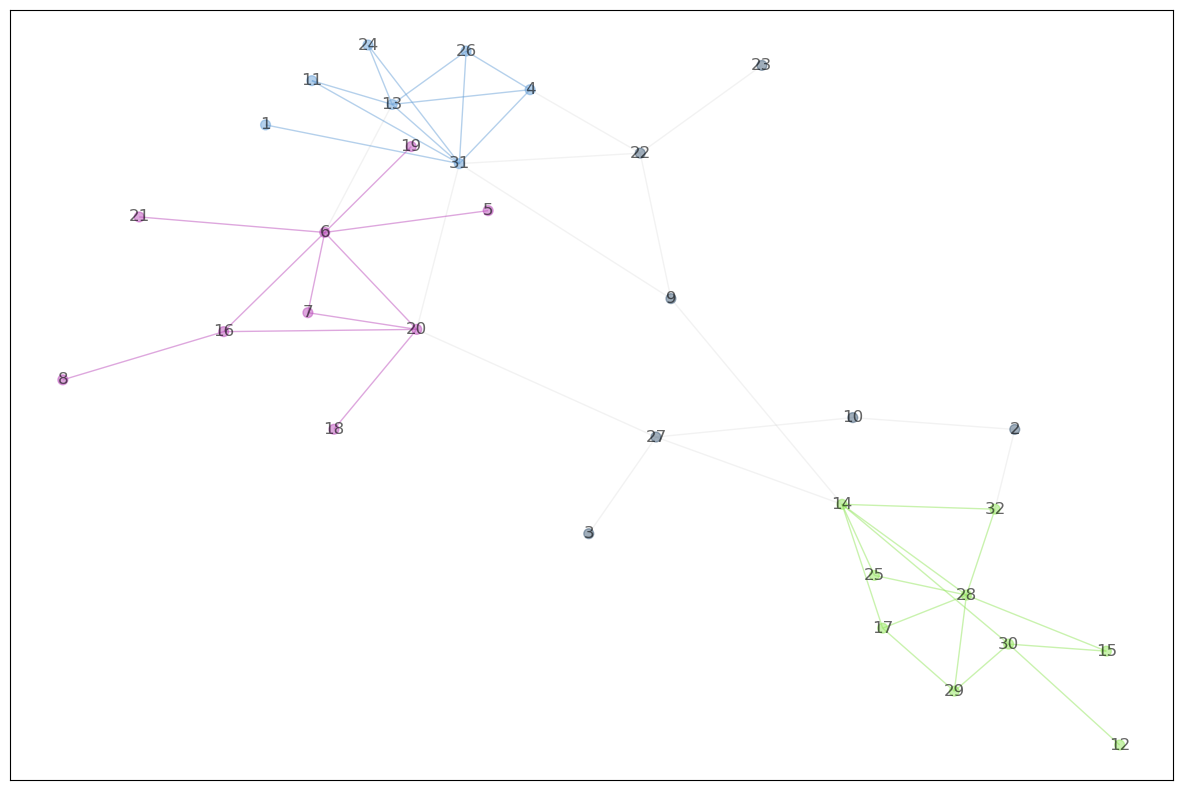

In [355]:
nx.draw_networkx(graph, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=True)
nx.draw_networkx(graph, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=True)
plt.show()

In [356]:
#infomap

In [ ]:
#safeness gain
